# Mongoose demonstrator on Pilot 2

This notebook provides a walkthrough of Pilot 2, which involves a Visium multi-omic dataset (RNA/Protein) related to breast cancer. Using UnitedNet, we will introduce a 3rd modality "niche" which will reflect spatial awareness in terms of gene expression.

The purpose of this analysis is to perform digital-KOs on key drivers of the breast Tumor Micro-Environment (TME) to simulate genetic or potentially drug-related interventions with possible translational implications for therapies.

Mongoose will (a) deploy UnitedNet to obtain cross-modal predictions (RNA to protein and RNA to niche modality) through explainable AI via SHAP values, (b) deploy GenKI to conduct simulations on KOs, (c) combine GenKi and UnitedNet results to obtain a more multi-omic and spatially aware understanding of molecules that could be affected by the digital KOs.

## Dependencies

In [22]:
import os
os.chdir('../')

# Import libraries from general conda environment
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import adjusted_rand_score, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
from scipy.optimize import linear_sum_assignment
import copy as copy
import pickle
from functools import reduce
from pathlib import Path

# Import libraries from UnitedNet
import sys
import os
from unitednet.interface import UnitedNet
from unitednet.configs import *
from unitednet.data import partitions,save_umap,generate_adata
from unitednet.scripts import ordered_cmat,assignmene_align

# Import for SHAPs
import shap
import torch
import torch.nn as nn
from unitednet.modules import submodel_trans, submodel_clus
from unitednet.data import save_obj, load_obj, type_specific_mean
from unitednet.plots import markers_chord_plot,type_relevance_chord_plot,feature_relevance_chord_plot,merge_sub_feature

# Import for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors

# Import for more detailed plotting
import matplotlib as mpl
from  matplotlib.ticker import FuncFormatter

# Import STRINGdb for PPI network models and Networkx for visualisation and potential graph analysis
import stringdb
import networkx as nx
import math

os.chdir('Scripts')

In [23]:
def change_label(adata,batch):
    adata.obs['batch'] = batch
    adata.obs['imagecol'] = adata.obs['array_col']
    adata.obs['imagerow'] = adata.obs['array_row']
    adata.obs['label'] = adata.obs['leiden']
    return adata


def pre_ps(adata_list,sc_pre = None):
    adata_list_all = [ad_x.copy() for ad_x in adata_list]
    scalars = []
    assert (adata_list_all[0].X>=0).all(), "poluted input"
    for idx, mod in enumerate(adata_list_all):
        t_x = mod.X
        if sc_pre != None:
            scaler = sc_pre[idx]
        else:
            scaler = preprocessing.StandardScaler().fit(t_x)
        t_x = scaler.transform(t_x)
        mod.X = t_x
        adata_list_all[idx] = mod
        scalars.append(scaler)

    return adata_list_all,scalars

In [24]:
# Prepare for cpu processing (GPU is also an option...)
technique = 'visium'
device = "cuda:0"
data_path = f'../Data'
root_save_path = f'./saved_results/{technique}'

## Data preparation

Initially, we are going to create the 3rd modality called "niche" modality which provides a spatially aware understanding of gene expression on the Visium dataset. Each value in the niche modality matrix corresponds to a weighted average expression of a gene, not just from the cell/spot itself, but from its neighbourhood — i.e., nearby cells or spots in space. **This provides a spatially aware glimpse on the gene expression, providing useful spatial context for our analysis.**

#### **Generating the niche expression modality**

Using the measured expression of RNAs of cells or spots, we incorporate the spatial information of each cell or spot and generate a weighted average expression of RNAs.

With two-dimensional spatial coordinates \( (s^1_i, s^2_i) \) and modality \( v \) with its \( i \)-th row \( x^{(v)}_i \) corresponding to cell/spot \( i \), we compute the niche modality for modality \( v \), denoted by \( x^{(v_{\text{niche}})} \), with \( v = 1, \ldots, V \).

For cell/spot \( i \), we compute:

$$
x^{(v_{\text{niche}})}_i = \sum_{j=1}^{J} x^{(v)}_j \cdot w_{ij} 
$$

where \( j \in \{1, \ldots, J\} \) denotes the \( J \)-nearest neighbors of cell/spot \( i \), and \( w_{ij} \) is calculated by:

$$
w_{ij} = \frac{1}{\text{distance}\left((s^1_i, s^2_i), (s^1_j, s^2_j)\right)} \bigg/ \sum_{j=1}^{J} \frac{1}{\text{distance}\left((s^1_i, s^2_i), (s^1_j, s^2_j)\right)} 
$$

where \( \text{distance}(\cdot) \) denotes the Euclidean distance between two vectors.


In [ ]:
adata_rnas = sc.read_h5ad('../Data/visium/RNA_BC_500_v2.h5ad')
adata_rnas.X = adata_rnas.X.toarray().astype('float64')
adata_proteins = sc.read_h5ad('../Data/visium/protein_BC.h5ad')

In [ ]:
adata_proteins.var_names = adata_proteins.var["gene_ids"].astype(str)

In [ ]:
X = adata_rnas.X.toarray() if hasattr(adata_rnas.X, "toarray") else adata_rnas.X
X = X.astype(np.float32)  # Ensure dtype is float32
adata_rnas.X = X
print("dtype:", X.dtype)
print("min/max:", X.min(), "/", X.max())
print("mean:", X.mean(), " std:", X.std())
print("zero fraction:", np.mean(X == 0))

In [ ]:
X = adata_proteins.X.toarray() if hasattr(adata_proteins.X, "toarray") else adata_proteins.X
X = X.astype(np.float32)  # Ensure dtype is float32
adata_proteins.X = X
print("dtype:", X.dtype)
print("min/max:", X.min(), "/", X.max())
print("mean:", X.mean(), " std:", X.std())
print("zero fraction:", np.mean(X == 0))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create coordinate array
coord = np.array((list(adata_rnas.obs['array_row'].astype('int')),
                  list(adata_rnas.obs['array_col'].astype('int')))).T

united_clus = adata_rnas.obs['leiden']

# Ensure cluster labels are strings or integers
unique_predicted_clusters = np.unique(united_clus)

# Generate a color map for clusters
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_predicted_clusters)))
color_dict = {clus_id: colors[idx] for idx, clus_id in enumerate(unique_predicted_clusters)}

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the cluster scatter plot
for clus_id in unique_predicted_clusters:
    mask = united_clus == clus_id 
    ax.scatter(
        adata_rnas.obs['array_row'][mask],
        adata_rnas.obs['array_col'][mask],
        color=color_dict[clus_id],  
        label=f"Cluster {clus_id}"
    )

ax.axis('off')
ax.legend()
ax.invert_yaxis()
ax.set_title("Cluster Plot")


plt.show()


In [ ]:
class Params:
    def __init__(self):
        self.knn_distanceType = 'euclidean'
        self.k = 9
        self.using_mask = False

params = Params()

In [ ]:
def sparse_mx_to_torch_sparse_tensor(scipy_matrix):
    """Convert a scipy sparse matrix to a PyTorch sparse tensor."""
    # Ensure it's in the correct format (COO format)
    scipy_matrix = scipy_matrix.tocoo()
    
    # Get row, column, and data from the COO matrix
    row = torch.LongTensor(scipy_matrix.row)
    col = torch.LongTensor(scipy_matrix.col)
    data = torch.FloatTensor(scipy_matrix.data)
    
    # Create a sparse tensor in PyTorch
    sparse_tensor = torch.sparse.FloatTensor(torch.stack([row, col]), data, torch.Size(scipy_matrix.shape))
    
    return sparse_tensor

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return adj_normalized, sparse_mx_to_torch_sparse_tensor(adj_normalized)

def edgeList2edgeDict(edgeList, nodesize):
    graphdict = {}
    tdict = {}
    for edge in edgeList:
        end1 = edge[0]
        end2 = edge[1]
        tdict[end1] = ""
        tdict[end2] = ""
        if end1 in graphdict:
            tmplist = graphdict[end1]
        else:
            tmplist = []
        tmplist.append(end2)
        graphdict[end1] = tmplist

    # check and get full matrix
    for i in range(nodesize):
        if i not in tdict:
            graphdict[i] = []

    return graphdict

def graph_computing(adj_coo, cell_num, params):
    edgeList = []
    for node_idx in range(cell_num):
        tmp = adj_coo[node_idx, :].reshape(1, -1)
        distMat = distance.cdist(tmp, adj_coo, params.knn_distanceType)
        res = distMat.argsort()[:params.k + 1]
        tmpdist = distMat[0, res[0][1:params.k + 1]]
        boundary = np.mean(tmpdist) + np.std(tmpdist)
        for j in np.arange(1, params.k + 1):
            if distMat[0, res[0][j]] <= boundary:
                weight = 1.0
            else:
                weight = 0.0
            edgeList.append((node_idx, res[0][j], weight))

    return edgeList

def graph_construction(adj_coo, cell_N, params):
    adata_Adj = graph_computing(adj_coo, cell_N, params)
    graphdict = edgeList2edgeDict(adata_Adj, cell_N)
    adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))

    # Store original adjacency matrix (without diagonal entries) for later
    adj_m1 = adj_org
    adj_m1 = adj_m1 - sp.dia_matrix((adj_m1.diagonal()[np.newaxis, :], [0]), shape=adj_m1.shape)
    adj_m1.eliminate_zeros()

    # Some preprocessing
    adj_norm_write, adj_norm_m1 = preprocess_graph(adj_m1)
    adj_label_m1 = adj_m1 + sp.eye(adj_m1.shape[0])
    adj_label_m1 = torch.FloatTensor(adj_label_m1.toarray())
    norm_m1 = adj_m1.shape[0] * adj_m1.shape[0] / float((adj_m1.shape[0] * adj_m1.shape[0] - adj_m1.sum()) * 2)

    graph_dict = {
        "adj_org": adj_org,
        "adj_norm": adj_norm_m1,
        "adj_label": adj_label_m1,
        "norm_value": norm_m1
    }
    # mask is binary matrix for semi-supervised/multi-dataset (1-valid edge, 0-unknown edge)
    if params.using_mask is True:
        graph_dict["adj_mask"] = torch.ones(cell_N, cell_N)
    return graph_dict, adj_norm_write

In [ ]:
graph_dict, adj_norm_write = graph_construction(adata_rnas.obsm['spatial'], adata_rnas.shape[0], params)

### save niche_mrna
adj_label = graph_dict['adj_label'].cpu().detach().numpy()
spatial_coo=adata_rnas.obsm['spatial']
niche_mrna=np.zeros(adata_rnas.X.shape)
for ind,i in enumerate(adj_label):
    distMat = distance.cdist(spatial_coo[ind,:].reshape(1,-1), spatial_coo[i.astype(bool),:], metric='euclidean')
    distMat[distMat>0]=1/distMat[distMat>0]
    distMat_normed = distMat / sum(sum(distMat))
    niche_mrna[ind, :] = distMat_normed.dot(adata_rnas.X[i.astype(bool), :])
### save niche_mrna
mrna=pd.DataFrame(niche_mrna.T,index=adata_rnas.var_names,columns=adata_rnas.obs_names)
mrna.to_csv('../Data/visium/niche_mrna_VisiumRNABC.csv')

In [ ]:
df = pd.read_csv("../Data/visium/niche_mrna_VisiumRNABC.csv", index_col=0)  # Assuming the first column is gene/sample names
df = df.T

In [ ]:
adata_niche = anndata.AnnData(X=df.values, obs=pd.DataFrame(index=df.index), var=pd.DataFrame(index=df.columns))

In [ ]:
cell_metadata = adata_rnas.obs  # Metadata for samples/cells
gene_metadata = adata_rnas.var  # Metadata for genes

In [ ]:
adata_niche.obs = cell_metadata  # Assign metadata to adata.obs
adata_niche.var = gene_metadata
adata_proteins.obs = cell_metadata

In [ ]:
X = adata_niche.X.toarray() if hasattr(adata_niche.X, "toarray") else adata_niche.X
X = X.astype(np.float32)  # Ensure dtype is float64
adata_niche.X = X
print("dtype:", X.dtype)
print("min/max:", X.min(), "/", X.max())
print("mean:", X.mean(), " std:", X.std())
print("zero fraction:", np.mean(X == 0))

In [ ]:
adata_niche.write("../Data/visium/niche_mrna_VisiumRNABC.h5ad")

Next, we will prepare train/test datasets for the 3 modalities:

In [ ]:
# Define the split ratio
train_size = 0.8

# Get total number of observations (cells)
n_samples = adata_rnas.n_obs

# Generate indices
train_idx, test_idx = train_test_split(np.arange(n_samples), train_size=train_size, random_state=42)

# Split the AnnData object
adata_rnas_train = adata_rnas[train_idx].copy()
adata_rnas_test = adata_rnas[test_idx].copy()
adata_rnas_train.write_h5ad('../Data/visium/adata_rna_train_V3.h5ad')
adata_rnas_test.write_h5ad('../Data/visium/adata_rna_test_V3.h5ad')

# Split the AnnData object
adata_proteins_train = adata_proteins[train_idx].copy()
adata_proteins_test = adata_proteins[test_idx].copy()
adata_proteins_train.write_h5ad('../Data/visium/adata_protein_train_V3.h5ad')
adata_proteins_test.write_h5ad('../Data/visium/adata_protein_test_V3.h5ad')

# Split the AnnData object
adata_niche_train = adata_niche[train_idx].copy()
adata_niche_test = adata_niche[test_idx].copy()
adata_niche_train.write_h5ad('../Data/visium/adata_niche_rna_train_V3.h5ad')
adata_niche_test.write_h5ad('../Data/visium/adata_niche_rna_test_V3.h5ad')


# Running UnitedNet

Now, we are going to run UnitedNet, which will provide us with information regarding clusters and modalities, as well as modalities-to-modalities relationships. This will be achieved through SHAP values.

**SHAP Values in UnitedNet**

UnitedNet uses **SHapley Additive exPlanations (SHAP)** to uncover which features (e.g., genes, proteins, ATAC peaks) are most influential in either **group identification** or **cross-modal prediction**. After the model is trained, SHAP assigns an *importance score* to each input feature by quantifying its contribution to a specific output (e.g., a cell type label or a predicted gene). These scores help identify **cell-type-specific marker features** and also reveal **cross-modal feature-to-feature relevance**, such as which genes are predictive of electrophysiological properties or spatial protein expression. This makes UnitedNet not only predictive, but also biologically interpretable.


## Data set-up

In [25]:
# Load input datasets

# RNA Modality
adata_rna_train = sc.read_h5ad(f'{data_path}/adata_rna_train_V3.h5ad')
adata_rna_test = sc.read_h5ad(f'{data_path}/adata_rna_test_V3.h5ad')

# Protein Modality
adata_protein_train = sc.read_h5ad(f'{data_path}/adata_protein_train_V3.h5ad')
adata_protein_test = sc.read_h5ad(f'{data_path}/adata_protein_test_V3.h5ad')

# Niche Modality
adata_niche_rna_train = sc.read_h5ad(f'{data_path}/adata_niche_rna_train_V3.h5ad')
adata_niche_rna_test = sc.read_h5ad(f'{data_path}/adata_niche_rna_test_V3.h5ad')

# Prepare train and testing datasets for UnitedNet
adata_rna_train = change_label(adata_rna_train,'train')
adata_protein_train=change_label(adata_protein_train,'train')
adata_niche_rna_train=change_label(adata_niche_rna_train,'train')

adata_rna_test = change_label(adata_rna_test,'test')
adata_protein_test = change_label(adata_protein_test,'test')
adata_niche_rna_test = change_label(adata_niche_rna_test,'test')

# Merge the 3 modalities of BC Visium data into 1 adata object for training and testing data
adatas_train = [adata_rna_train, adata_protein_train, adata_niche_rna_train]
adatas_test = [adata_rna_test, adata_protein_test, adata_niche_rna_test]

# Disable .raw for all datasets
for ad in adatas_train + adatas_test:
    ad.raw = None

# Now safe to concatenate
adatas_all = []
for ad_train, ad_test in zip(adatas_train, adatas_test):
    ad_all = ad_train.concatenate(ad_test, batch_key='sample')
    ad_all = change_label(ad_all, 'test')
    adatas_all.append(ad_all)

# Merge train and test
adatas_all = []
for ad_train, ad_test in zip(adatas_train,adatas_test):
    ad_all = ad_train.concatenate(ad_test,batch_key='sample')
    ad_all = change_label(ad_all,'test')
    adatas_all.append(ad_all)
adatas_all,_ = pre_ps(adatas_all)

adatas_train,_ = pre_ps(adatas_train)
adatas_test,_ = pre_ps(adatas_test)

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
X.dtype being converted to np.float32 from float64. In the next 

## Training UnitedNet model

In this stage, we define firstly a config file that will be used for the ensuing analysis. This config needs to be tailored to each dataset in focus each time, and for the optimal performance of UnitedNet, hyper-parameter tuning could be in order.

###  UnitedNet Configuration Summary (DBiT-seq Setup)

| Category         | Parameter             | Value / Setting                      | Description |
|------------------|------------------------|--------------------------------------|-------------|
| **Training**     | `train_batch_size`     | `16`                                 | Batch size during training phase for cross-modal prediction |
|                  | `train_epochs`         | `20`                                 | Number of training epochs for initial learning |
|                  | `train_task`           | `'cross_model_prediction_clus'`     | Specifies training objective: joint cross-modal prediction and clustering |
| **Fine-tuning**  | `finetune_batch_size`  | `16`                                 | Batch size for the fine-tuning phase |
|                  | `finetune_epochs`      | `10`                                 | Number of epochs used during fine-tuning |
|                  | `finetune_task`        | `'unsupervised_group_identification'` | Focuses on refining latent codes to capture unsupervised group structure |
| **Transfer**     | `transfer_task`        | `None`                               | Placeholder for transfer learning phase (not used here) |
| **Learning Rate**| `lr`                   | `0.001`                              | Initial learning rate used by the optimizer |
| **Checkpointing**| `checkpoint`           | `20`                                 | Save model after every 20 epochs |
| **Attention**    | `n_head`               | `10`                                 | Number of attention heads if transformer-based modules are used |
| **Fusion**       | `fuser_type`           | `'WeightedMean'`                     | Method for combining modality-specific latent codes |
| **Noise**        | `noise_level`          | `[0, 0, 0]`                           | Controls modality-specific noise injections (0 = none) |

| **Encoder**      | Hidden Layers          | `[256, 128, 64]`                      | Three-layer fully connected neural net with ReLU activations |
|                  | Output Dimension       | `35`                                 | Final encoded latent dimension for each modality |
|                  | `is_binary_input`      | `False`                              | Indicates modality inputs are continuous, not binary |
| **Decoder**      | Hidden Layers          | `[64, 128, 256]`                      | Mirrors encoder for symmetric reconstruction |
|                  | Output Dimension       | Matches input                        | Recovers original feature dimensions per modality |
| **Discriminator**| Hidden Layers          | `[256, 256]`                          | Used for adversarial loss in distinguishing real vs. generated data |
|                  | Output                 | `1` (sigmoid)                        | Binary prediction: real or generated modality sample |
| **Projector**    | Output Dimension       | `64`                                 | Projects encoded vectors into a shared latent space |
| **Clustering**   | Output Clusters        | `9`                                  | Number of clusters (e.g., tissue regions) identified by latent space grouping |

> 🔍 **Note**: Each encoder-decoder-discriminator triplet corresponds to a modality (e.g., RNA, protein, niche RNA). The symmetry ensures meaningful cross-modal reconstruction and explainable SHAP value attribution.


In [14]:
# Config set-up - we are keeping it as close as possible to the original DBiT-seq config file from the original UnitedNet publication



visium_config = {'train_batch_size': 16,
       'finetune_batch_size': 16,
       'transfer_batch_size': None,
       'train_epochs': 20, #20
       'finetune_epochs': 10, #10
       'transfer_epochs': None,
       'train_task': 'cross_model_prediction_clus',
       'finetune_task': 'unsupervised_group_identification',
       'transfer_task': None,
       'train_loss_weight': None,
       'finetune_loss_weight': None,
       'transfer_loss_weight': None,
       'lr': 0.001,
       'checkpoint': 20,
       'n_head': 10,
       'noise_level': [0, 0, 0],
       'fuser_type': 'WeightedMean',
       'encoders': [{'input': 500,
                     'hiddens': [256, 128, 64],
                     'output': 35,
                     'use_biases': [True, True, True, True],
                     'dropouts': [0, 0, 0, 0],
                     'activations': ['relu', 'relu', 'relu', None],
                     'use_batch_norms': [False, False, False, False],
                     'use_layer_norms': [False, False, False, True],
                     'is_binary_input': False},
                    {'input': 35,
                     'hiddens': [256, 128, 64],
                     'output': 35,
                     'use_biases': [True, True, True, True],
                     'dropouts': [0, 0, 0, 0],
                     'activations': ['relu', 'relu', 'relu', None],
                     'use_batch_norms': [False, False, False, False],
                     'use_layer_norms': [False, False, False, True],
                     'is_binary_input': False},
                    {'input': 500,
                     'hiddens': [256, 128, 64],
                     'output': 35,
                     'use_biases': [True, True, True, True],
                     'dropouts': [0, 0, 0, 0],
                     'activations': ['relu', 'relu', 'relu', None],
                     'use_batch_norms': [False, False, False, False],
                     'use_layer_norms': [False, False, False, True],
                     'is_binary_input': False}],
       'latent_projector': None,
       'decoders': [{'input': 35,
                     'hiddens': [64, 128, 256],
                     'output': 500,
                     'use_biases': [True, True, True, True],
                     'dropouts': [0, 0, 0, 0, 0],
                     'activations': ['relu', 'relu', 'relu', None],
                     'use_batch_norms': [False, False, False, False],
                     'use_layer_norms': [False, False, False, False]},
                    {'input': 35,
                     'hiddens': [64, 128, 256],
                     'output': 35,
                     'use_biases': [True, True, True, True],
                     'dropouts': [0, 0, 0, 0],
                     'activations': ['relu', 'relu', 'relu', None],
                     'use_batch_norms': [False, False, False, False],
                     'use_layer_norms': [False, False, False, False]},
                    {'input': 35,
                     'hiddens': [64, 128, 256],
                     'output': 500,
                     'use_biases': [True, True, True, True],
                     'dropouts': [0, 0, 0, 0],
                     'activations': ['relu', 'relu', 'relu', None],
                     'use_batch_norms': [False, False, False, False],
                     'use_layer_norms': [False, False, False, False]}],
       'discriminators': [{'input': 500,
                           'hiddens': [256, 256],
                           'output': 1,
                           'use_biases': [True, True, True],
                           'dropouts': [0, 0, 0, 0],
                           'activations': ['relu', 'relu', 'sigmoid'],
                           'use_batch_norms': [False, False, False],
                           'use_layer_norms': [False, False, True]},
                          {'input': 35,
                           'hiddens': [256, 256],
                           'output': 1,
                           'use_biases': [True, True, True],
                           'dropouts': [0, 0, 0],
                           'activations': ['relu', 'relu', 'sigmoid'],
                           'use_batch_norms': [False, False, False],
                           'use_layer_norms': [False, False, True]},
                          {'input': 500,
                           'hiddens': [256, 256],
                           'output': 1,
                           'use_biases': [True, True, True],
                           'dropouts': [0, 0, 0],
                           'activations': ['relu', 'relu', 'sigmoid'],
                           'use_batch_norms': [False, False, False],
                           'use_layer_norms': [False, False, True]}],
       'projectors': {'input': 35,
                      'hiddens': [],
                      'output': 64,
                      'use_biases': [True],
                      'dropouts': [0],
                      'activations': ['relu'],
                      'use_batch_norms': [False],
                      'use_layer_norms': [True]},
       'clusters': {'input': 64,
                    'hiddens': [],
                    'output': 9,
                    'use_biases': [False],
                    'dropouts': [0],
                    'activations': [None],
                    'use_batch_norms': [False],
                    'use_layer_norms': [False]}
       }


If you want to just run a training session, run the following code chunk and skip hyper-parameter tuning

In [15]:
train_model = False # False = Model already trained and saved in saved_results folder
model = UnitedNet(root_save_path, device=device, technique=visium_config)

if train_model:
    model.train(adatas_train,verbose=True)
    model.finetune(adatas_all,verbose=True)

    #Save the model
    with open('model_Pilot_2.pkl', 'wb') as file:
       pickle.dump(model, file)
    

else:
    # Load the model
    with open('model_Pilot_2.pkl', 'rb') as file:
        model = pickle.load(file)

## Hyper-parameter tuning for Learning Rate (LR)

In the following code chunk, we showcase how hyper-parameter tuning can be approached; we use the **Learning Rate (LR)** as an indicative parameter that may necessitate close scrutiny and tuning:

In [ ]:
# # Initialize the tables as lists of dicts
# acc_table = []
# nmi_table = []
# ari_table = []
# total_loss_table = []

# # Loop over learning rates
# lr_list = [0.0005, 0.0001, 0.005, 0.001,0.05, 0.01,0.5, 0.1]
# # lr_list = [0.001]
# for lr in lr_list:
#     #print('the lr is:')
#     #print(lr)
#     visium_config['lr'] = lr
#     train_model = True  # False = Model already trained and saved in saved_results folder
#     model = UnitedNet(root_save_path, device=device, technique=visium_config)
    
#     if train_model:
#         train_total_loss_list, train_acc_list, train_ari_list, train_nmi_list = model.train(adatas_train, verbose=True)
#         finetune_total_loss_list, finetune_acc_list, finetune_ari_list, finetune_nmi_list = model.finetune(adatas_all, verbose=True)
#     else:
#         model.load_model(f"{root_save_path}/train_best.pt", device=device)
    
#     import matplotlib.pyplot as plt
    
#     # Helper for X axis:
#     epochs_train = range(1, len(train_total_loss_list)+1)
#     epochs_finetune = range(1, len(finetune_total_loss_list)+1)
#     max_epochs = max(len(train_total_loss_list), len(finetune_total_loss_list))
    
#     # Save final metrics (last epoch value)
#     acc_table.append({
#         'lr': lr,
#         'Train Accuracy': train_acc_list[-1],
#         'Finetune Accuracy': finetune_acc_list[-1]
#     })
    
#     nmi_table.append({
#         'lr': lr,
#         'Train NMI': train_nmi_list[-1],
#         'Finetune NMI': finetune_nmi_list[-1]
#     })
    
#     ari_table.append({
#         'lr': lr,
#         'Train ARI': train_ari_list[-1],
#         'Finetune ARI': finetune_ari_list[-1]
#     })
    
#     total_loss_table.append({
#         'lr': lr,
#         'Train Total Loss': train_total_loss_list[-1],
#         'Finetune Total Loss': finetune_total_loss_list[-1]
#     })
    
#     # === 1️⃣ Accuracy Plot ===
#     plt.figure(figsize=(8,5))
#     plt.plot(epochs_train, train_acc_list, label='Train Accuracy', marker='o', markerfacecolor='black')
#     plt.plot(epochs_finetune, finetune_acc_list, label='Finetune Accuracy', marker='o', markerfacecolor='black')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Accuracy: Train vs Finetune')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(range(1, max_epochs + 1))
#     plt.savefig(f'Accuracy_lr={lr}.pdf')
#     #plt.show()
    
#     # === 2️⃣ NMI Plot ===
#     plt.figure(figsize=(8,5))
#     plt.plot(epochs_train, train_nmi_list, label='Train NMI', marker='o', markerfacecolor='black')
#     plt.plot(epochs_finetune, finetune_nmi_list, label='Finetune NMI', marker='o', markerfacecolor='black')
#     plt.xlabel('Epoch')
#     plt.ylabel('NMI')
#     plt.title('NMI: Train vs Finetune')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(range(1, max_epochs + 1))
#     plt.savefig(f'NMI_lr={lr}.pdf')
#     #plt.show()
    
#     # === 3️⃣ Total Loss Plot ===
#     plt.figure(figsize=(8,5))
#     plt.plot(epochs_train, train_total_loss_list, label='Train Total Loss', marker='o', markerfacecolor='black')
#     plt.plot(epochs_finetune, finetune_total_loss_list, label='Finetune Total Loss', marker='o', markerfacecolor='black')
#     plt.xlabel('Epoch')
#     plt.ylabel('Total Loss')
#     plt.title('Total Loss: Train vs Finetune')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(range(1, max_epochs + 1))
#     plt.savefig(f'Total_Loss_lr={lr}.pdf')
#     #plt.show()
    
#     # === 4️⃣ ARI Plot ===
#     plt.figure(figsize=(8,5))
#     plt.plot(epochs_train, train_ari_list, label='Train ARI', marker='o', markerfacecolor='black')
#     plt.plot(epochs_finetune, finetune_ari_list, label='Finetune ARI', marker='o', markerfacecolor='black')
#     plt.xlabel('Epoch')
#     plt.ylabel('ARI')
#     plt.title('ARI: Train vs Finetune')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(range(1, max_epochs + 1))
#     plt.savefig(f'ARI_lr={lr}.pdf')
#     #plt.show()

#     filename = f"model_{lr}.pkl"
#     with open(filename, 'wb') as f:
#         pickle.dump(model, f)

# # === At the end: convert the tables to DataFrames and print them ===
# import pandas as pd

# acc_df = pd.DataFrame(acc_table)
# nmi_df = pd.DataFrame(nmi_table)
# ari_df = pd.DataFrame(ari_table)
# total_loss_df = pd.DataFrame(total_loss_table)

# # Print the tables
# # print("\n====== Accuracy Table ======")
# # print(acc_df)

# # print("\n====== NMI Table ======")
# # print(nmi_df)

# # print("\n====== ARI Table ======")
# # print(ari_df)

# # print("\n====== Total Loss Table ======")
# # print(total_loss_df)

# # Optional: save them as CSV
# acc_df.to_csv('Accuracy_table.csv', index=False)
# nmi_df.to_csv('NMI_table.csv', index=False)
# ari_df.to_csv('ARI_table.csv', index=False)
# total_loss_df.to_csv('Total_Loss_table.csv', index=False)

## Joint Group Identification and explainability by SHAP

In this step, we are focusing on the first task from UnitedNet's multi-task learning logic which is Joint Group Identification meaning that UnitedNet will pull information from all 3 modalities and will detect clusters on the Visium datasets. In doing so, UnitedNet allows for AI explainability through SHAP values which indicate which features were mostly informative for the designation of the detected clusters.

In [6]:
# SHAP values for joint feature-to-group relevance

# Define the modality names
modality_names = ["RNA", "PROTEINS", "NICHE"]

# Extract spatial domain names
cluster_prototype_features = [
    type_specific_mean(ad_x, "label").to(device=model.device) for ad_x in adatas_all
]

# Define modalities
test_type = [
    torch.tensor(adatas_all[0].X, device=model.device),
    torch.tensor(adatas_all[1].X, device=model.device),
    torch.tensor(adatas_all[2].X, device=model.device),
]


# predict_label = model.predict_label(adatas_all)
# adata_fused = model.infer(adatas_all)
# predict_label_anno = adata_fused.obs['predicted_label']
# adata_fused.obs['label'] = list(adatas_all[0].obs['label'])

predict_label = model.predict_label(adatas_all)
adata_fused = model.infer(adatas_all)

# Assign correct predicted label to obs (aligned with adata_fused)
adata_fused.obs['predicted_label'] = pd.Categorical(predict_label)
predict_label_anno = adata_fused.obs['predicted_label']

# Re-assign true label (if needed)
adata_fused.obs['label'] = adatas_all[0].obs['label'].values


In [7]:
calculate_shap = False

if calculate_shap:
    sub = submodel_clus(model.model).to(model.device)
    background = cluster_prototype_features
    e = shap.DeepExplainer(sub, background)
    shap_values = e.shap_values(test_type, check_additivity=False)
    with open("shap_values_visium.pkl", "wb") as f:
        pickle.dump(shap_values, f)
else:
    with open("shap_values_visium.pkl", "rb") as f:
        shap_values = pickle.load(f)

In [8]:
predict_label = model.predict_label(adatas_all)
united_clus = list(predict_label)
unique_predicted_clusters = np.unique(united_clus)

In [9]:
# Define clusters
major_dict = {
    cluster_id: f"Cluster {cluster_id}" for cluster_id in unique_predicted_clusters
}
major_dict


# Plotting begins..
adatas_all_new, p_fe, p_fe_idx, p_l_less, pr_ty_dict = markers_chord_plot(
    adatas_all, predict_label, predict_label_anno, major_dict, subset_feature=False
)

In [10]:
p_l_less

array(['Cluster 0', 'Cluster 1', 'Cluster 6', ..., 'Cluster 7',
       'Cluster 4', 'Cluster 6'], dtype='<U9')

In [ ]:
#----------

In [11]:
import pandas as pd

print(type(predict_label))                     # should be pandas.Series or np.ndarray
print(pd.api.types.is_categorical_dtype(predict_label))  # True if categorical


<class 'numpy.ndarray'>
False


In [12]:
import pandas as pd
import numpy as np

# 1. Check categorical type
print("Is predict_label categorical?",
      pd.api.types.is_categorical_dtype(predict_label))

# 2. Compare lengths and values
print("Length match:", len(predict_label), len(predict_label_anno))
if len(predict_label) == len(predict_label_anno):
    print("Matching values count:",
          (np.array(predict_label) == np.array(predict_label_anno)).sum())

# 3. Check major_dict alignment
print("major_dict keys:", major_dict.keys())
print("predict_label unique values:", np.unique(predict_label))
print("missing from major_dict:",
      [x for x in np.unique(predict_label) if x not in major_dict])


Is predict_label categorical? False
Length match: 4169 4169
Matching values count: 4169
major_dict keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
predict_label unique values: [0 1 2 3 4 5 6 7 8]
missing from major_dict: []


In [ ]:
#----------

In [13]:
print(f"p_l_less = {p_l_less}")
print(f"Type: {type(p_l_less)}")

p_l_less = ['Cluster 0' 'Cluster 1' 'Cluster 6' ... 'Cluster 7' 'Cluster 4'
 'Cluster 6']
Type: <class 'numpy.ndarray'>


Cluster 0
['G0S2' 'IL1RN' 'CPB1' 'CXCL9' 'SPP1' 'BMPR1B' 'GZMA' 'IFIT2' 'PTPRE'
 'CD6' 'RASGRP2' 'CD163' 'N4BP2L1' 'DHRS2' 'IGHA1' 'FSIP1' 'CCR7' 'RASAL3'
 'NKG7' 'WFDC2' 'PCNA' 'VIM' 'KRT5' 'CD68' 'CEACAM8' 'HLA-DRA' 'SDC1'
 'BCL2' 'CD19' 'ACTA2' 'FCGR3A' 'ITGAX' 'EPCAM' 'MS4A1' 'CD3E' 'PECAM1'
 'CD4' 'CD27' 'CCR7' 'CD274' 'S100A9' 'S100A8' 'IL1RN' 'FDCSP' 'CXCL9'
 'SPP1' 'SLC30A8' 'CCL19' 'SPOCK2' 'IFIT2' 'PTPRE' 'NR1H3' 'CD6' 'SCGB2A2'
 'RASGRP2' 'CPSF6' 'IGHA1' 'CCR7' 'CD79B' 'NKG7' '0']
Cluster 1
['CD52' 'DIRAS3' 'PRRX1' 'FCMR' 'IL1RN' 'CPB1' 'CXCL9' 'SPP1' 'CA2'
 'CCL19' 'CYP2C8' 'NR1H3' 'HVCN1' 'SERPINA3' 'IGHA1' 'FSIP1' 'ITGAX'
 'CCR7' 'DLX4' 'CD37' 'CD163' 'CR2' 'PCNA' 'KRT5' 'CD68' 'SDC1' 'CD8A'
 'BCL2' 'mouse_IgG1k' 'CD19' 'ACTA2' 'FCGR3A' 'ITGAX' 'EPCAM' 'CD3E'
 'CD14' 'PECAM1' 'CD27' 'CCR7' 'CD274' 'CD52' 'S100A8' 'HMCN1' 'PSD4'
 'SPP1' 'FST' 'HAVCR2' 'RSPH4A' 'CCL19' 'TNC' 'ADIRF' 'MMP26' 'NR1H3'
 'RASGRP2' 'ME3' 'CPSF6' 'IGHA1' 'CCR7' 'KRT14' 'NKG7' '1']
Cluster 2
['C1QA

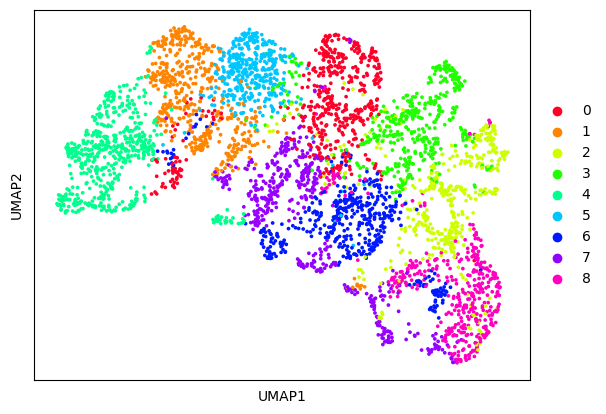

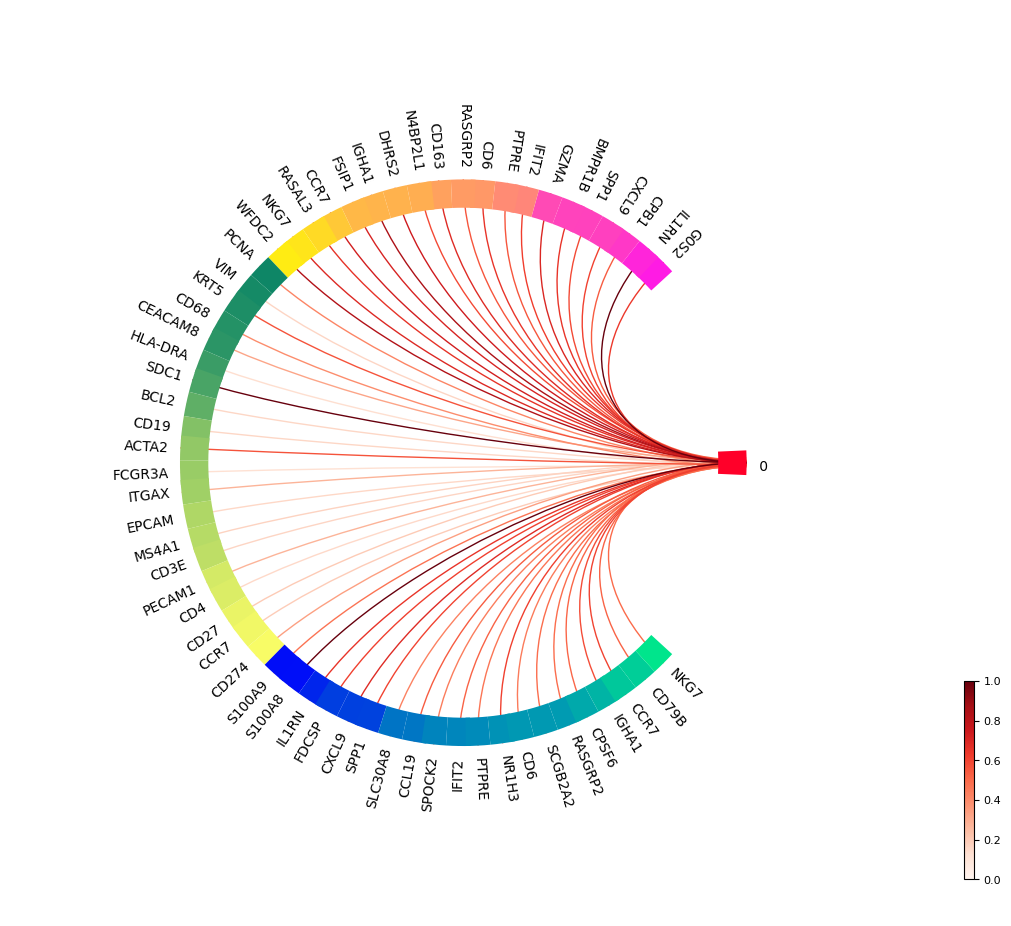

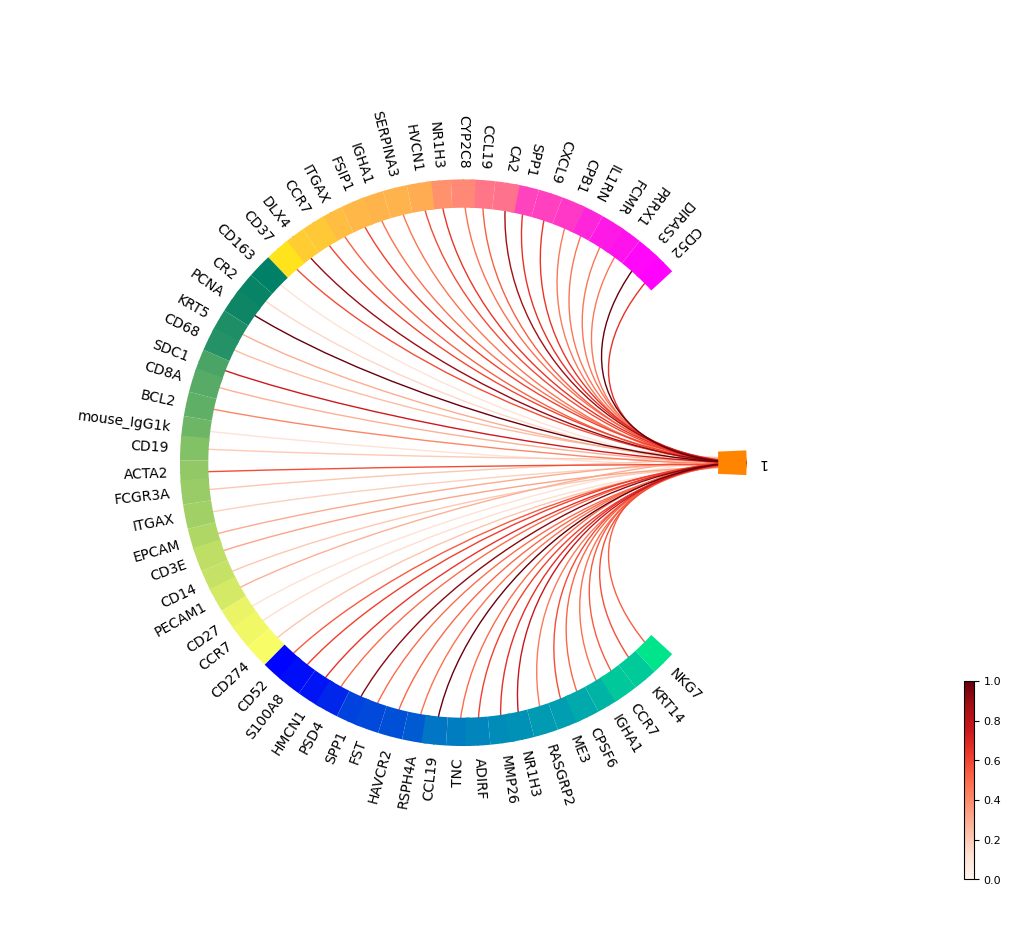

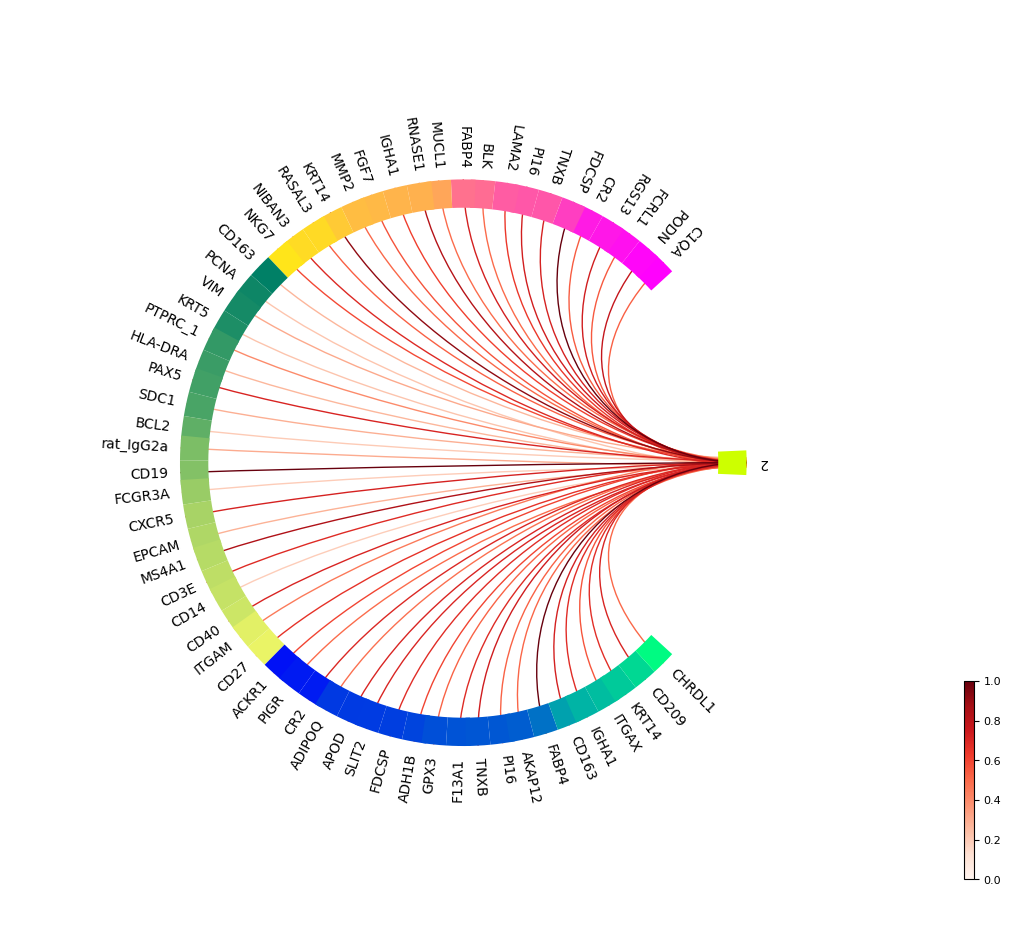

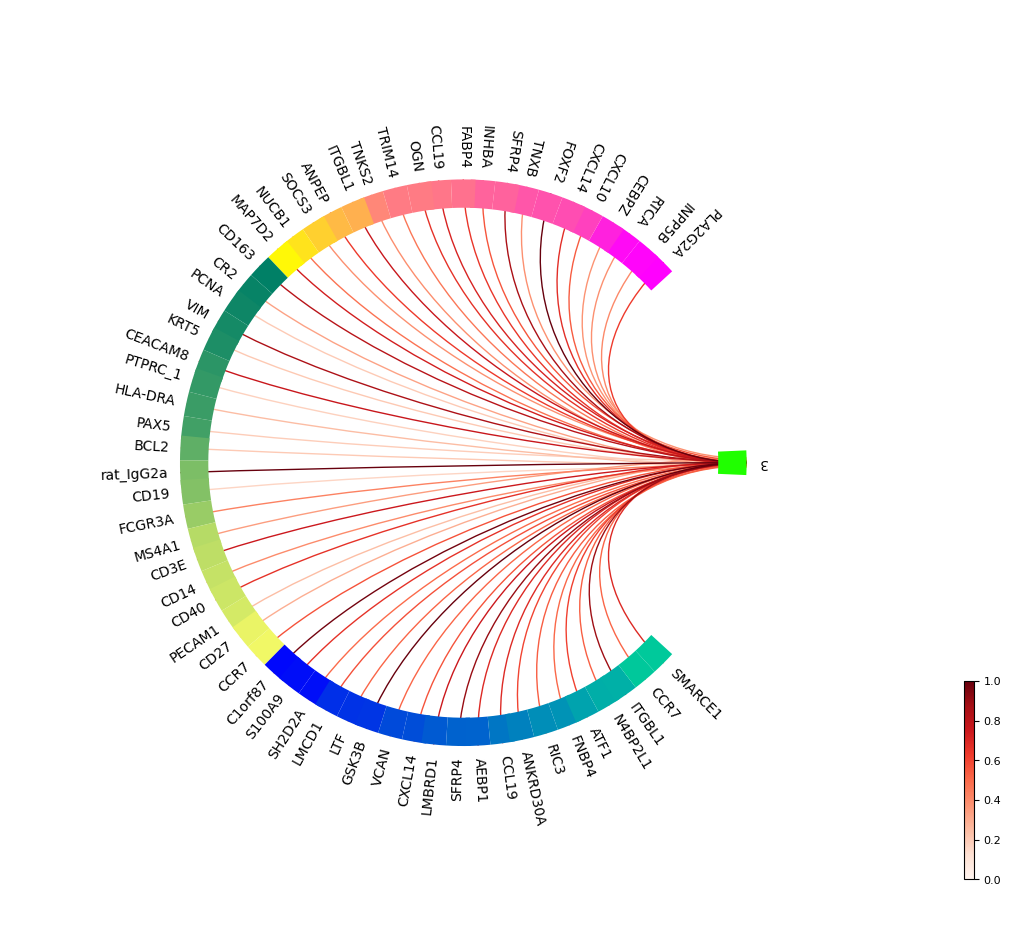

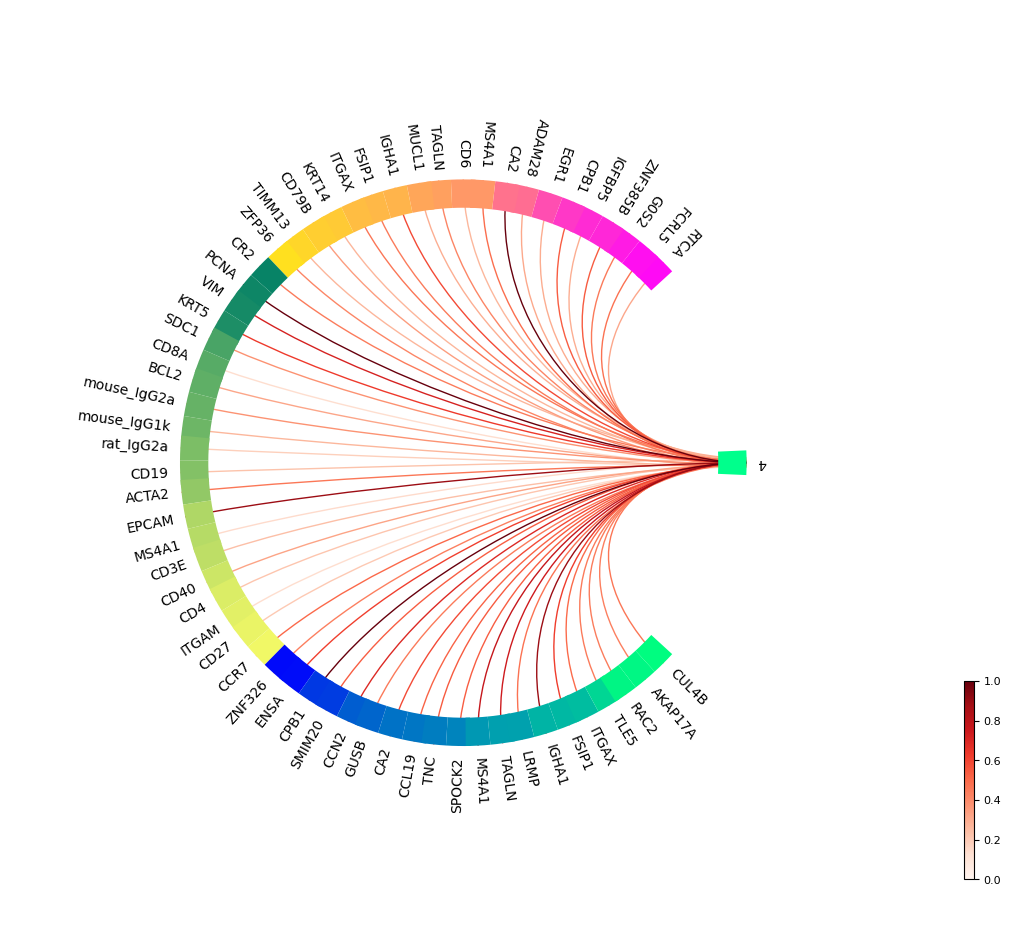

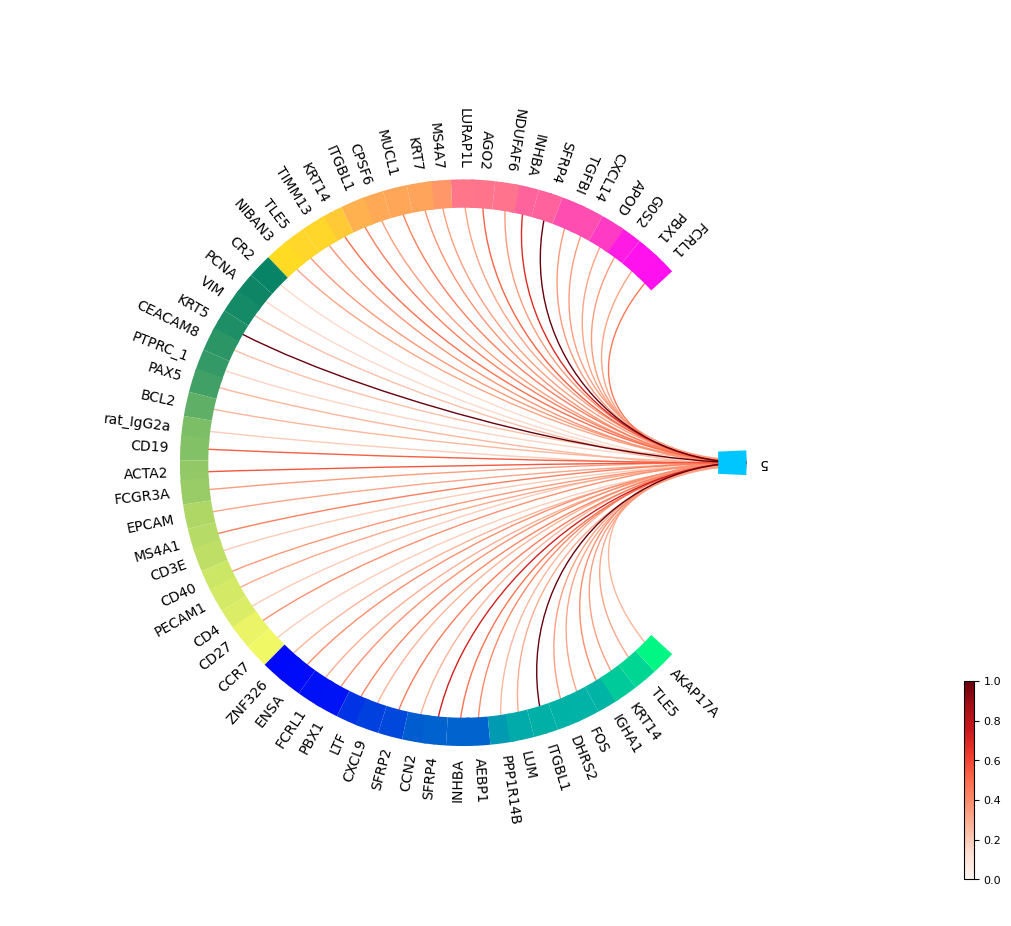

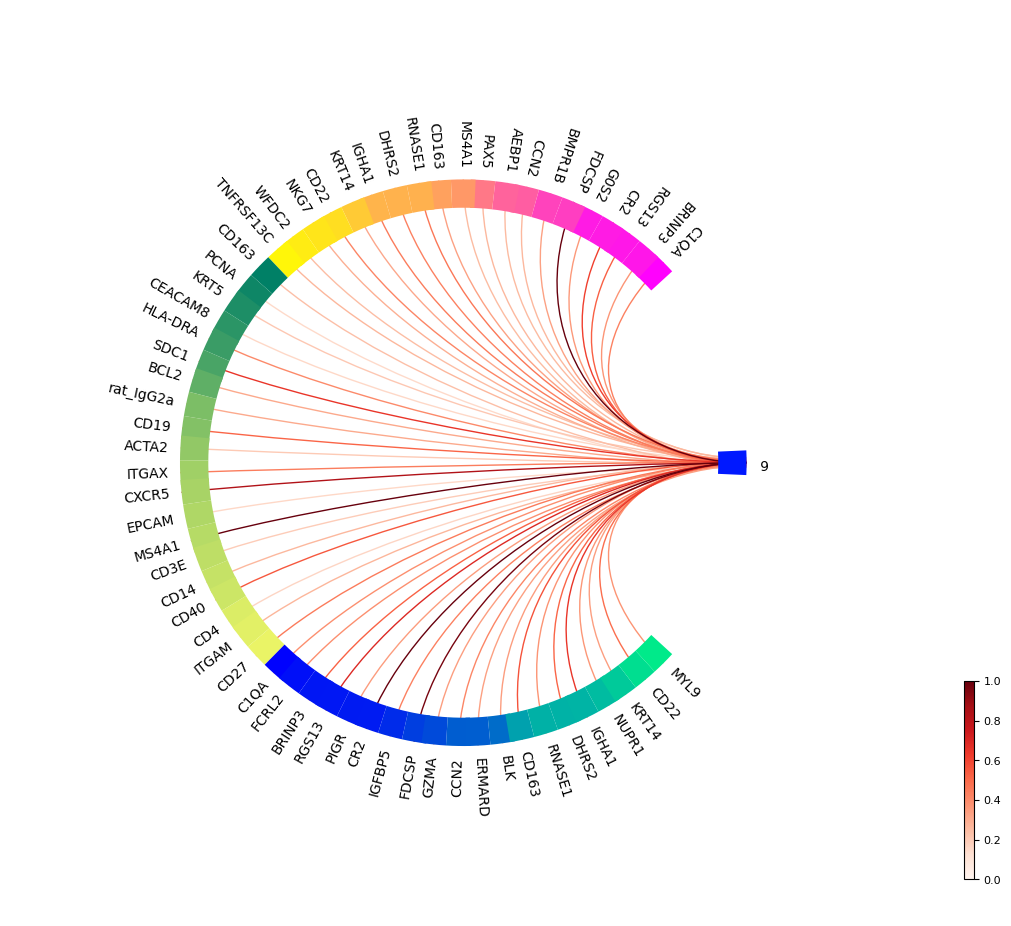

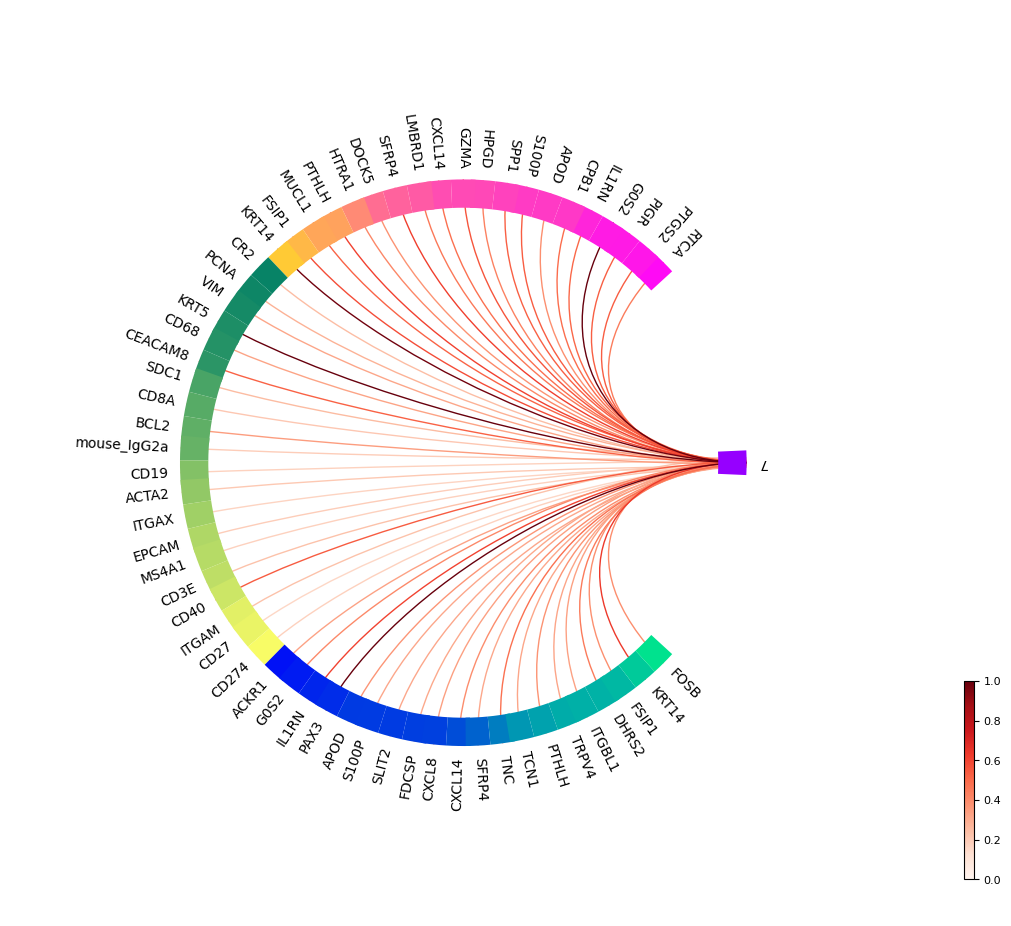

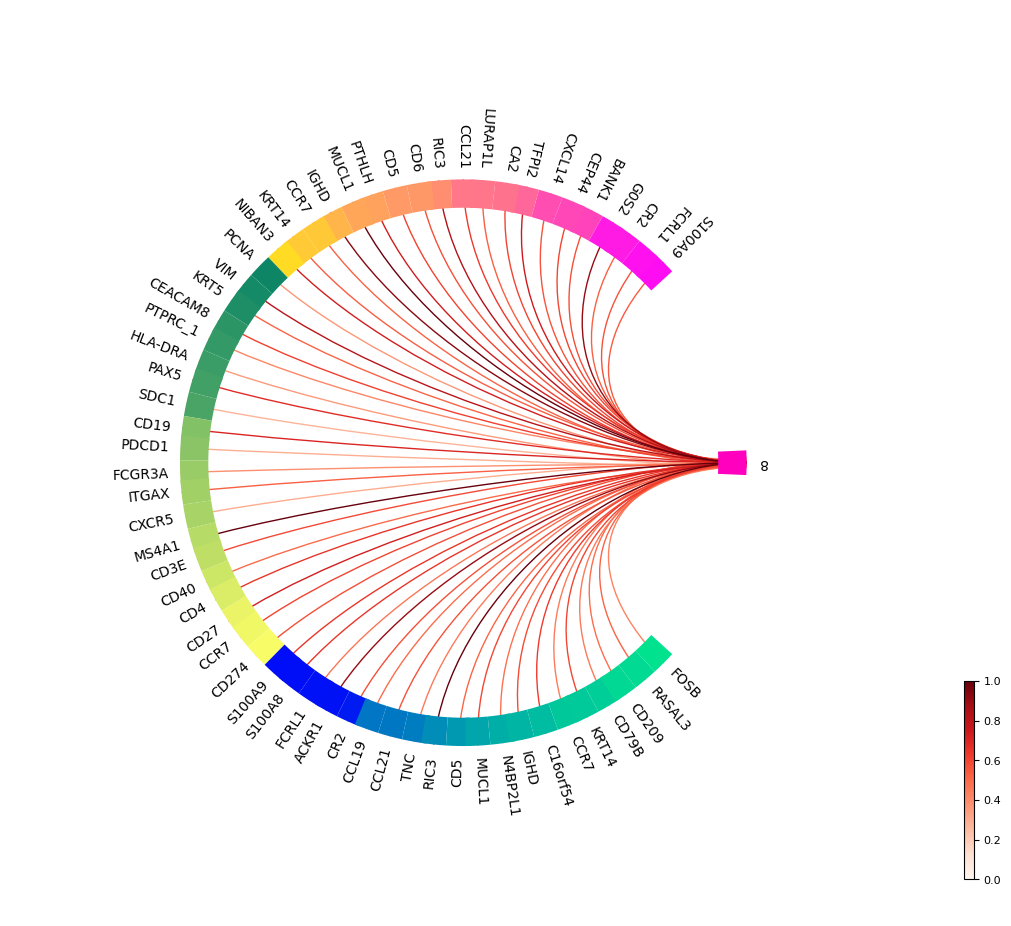

In [18]:
# all_less_type = np.unique(p_l_less)
# if "predicted_label_colors" not in adata_fused.uns.keys():
#     sc.pl.umap(
#         adata_fused,
#         color=["predicted_label"],
#         palette="gist_rainbow",
#         show=False,
#         title="",
#     )

# colors_type = dict(
#     zip(
#         adata_fused.obs["predicted_label"].cat.categories,
#         adata_fused.uns["predicted_label_colors"],
#     )
# )

# top_k_important = 20
# all_type_features, scores, aggregated_shap = type_relevance_chord_plot(
#     shap_values,   ###### this is connecting this code chunk with the previous part!!!!!!!!
#     p_fe,
#     p_fe_idx,
#     p_l_less,
#     predict_label,
#     colors_type,
#     all_less_type,
#     f"{technique}",
#     pr_ty_dict,
#     thres=top_k_important,
#     only_show_good=True,
#     linewidth=1,
#     linecolormap="Reds",
#     node_width=5,
#     make_plot=True,
#     fontsize_names=10,
#     potential_coloarmaps=["spring", "summer", "winter", "autumn"],
# )

In [20]:
# with open("all_type_features.pkl", "wb") as f:
#     pickle.dump(all_type_features, f)

# with open("scores.pkl", "wb") as f:
#     pickle.dump(scores, f)

# with open("aggregated_shap.pkl", "wb") as f:
#     pickle.dump(aggregated_shap, f)

In [ ]:
with open("all_type_features.pkl", "rb") as f:
        all_type_features = pickle.load(f)

with open("scores.pkl", "rb") as f:
        scores = pickle.load(f)

with open("aggregated_shap.pkl", "rb") as f:
        aggregated_shap = pickle.load(f)

In [28]:
# Loop through each cluster

id2modality = {0: 'RNA', 1: 'Protein', 2: 'Niche'}
rows = []
for cluster_id, modalities in all_type_features.items():
    for modality_id, features in modalities.items():
        scores_for_modality = scores[cluster_id][modality_id]

        for i, feature in enumerate(features):
            shap_value_index = modality_id * 20 + i
            shap_value = aggregated_shap[cluster_id][shap_value_index]
            rows.append({
                'Cluster': cluster_id,
                'Modality': id2modality[modality_id],
                'Feature': feature,
                'Score': scores_for_modality[i],
                'SHAP Value': shap_value
            })

# Create the DataFrame
df = pd.DataFrame(rows)
print(df)
type_feature_file_path = 'type_feature_importance_pilot2.csv'
if not Path(type_feature_file_path).exists():
    df.to_csv('type_feature_importance_pilot2.csv', index=False)

     Cluster Modality Feature     Score  SHAP Value
0          0      RNA    G0S2  0.633707    0.102400
1          0      RNA   IL1RN  1.000000    0.265603
2          0      RNA    CPB1  0.538877    0.060149
3          0      RNA   CXCL9  0.606358    0.090215
4          0      RNA    SPP1  0.585073    0.080731
..       ...      ...     ...       ...         ...
535        8    Niche   KRT14  0.594585    0.069741
536        8    Niche   CD79B  0.452330    0.011280
537        8    Niche   CD209  0.487658    0.025798
538        8    Niche  RASAL3  0.518465    0.038459
539        8    Niche    FOSB  0.424883    0.000000

[540 rows x 5 columns]


In [29]:
# change names of niche features to not be confused with the naming of the genes
import copy
new_all_type_features = {}
for cluster_id, cluster_features in all_type_features.items():
    new_all_type_features[cluster_id] = copy.deepcopy(cluster_features)
    gene_modality_names = np.array([feature_name + "- G" for feature_name in cluster_features[0]])
    protein_modality_names = np.array([feature_name + "- P" for feature_name in cluster_features[1]])
    niche_modality_names = np.array([feature_name + "- N" for feature_name in cluster_features[2]])
    new_all_type_features[cluster_id] = {0: gene_modality_names, 1: protein_modality_names, 2: niche_modality_names}

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


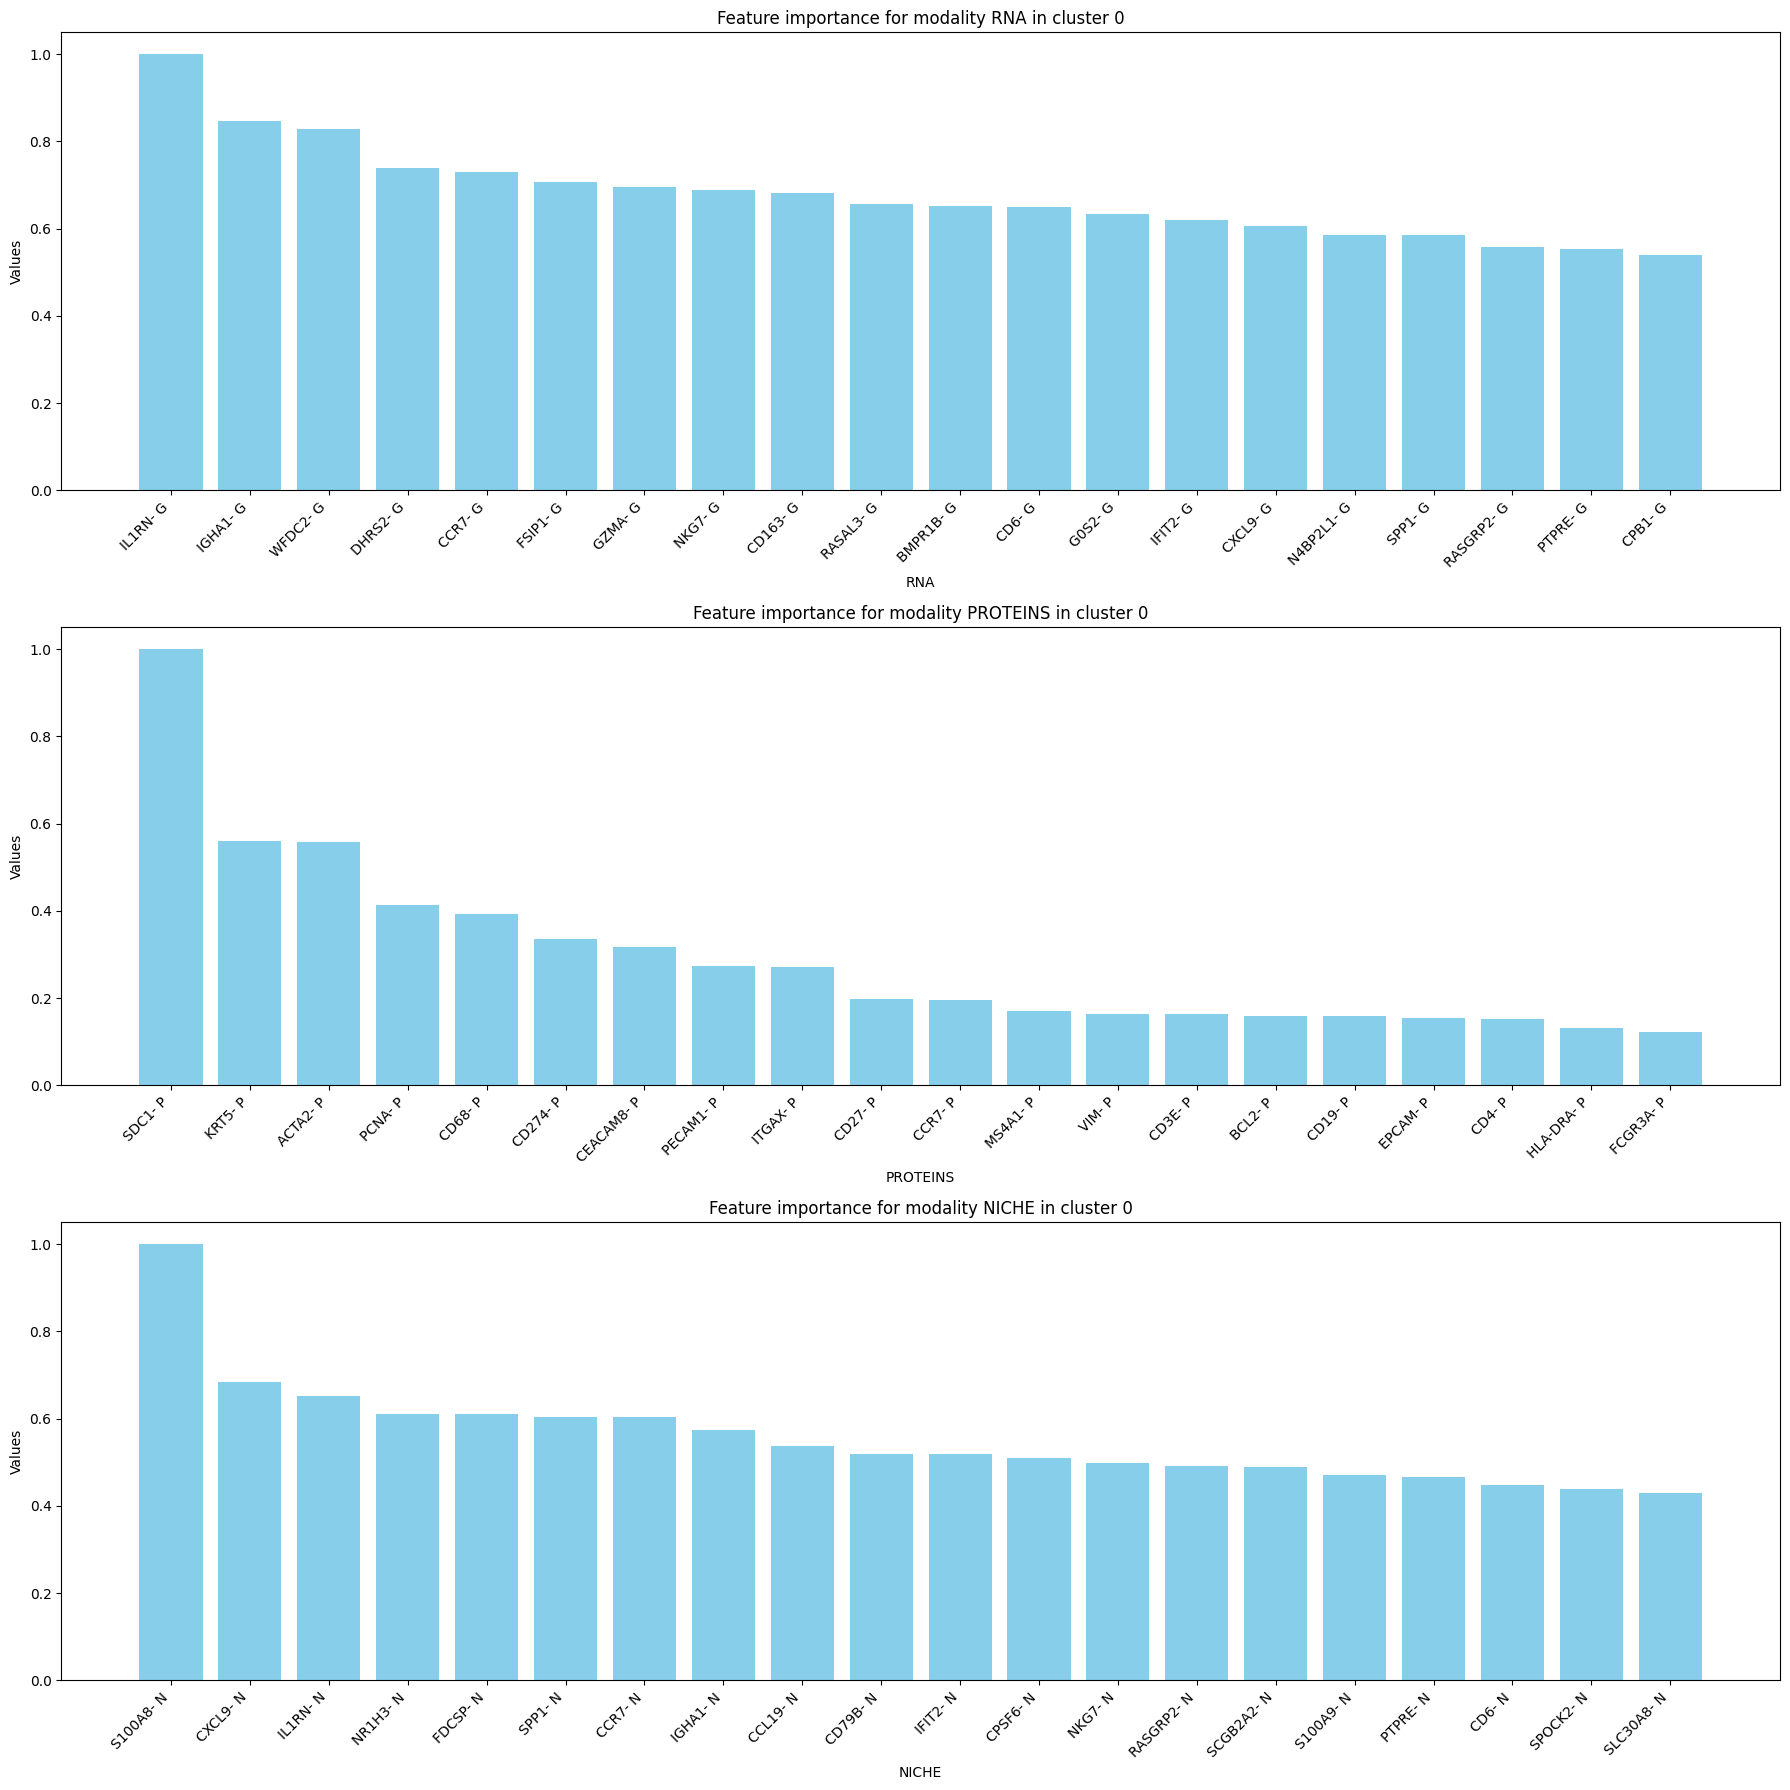

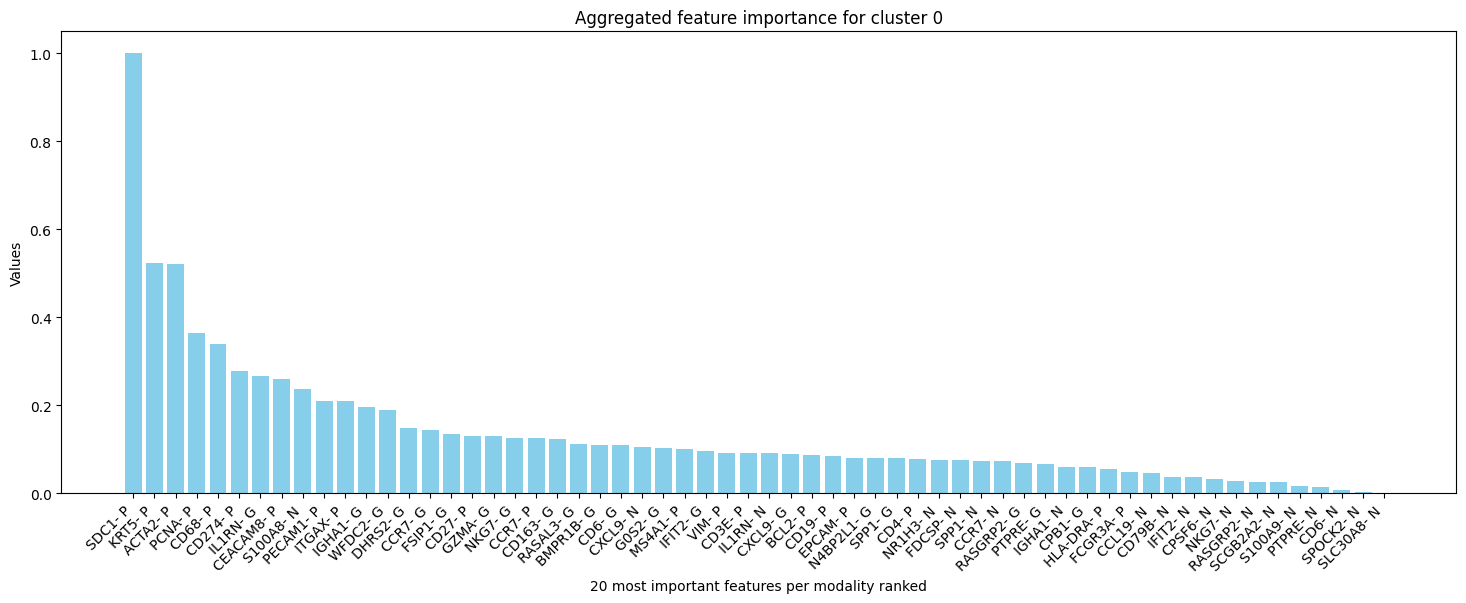

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


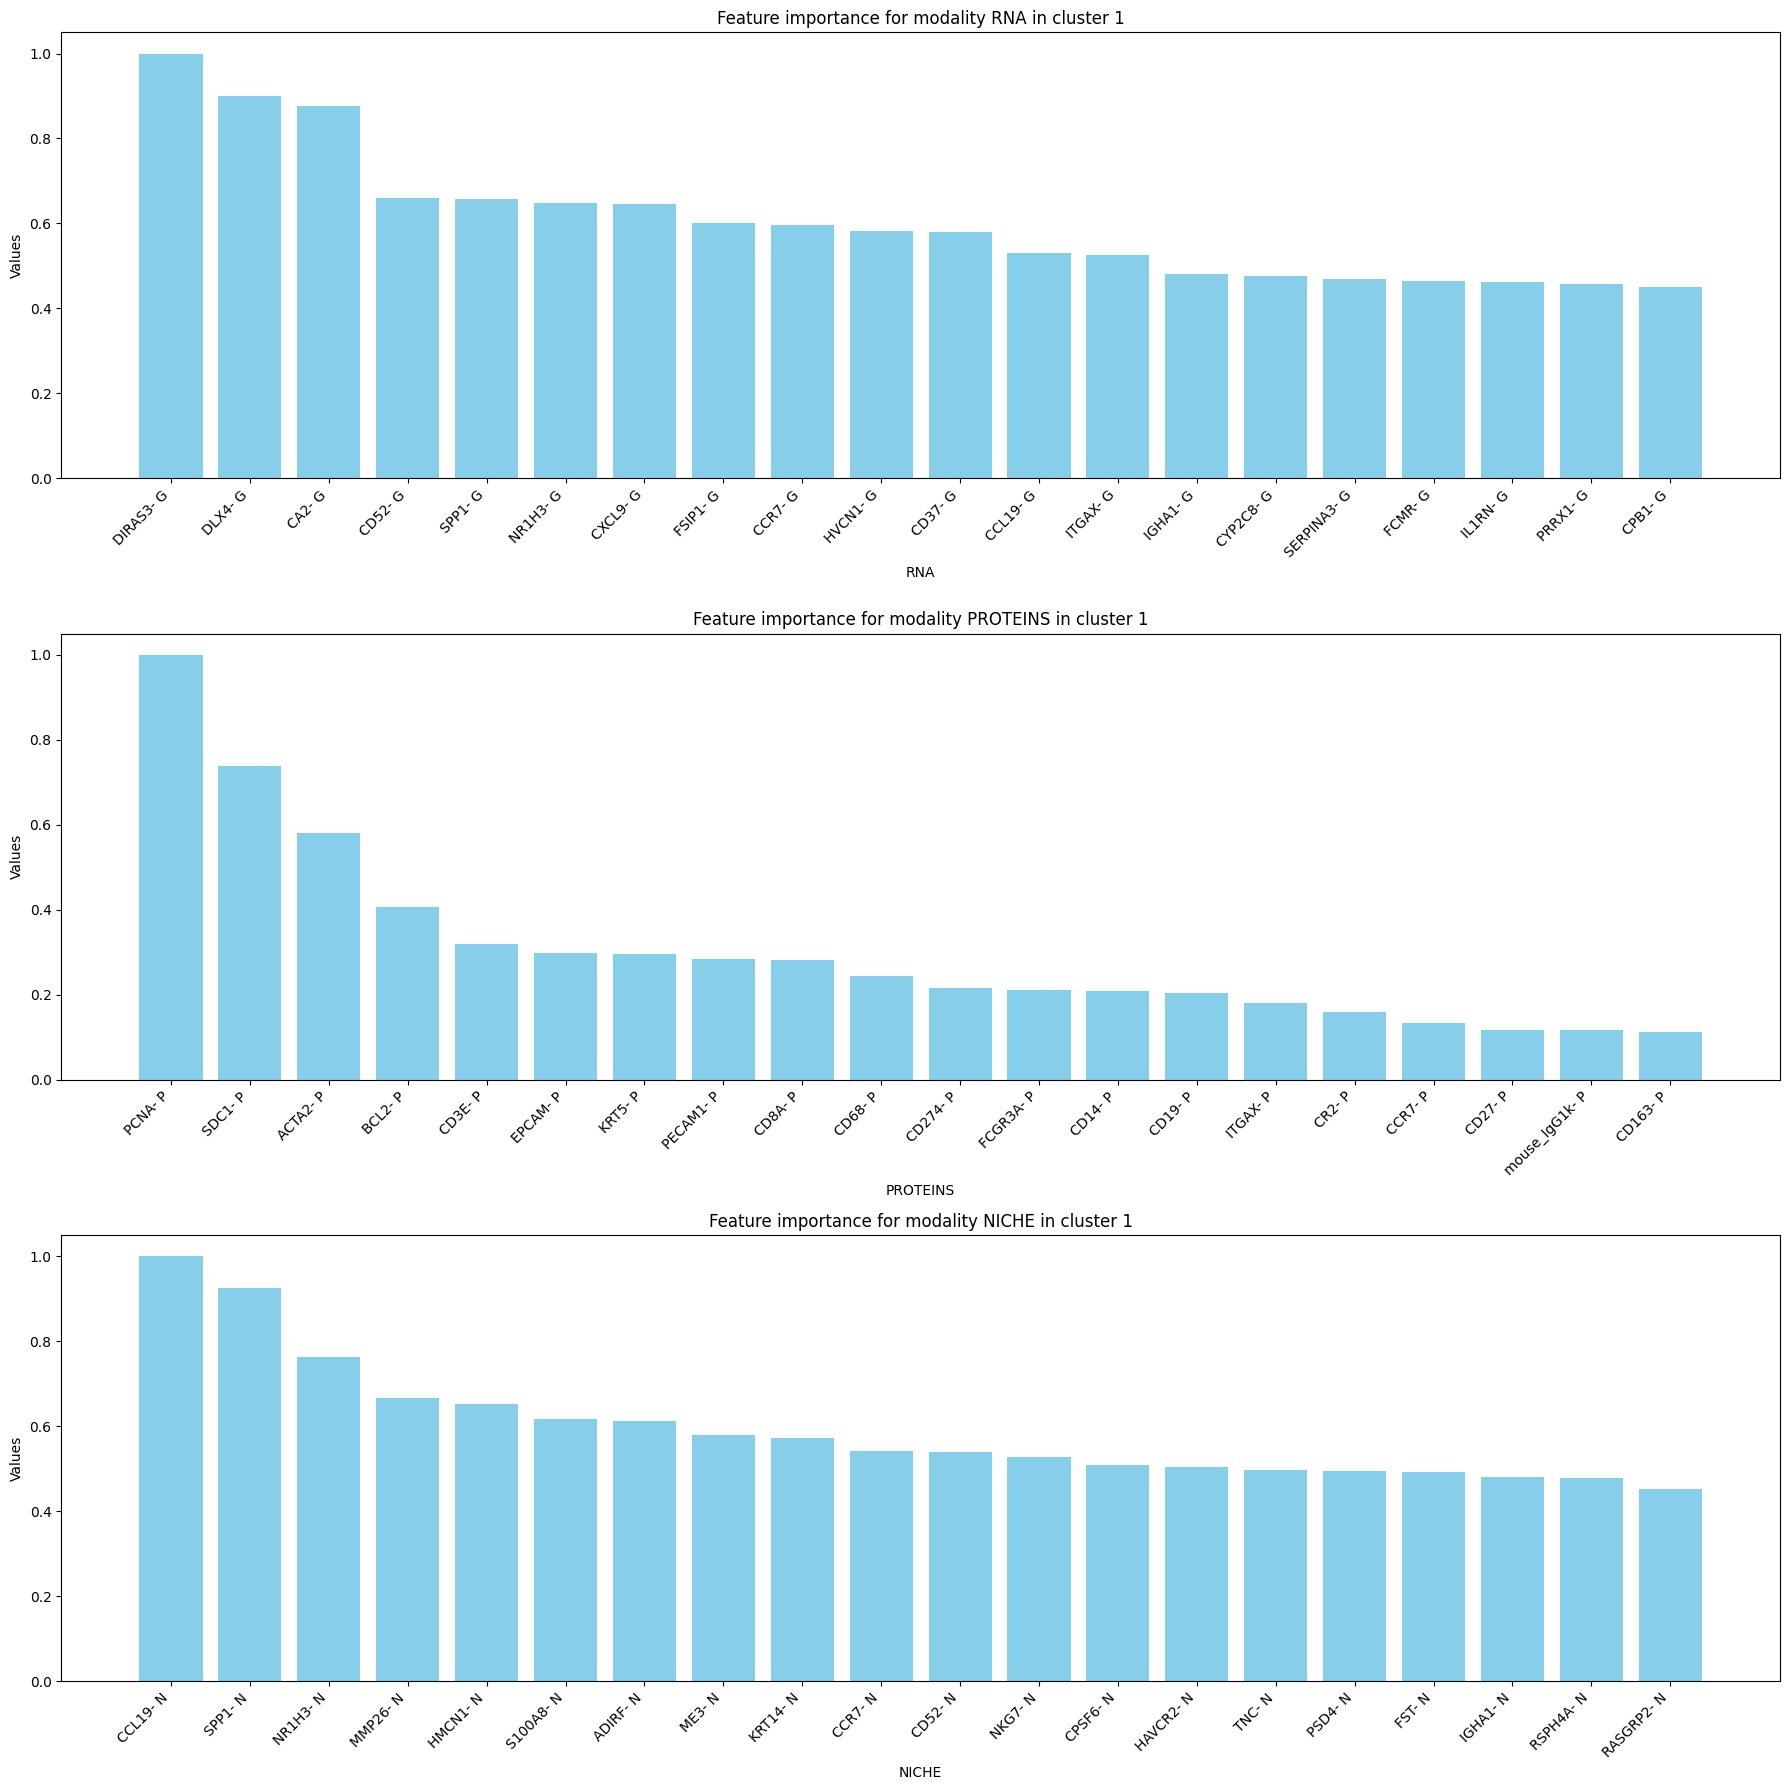

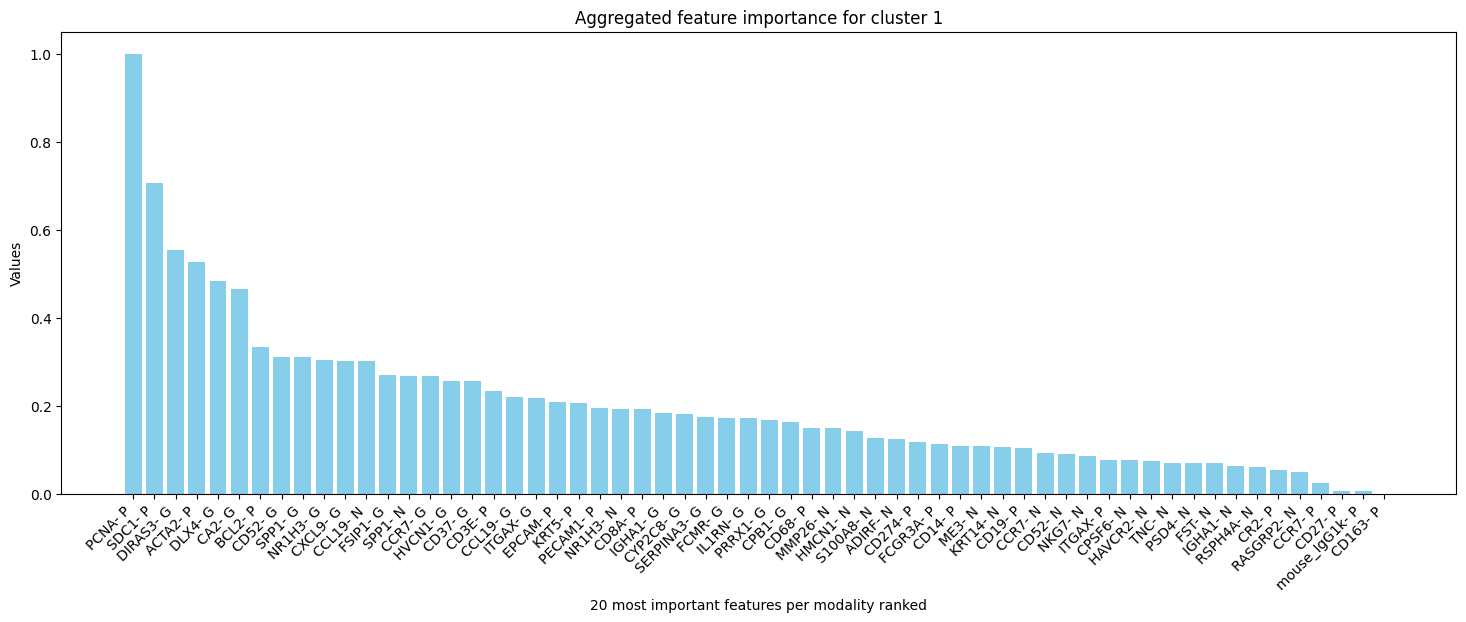

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


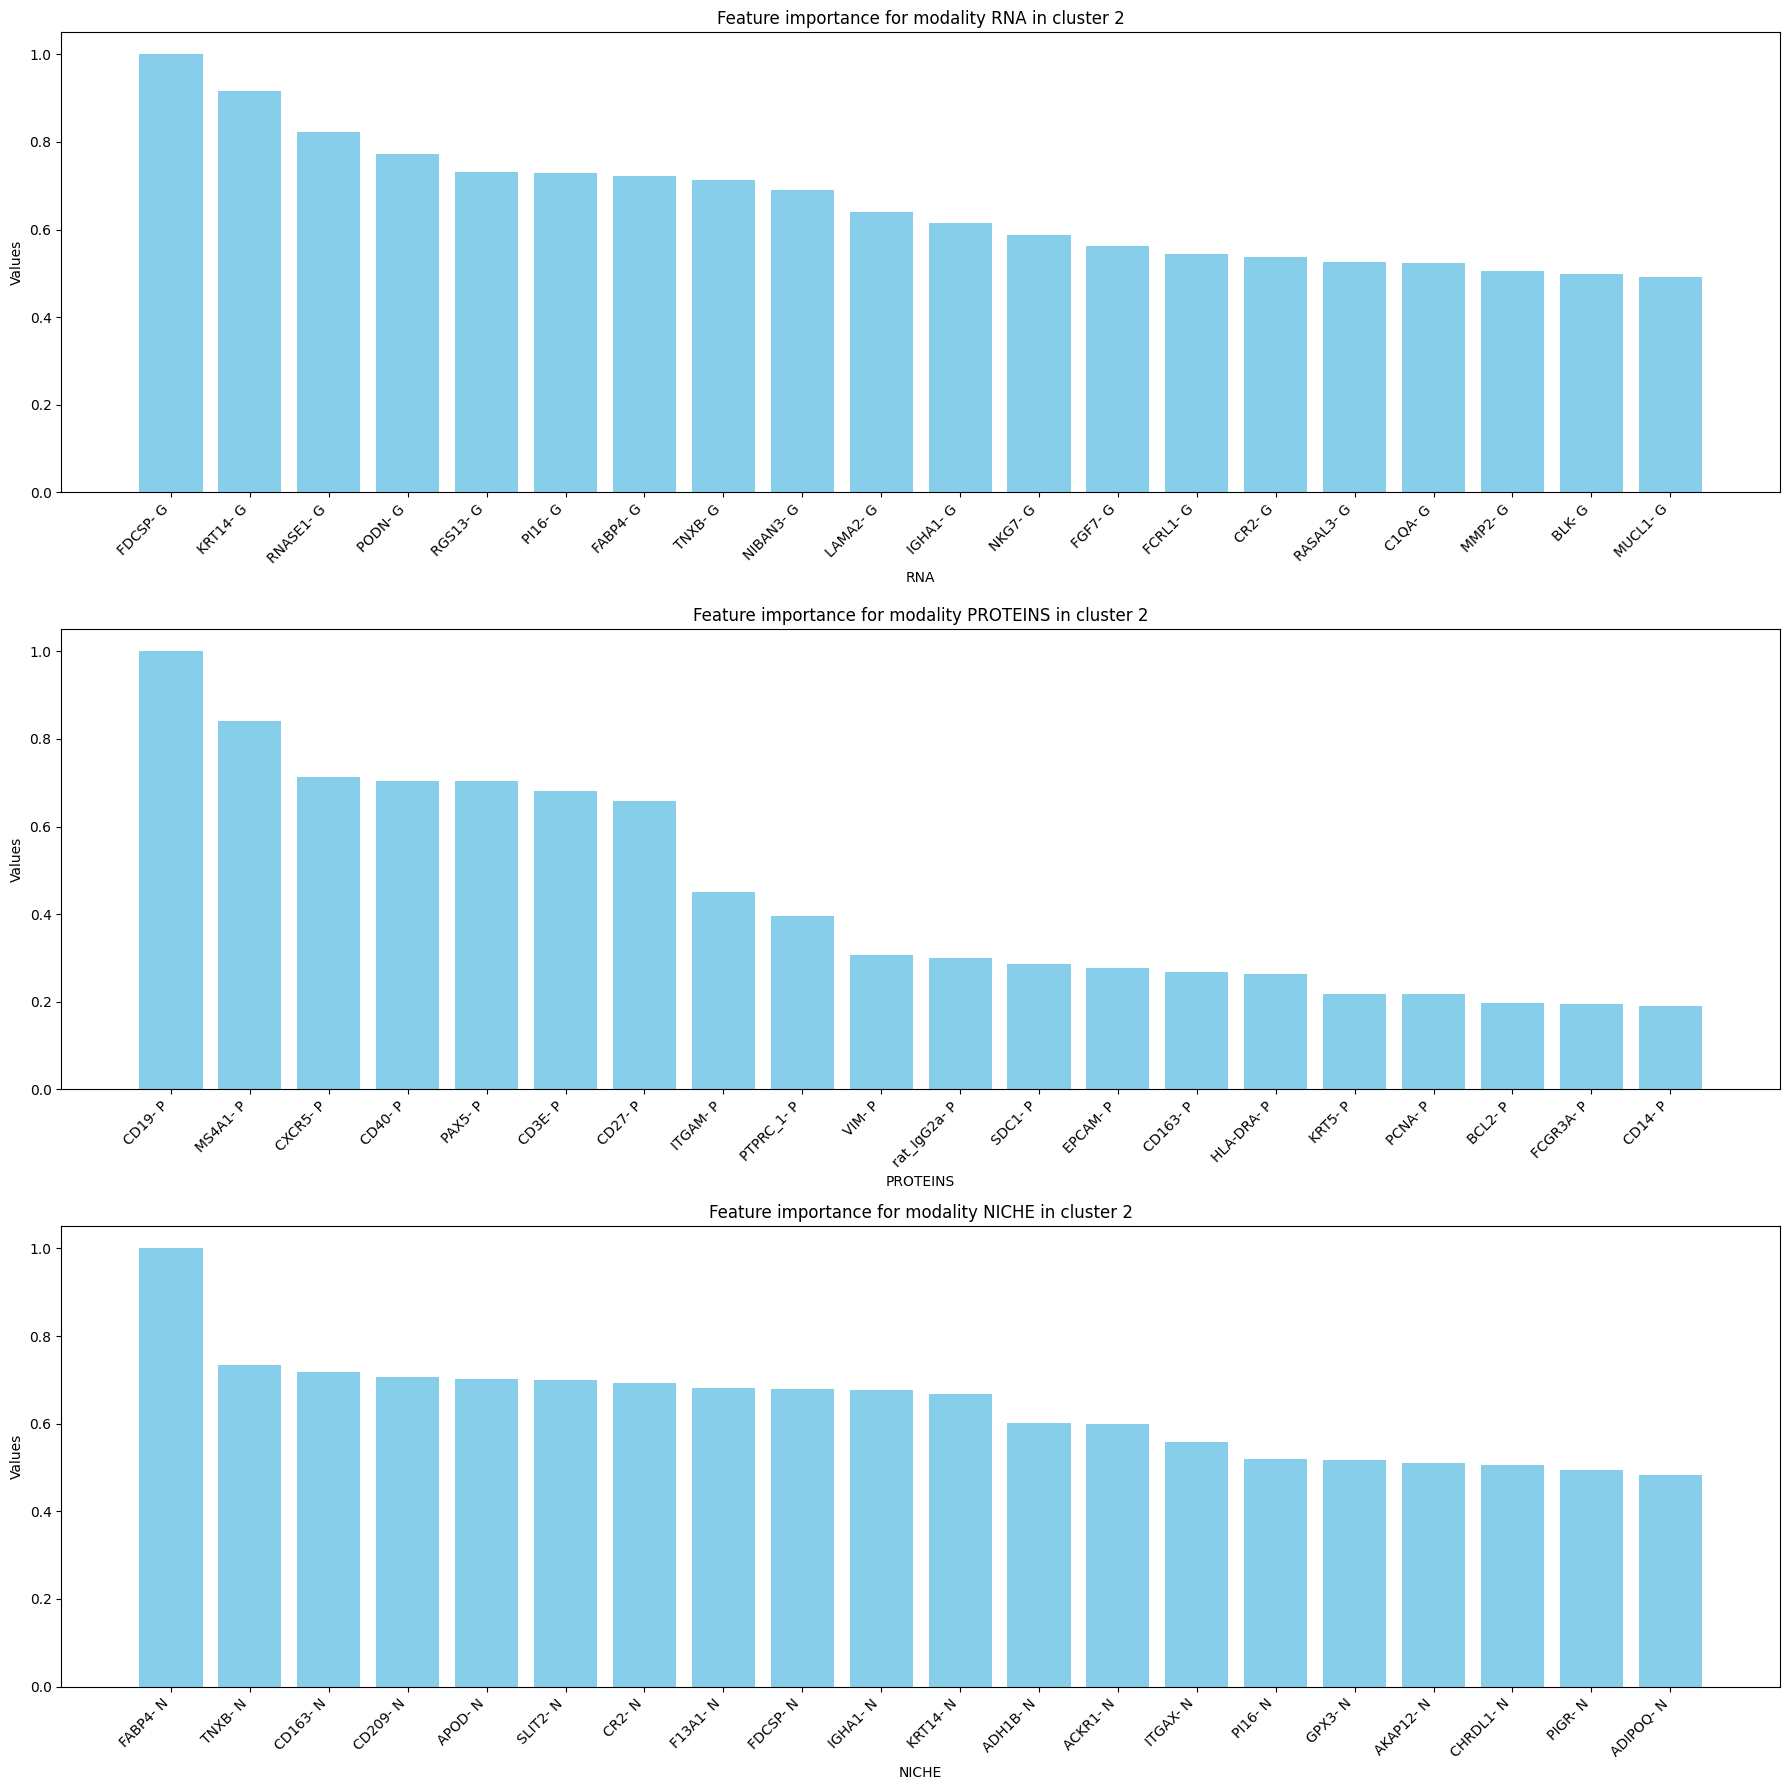

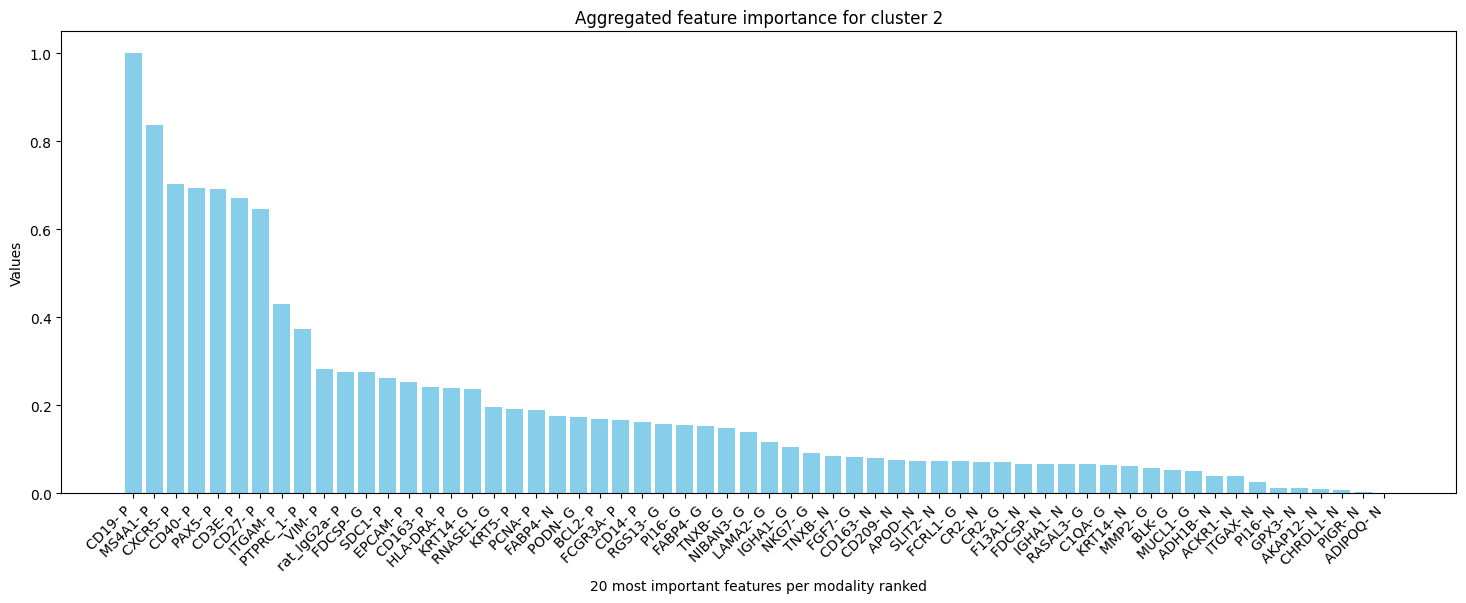

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


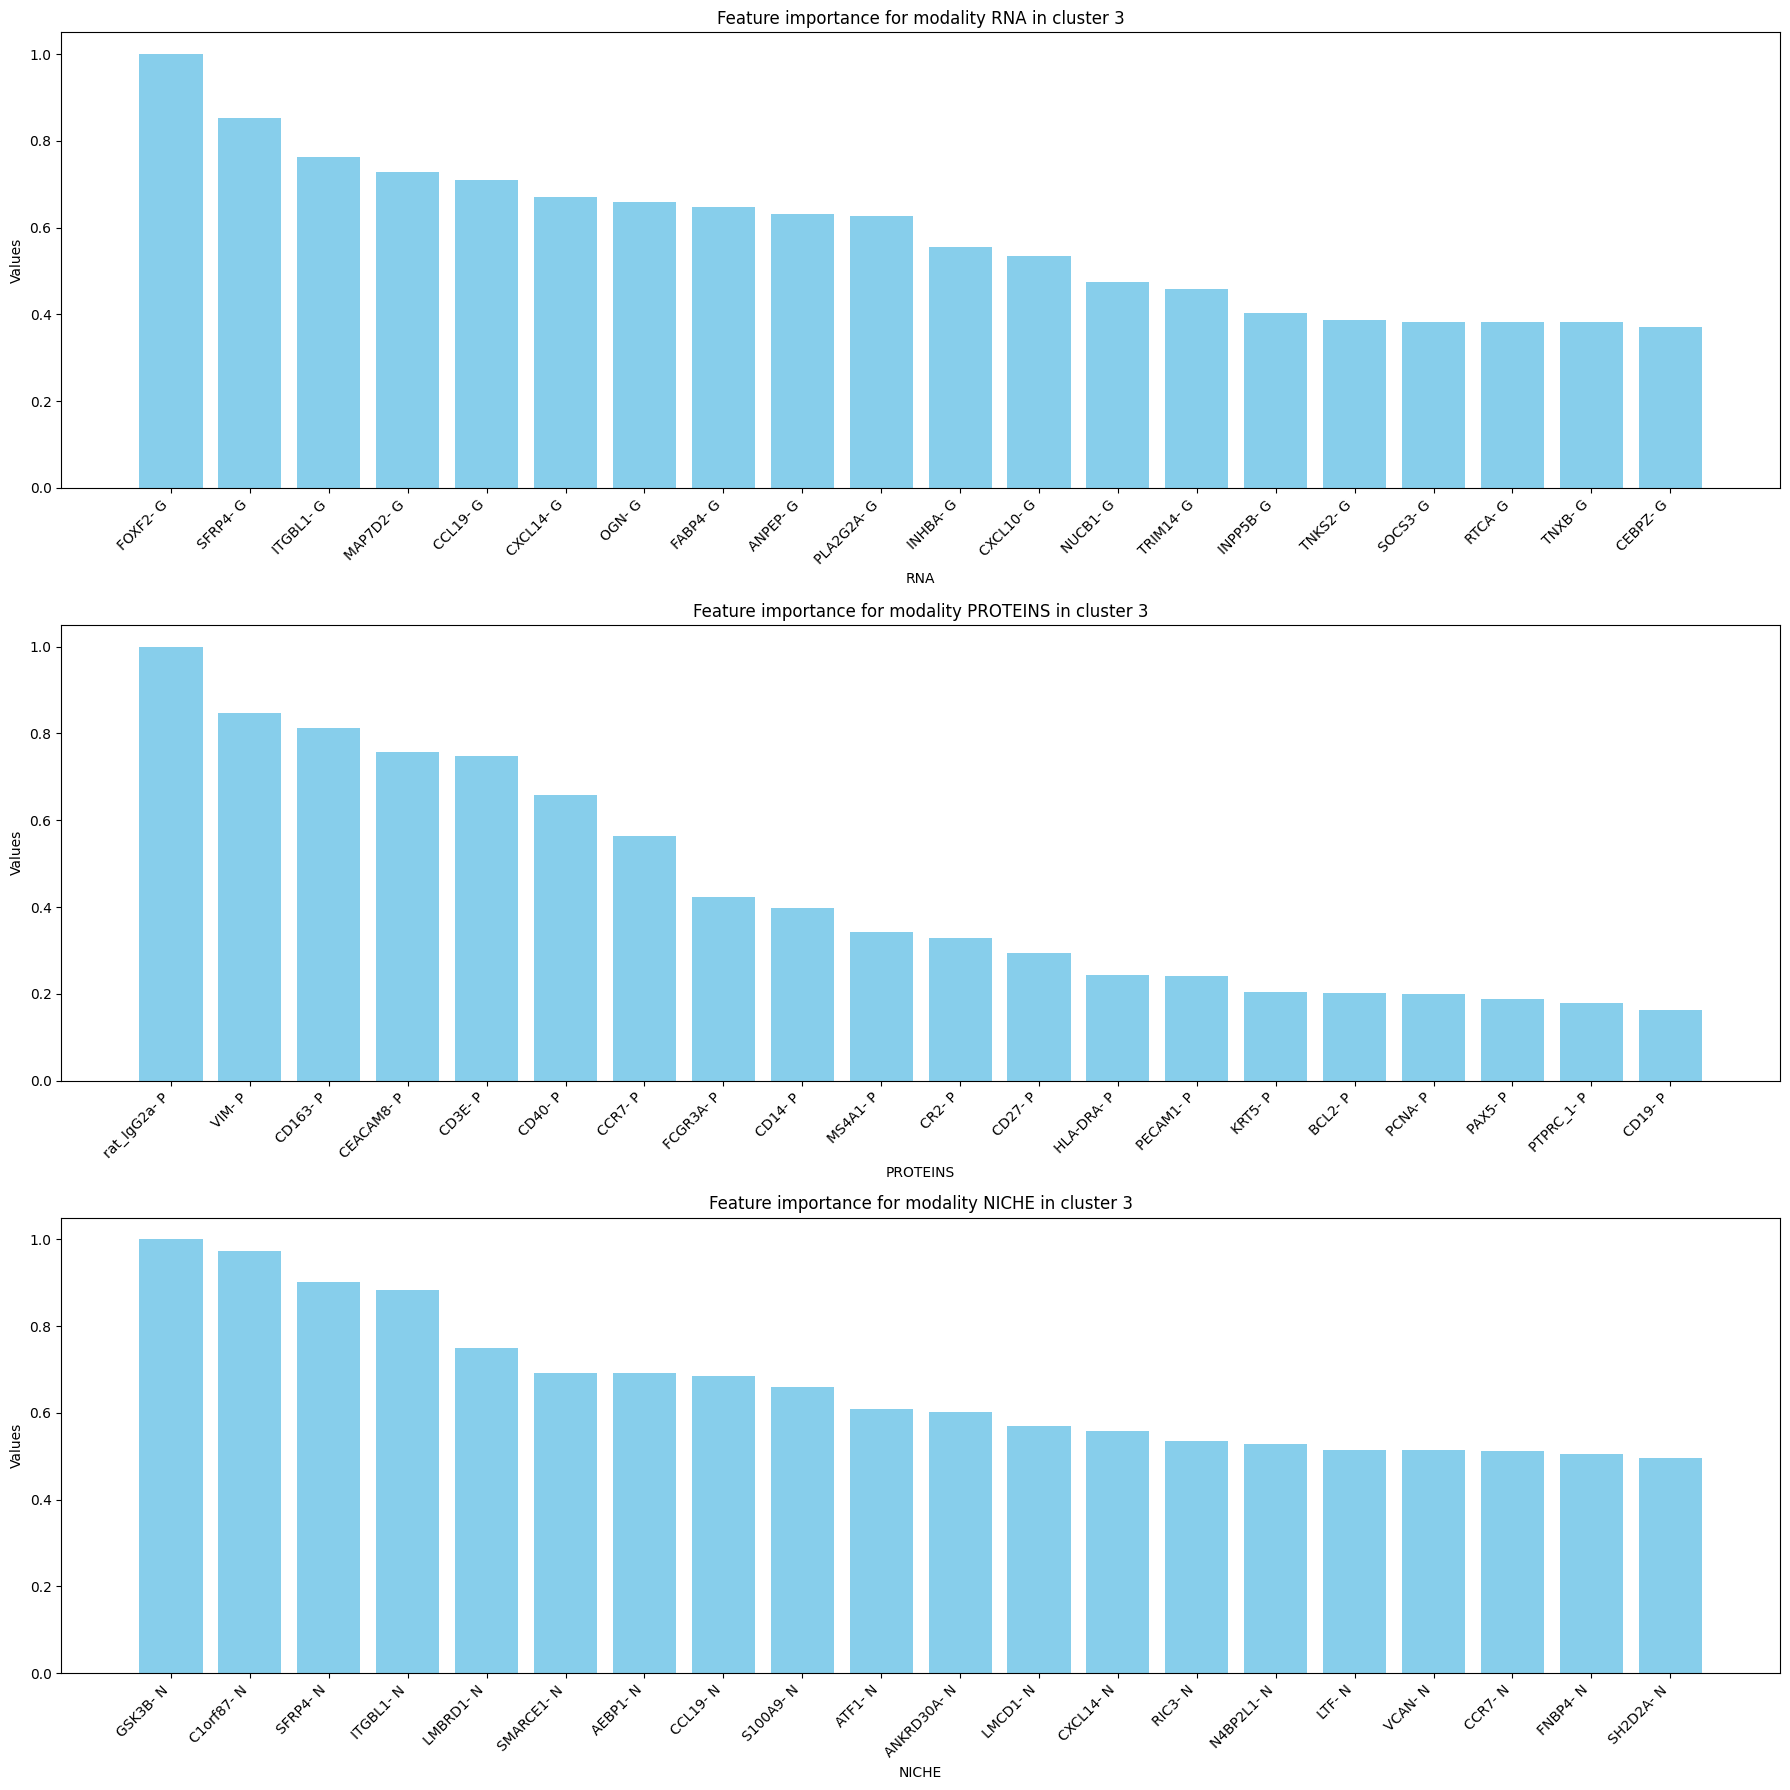

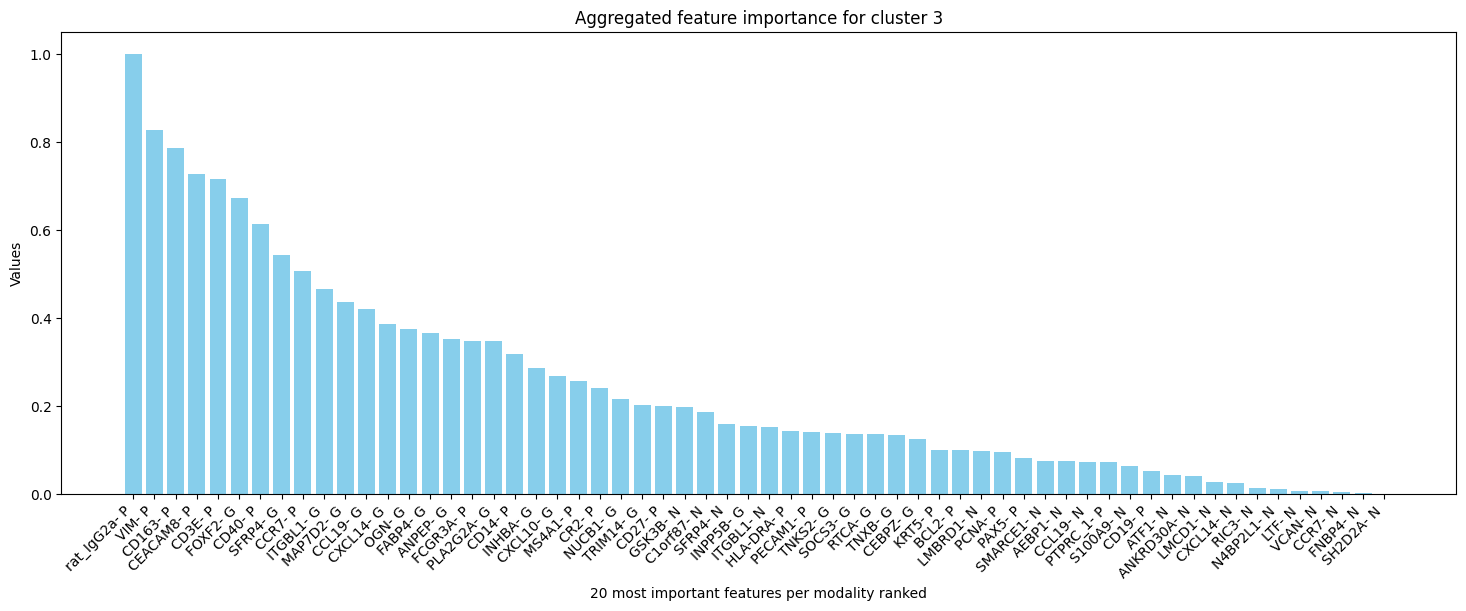

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


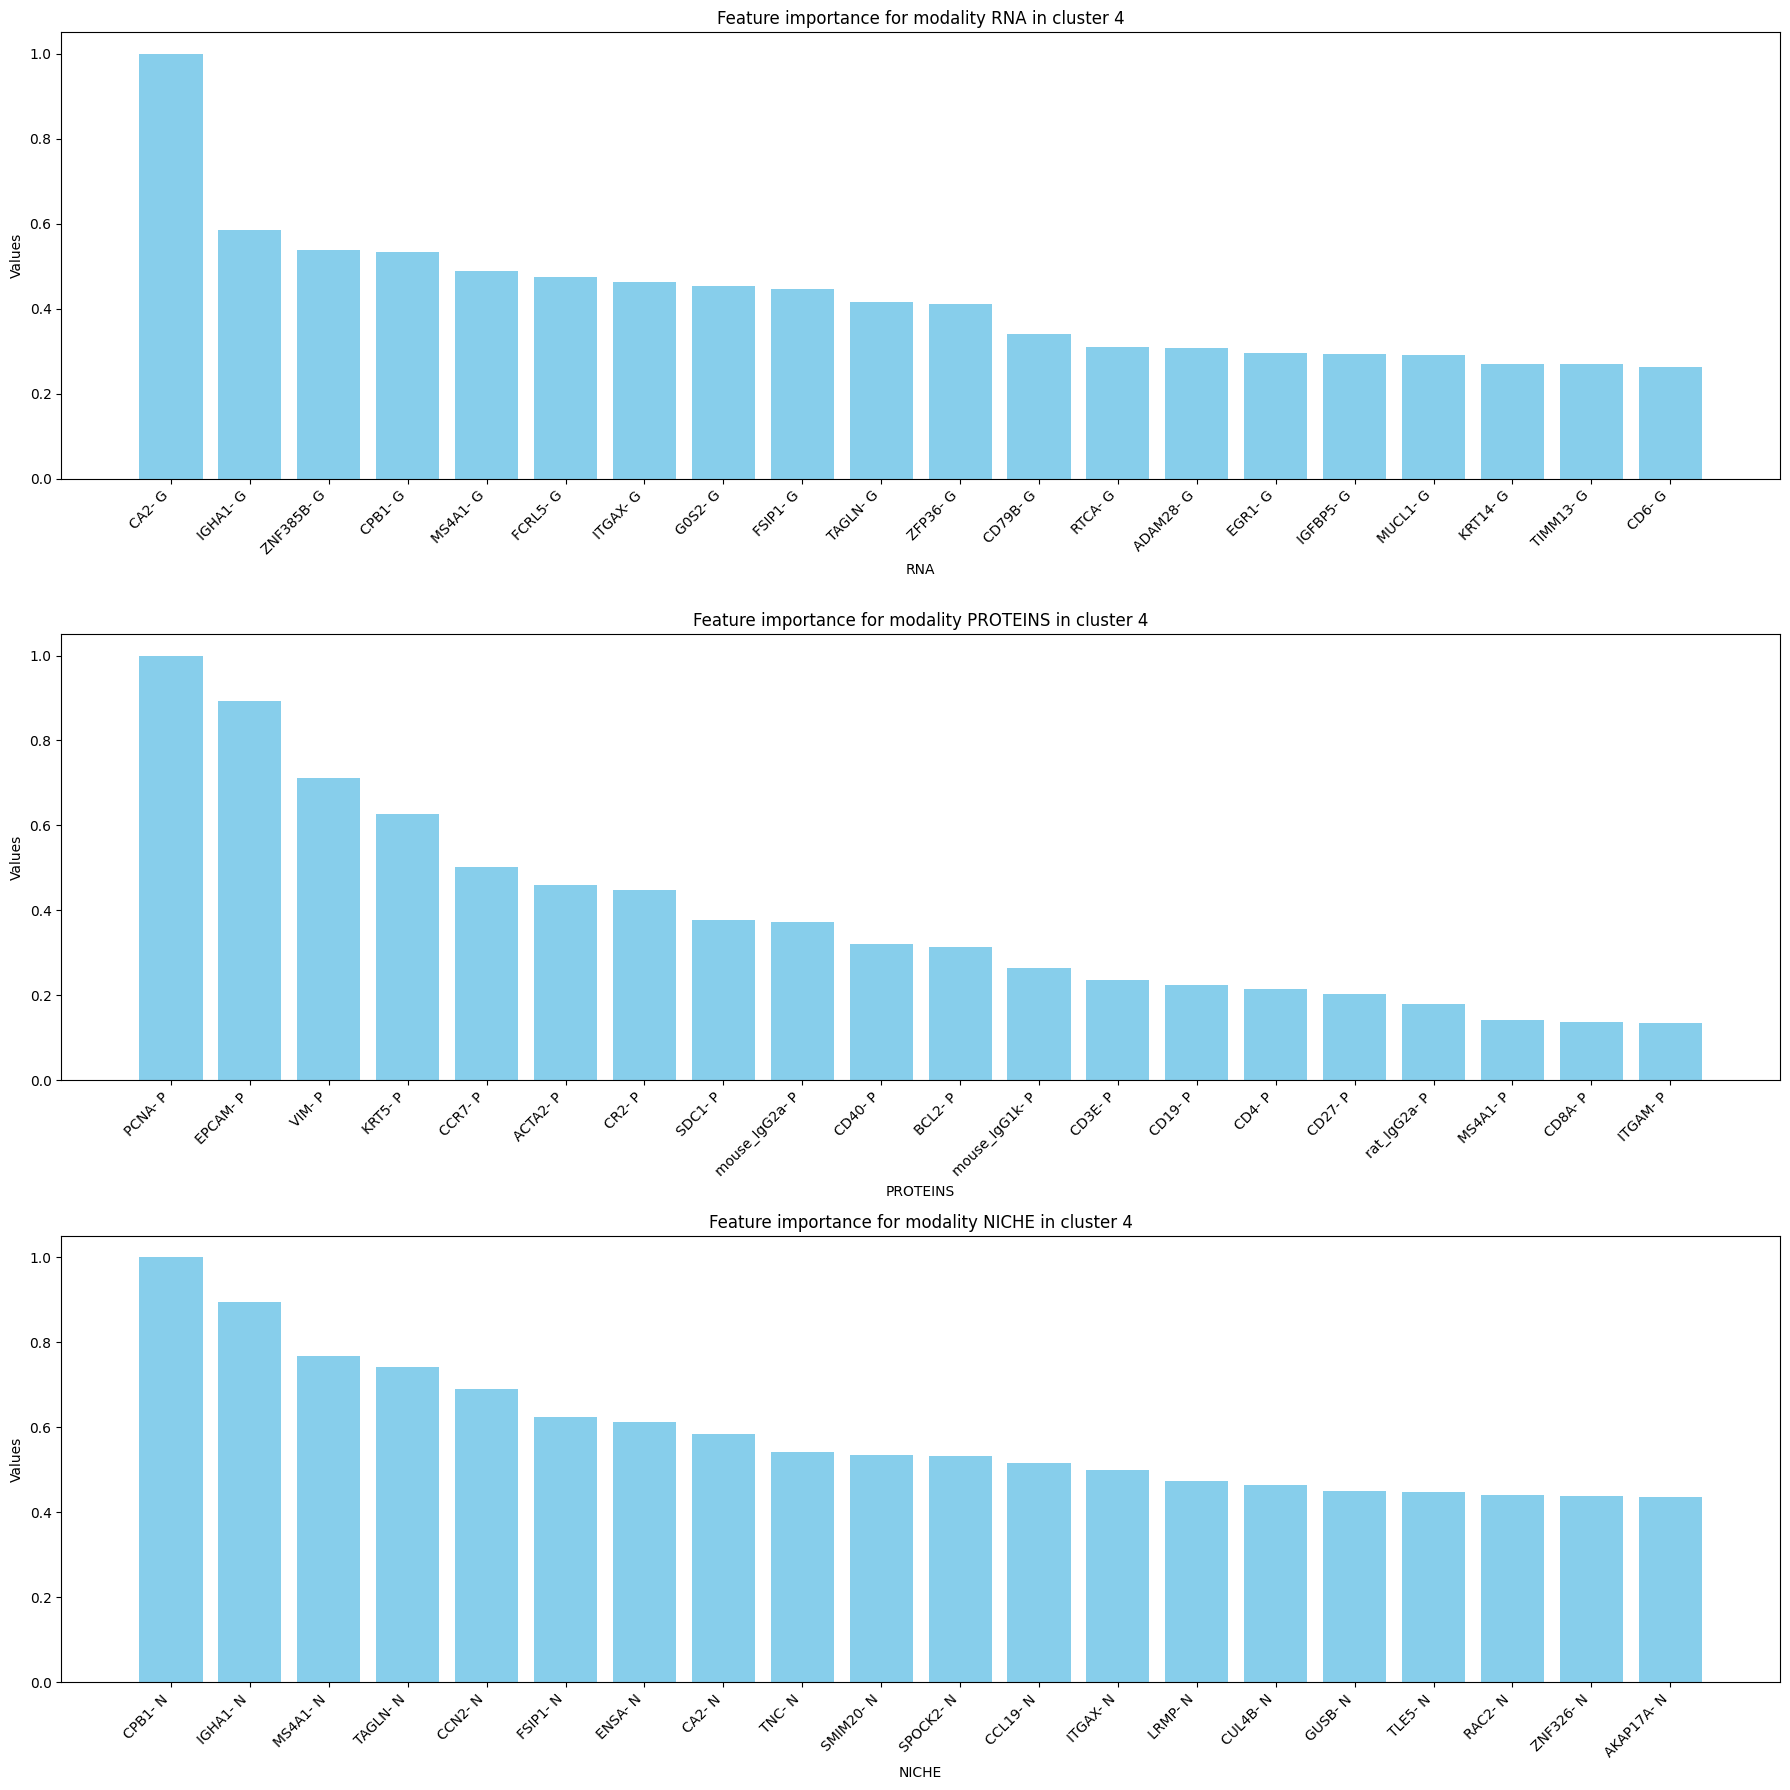

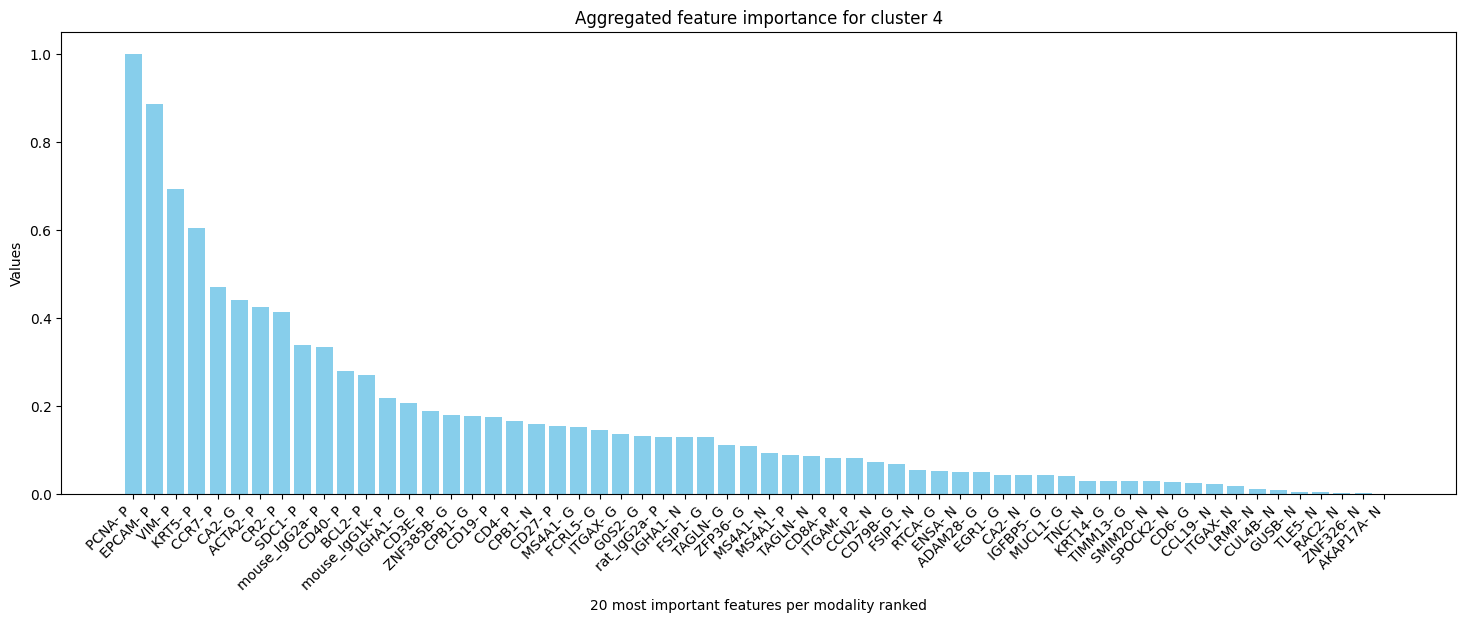

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


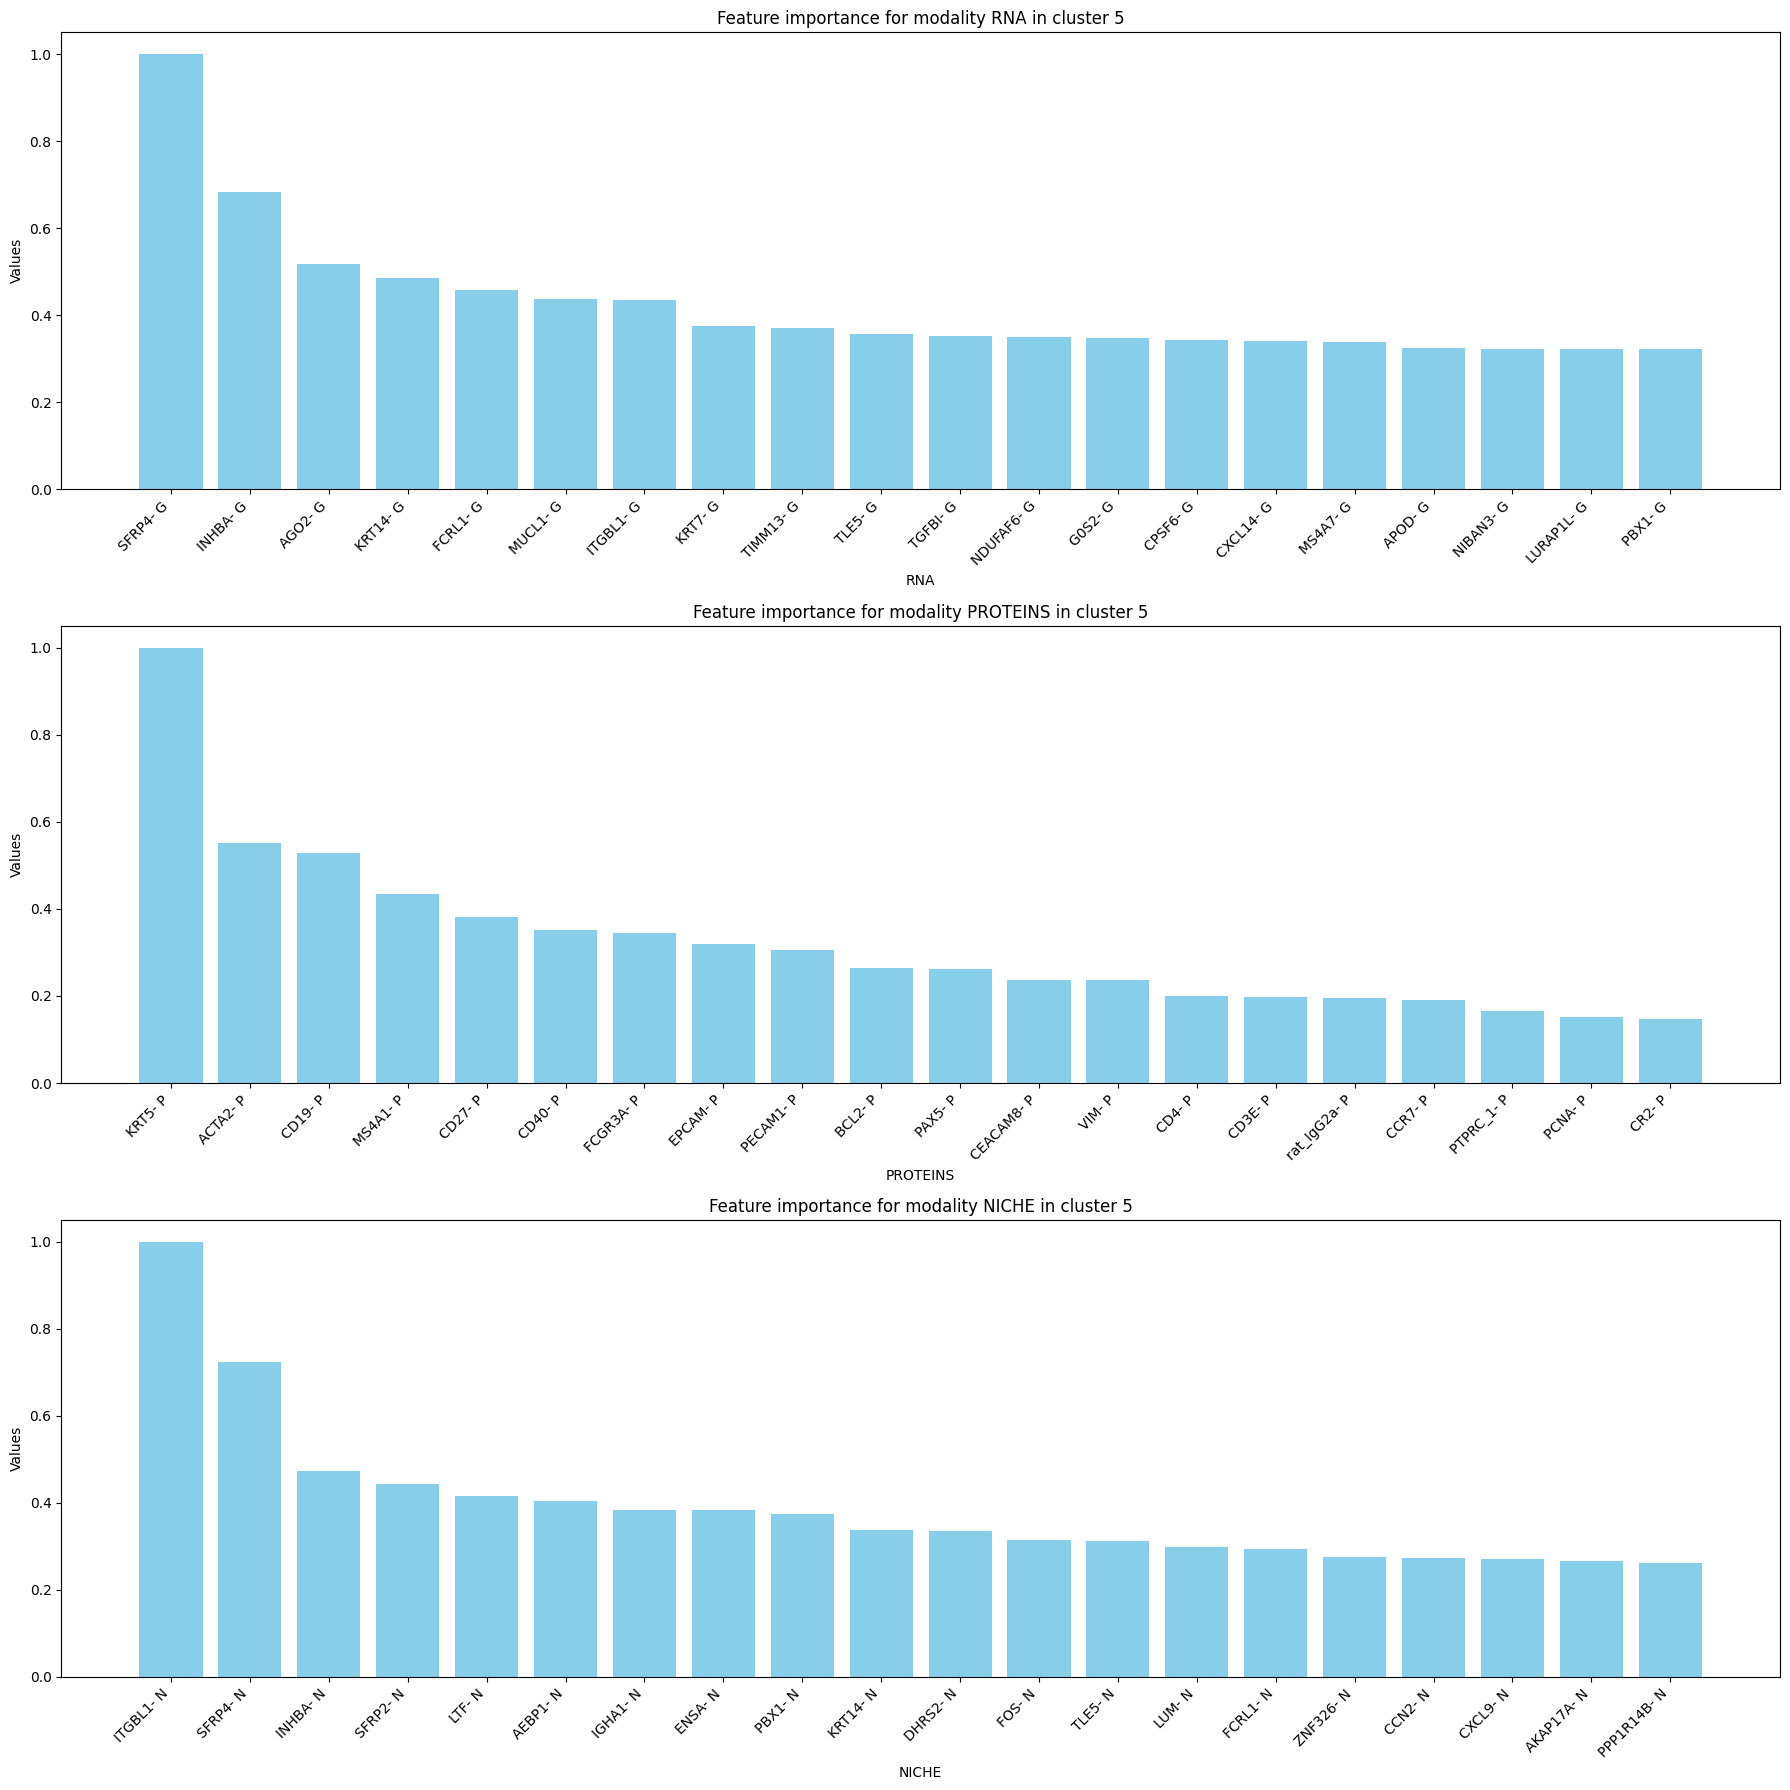

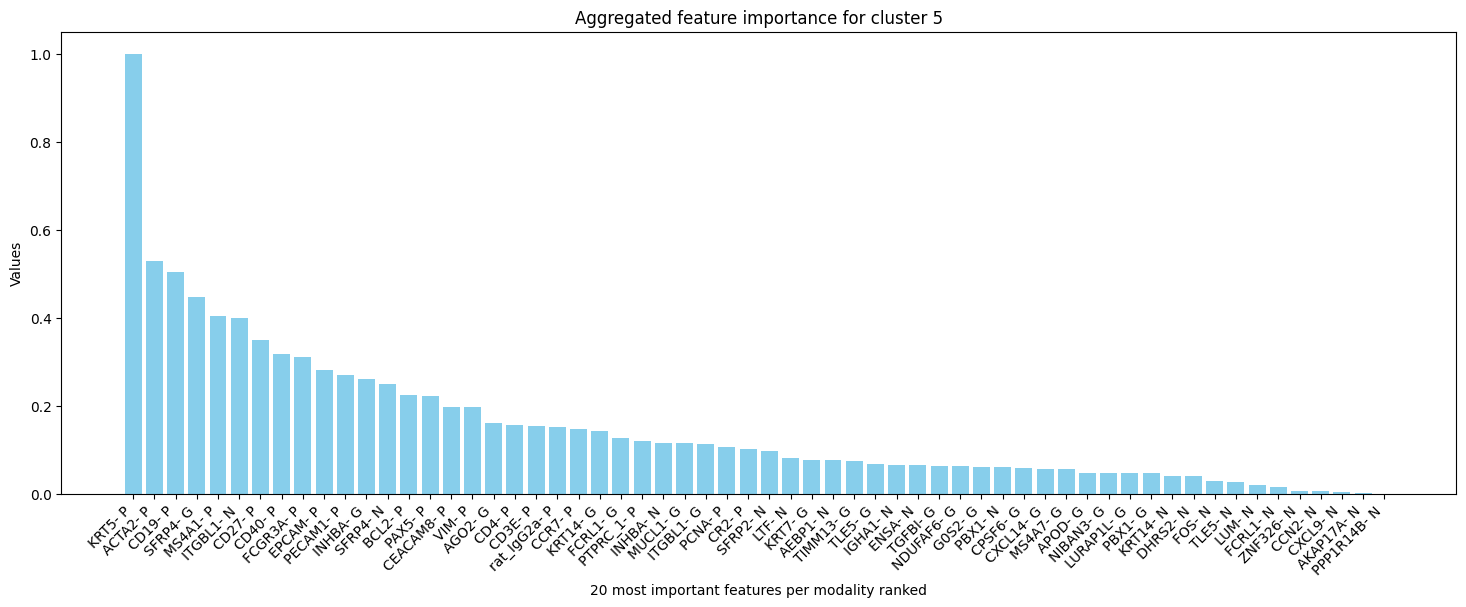

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


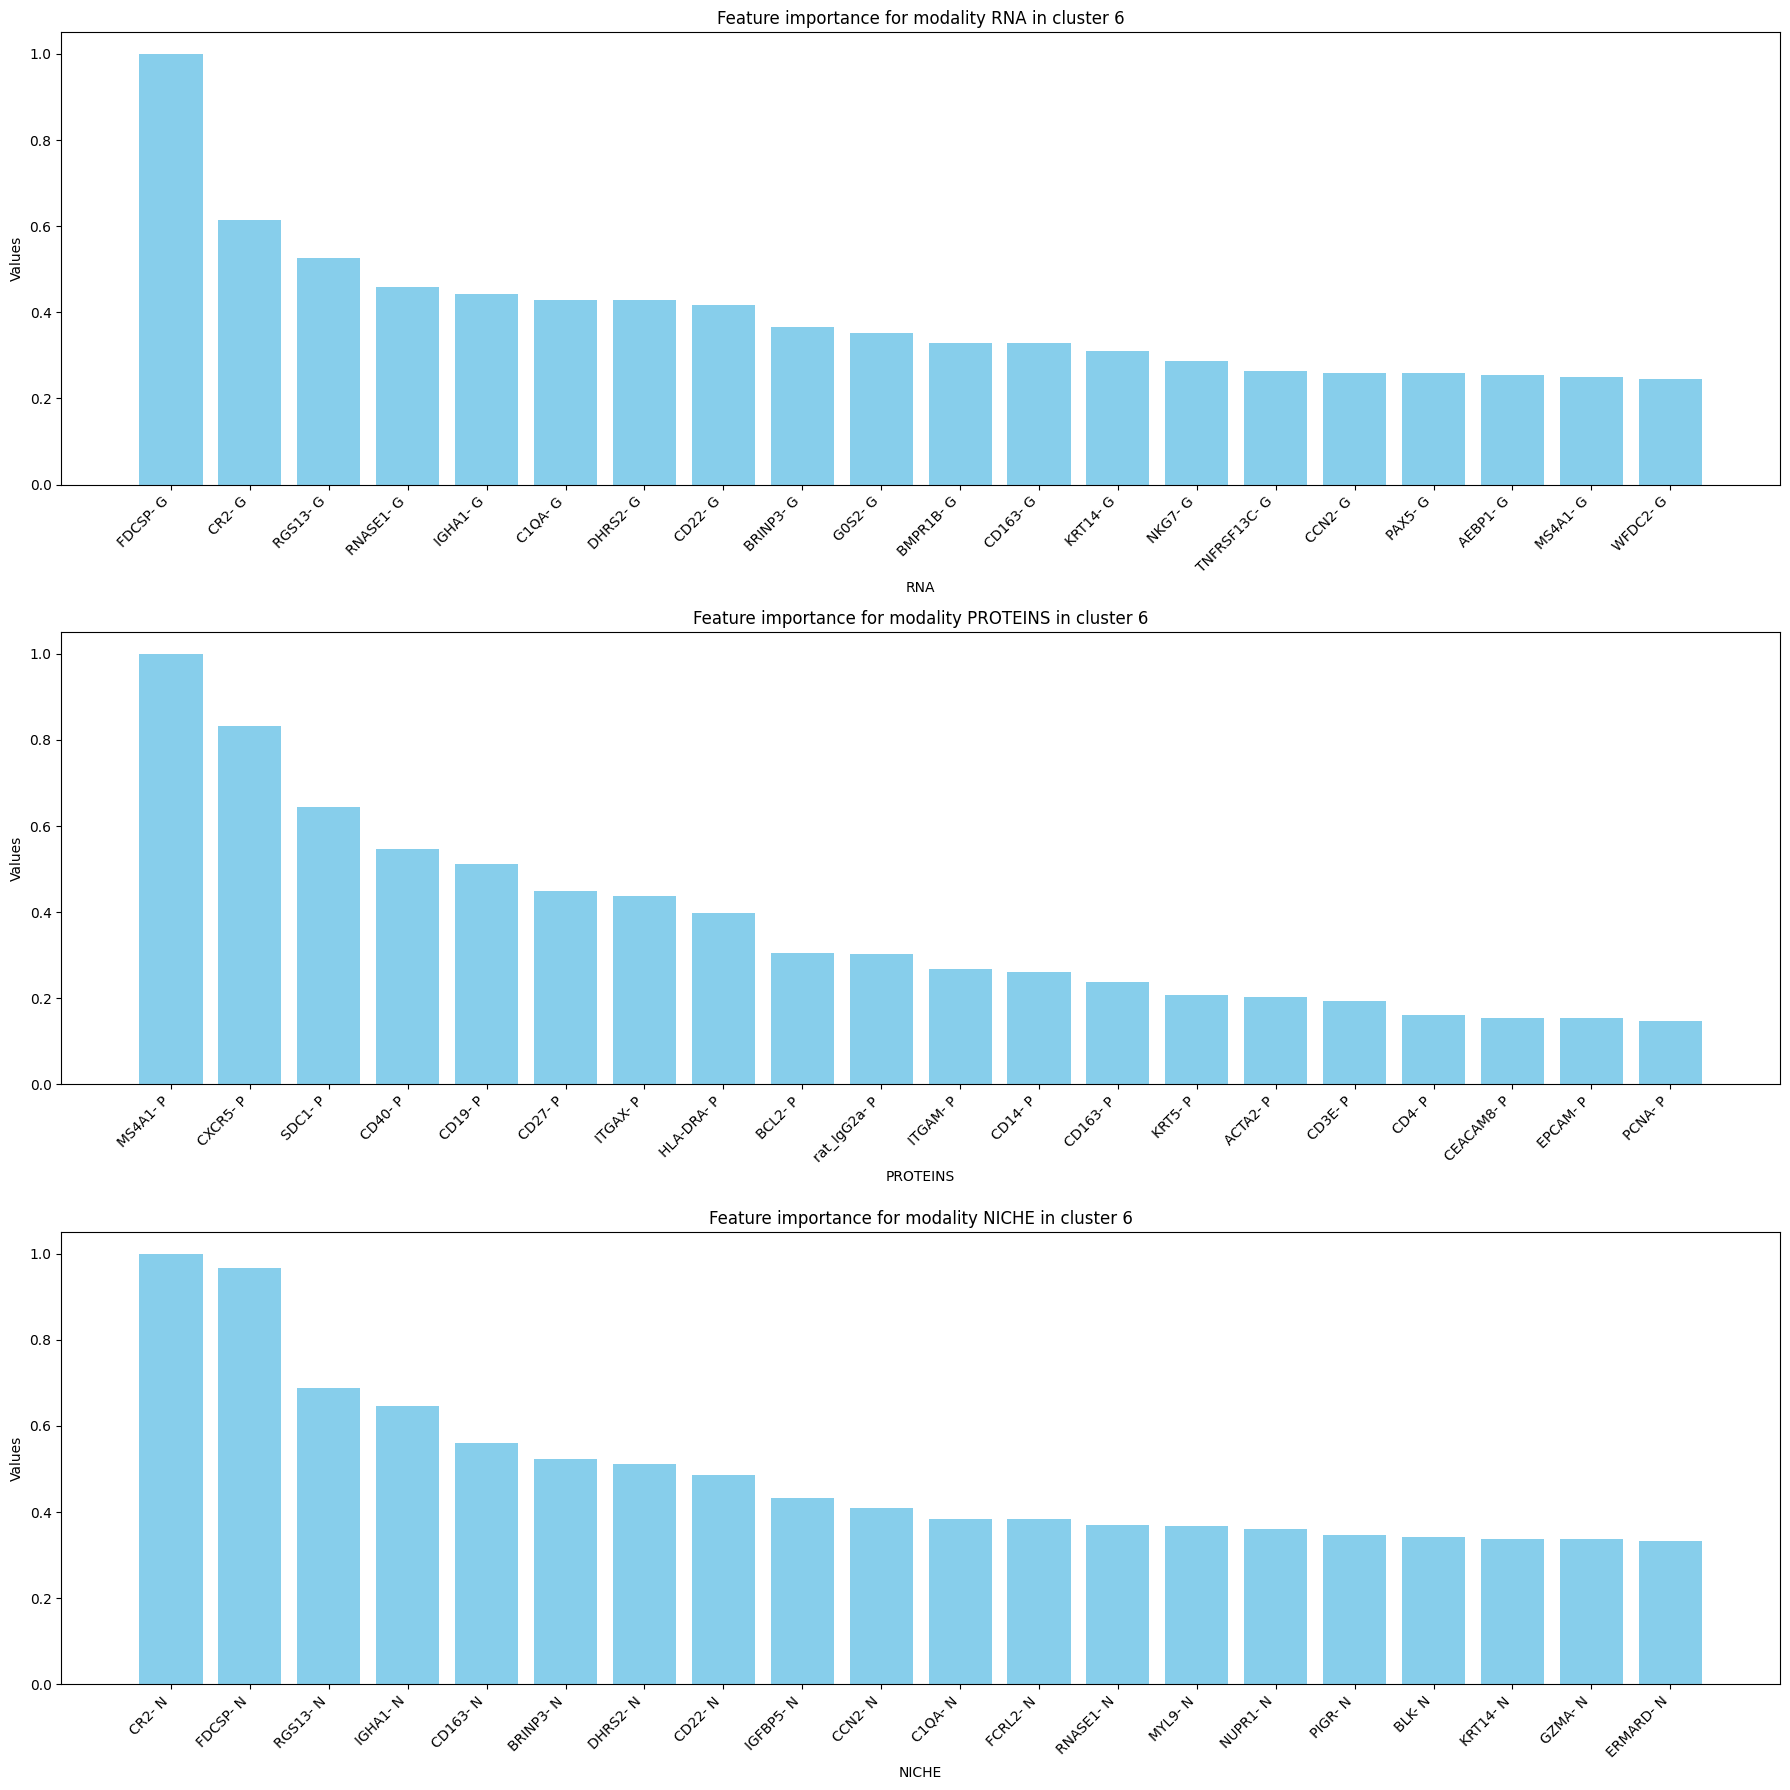

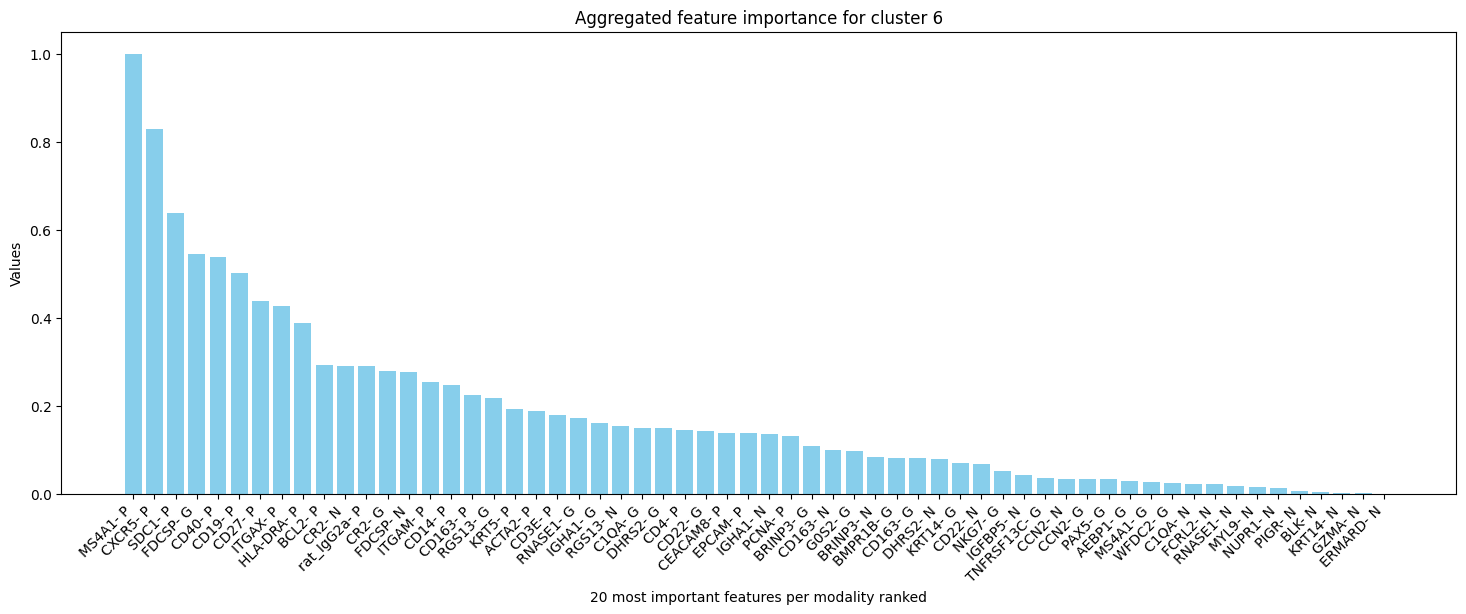

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


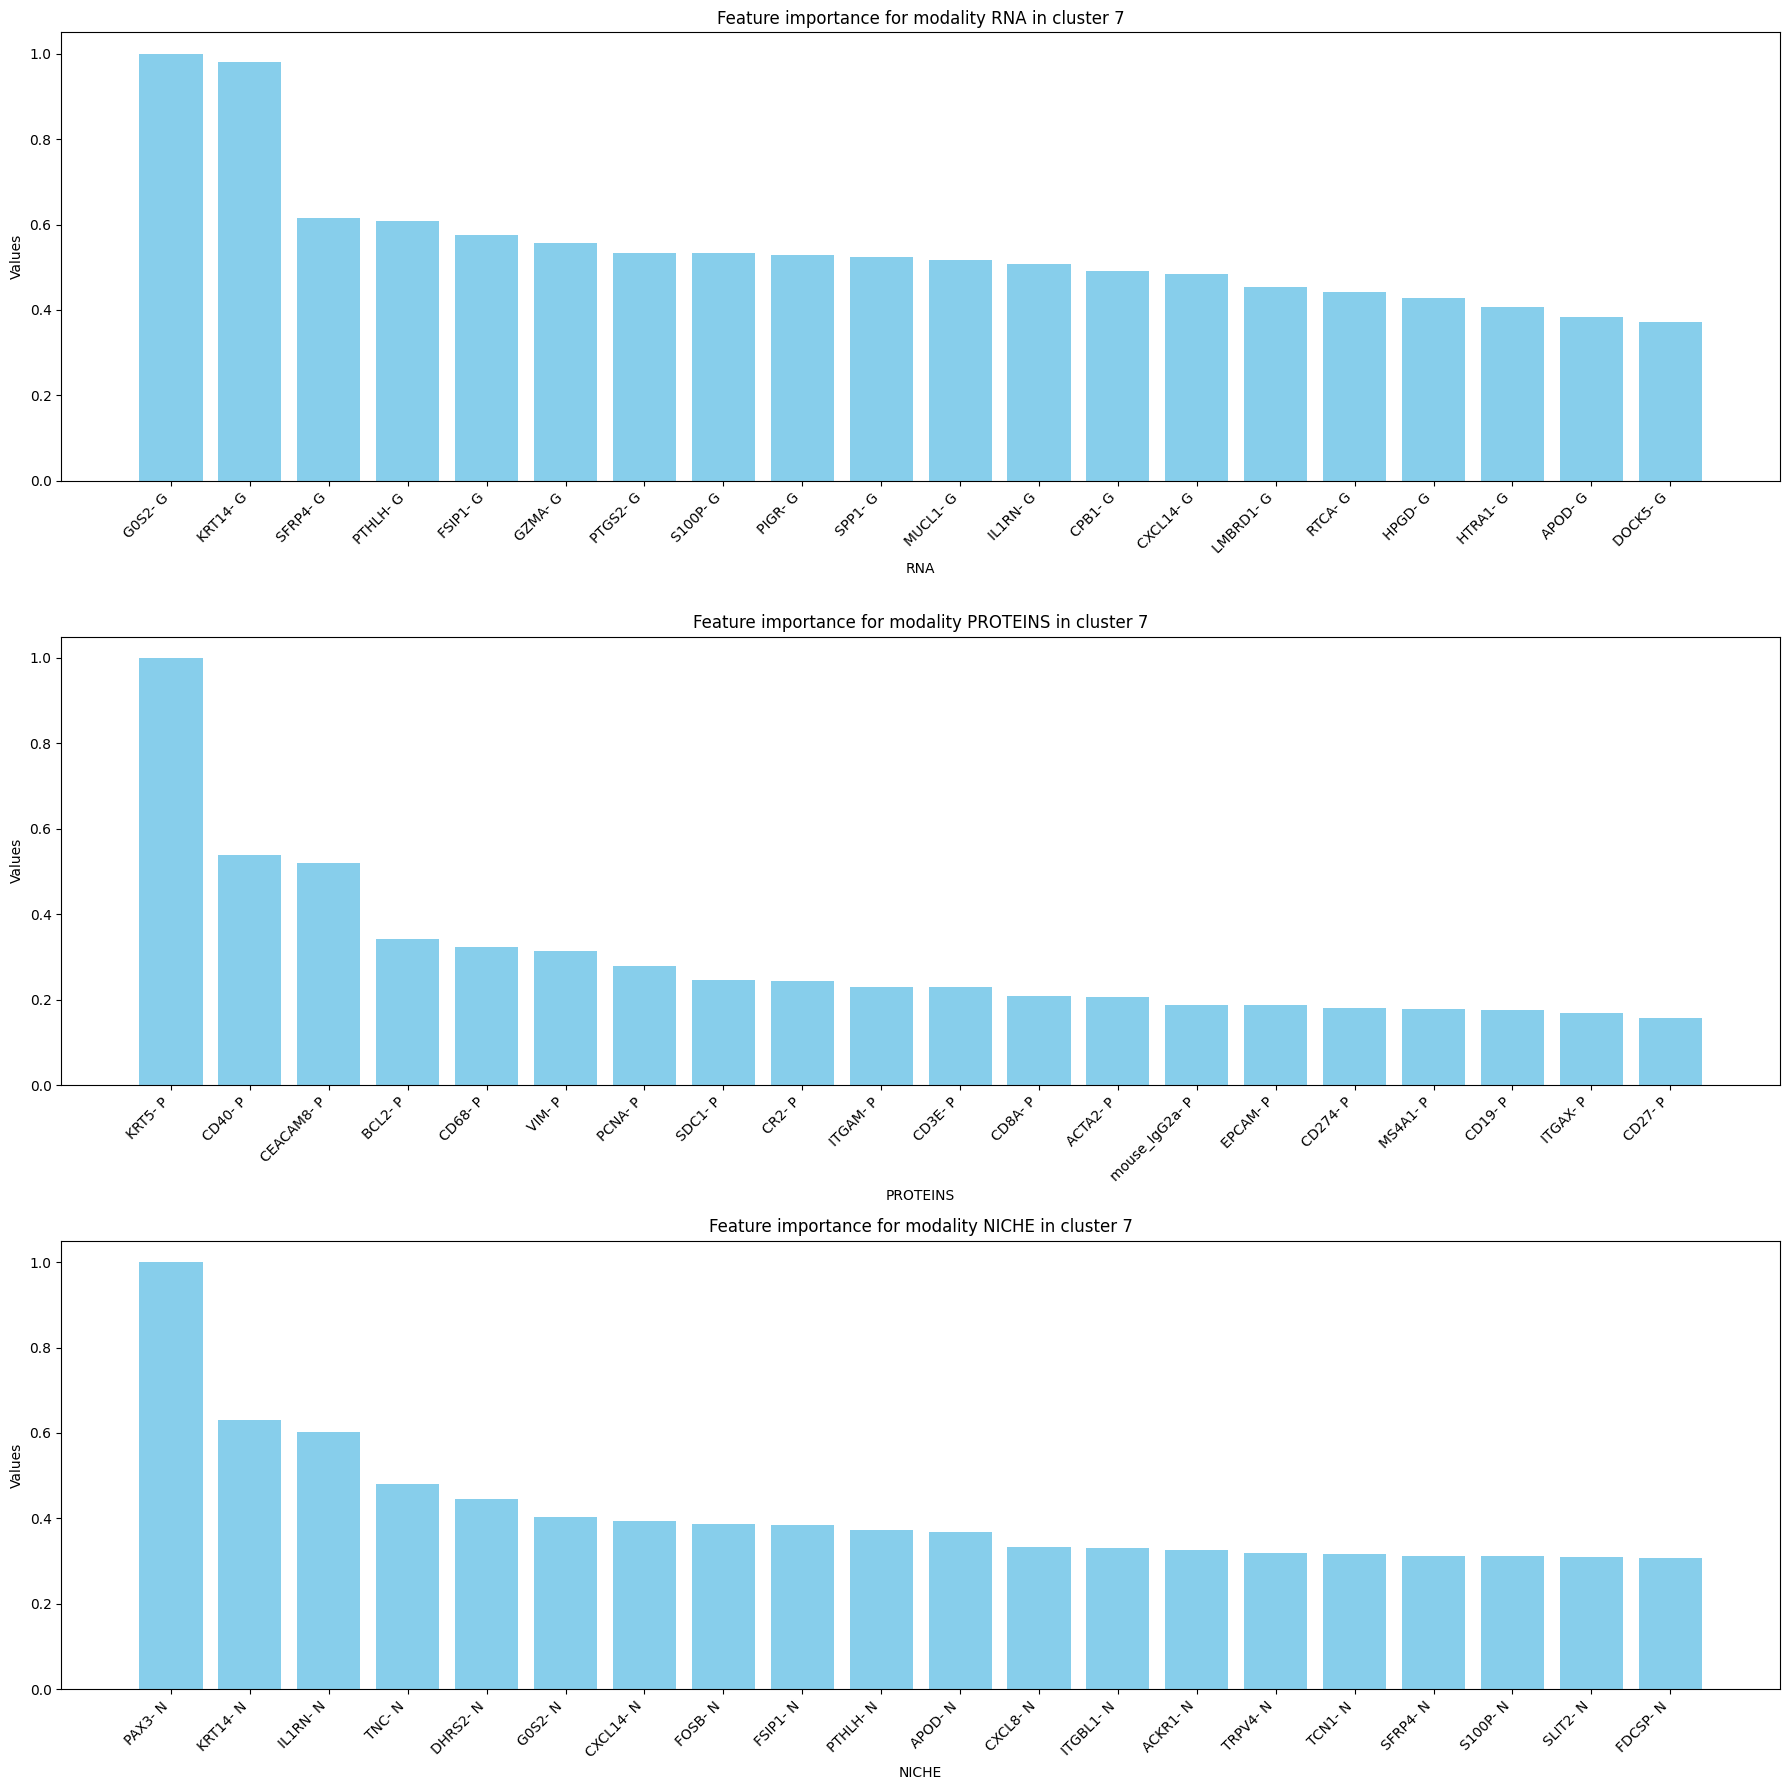

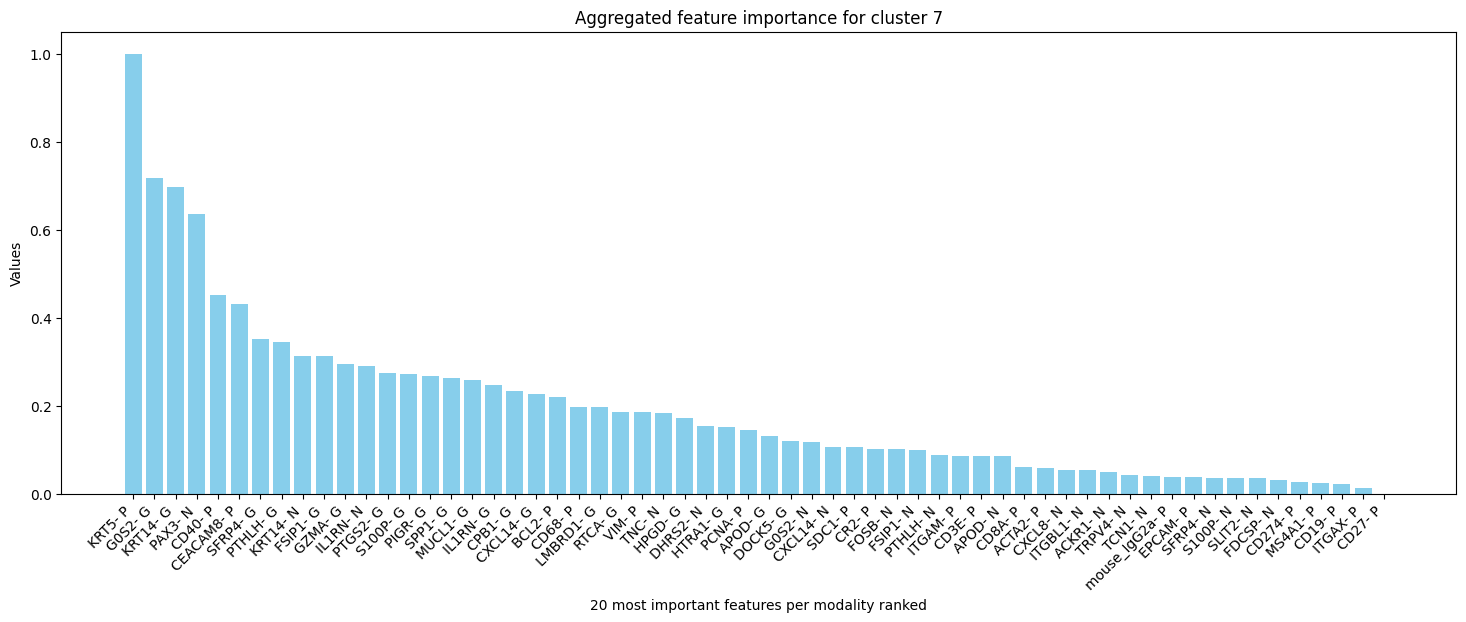

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


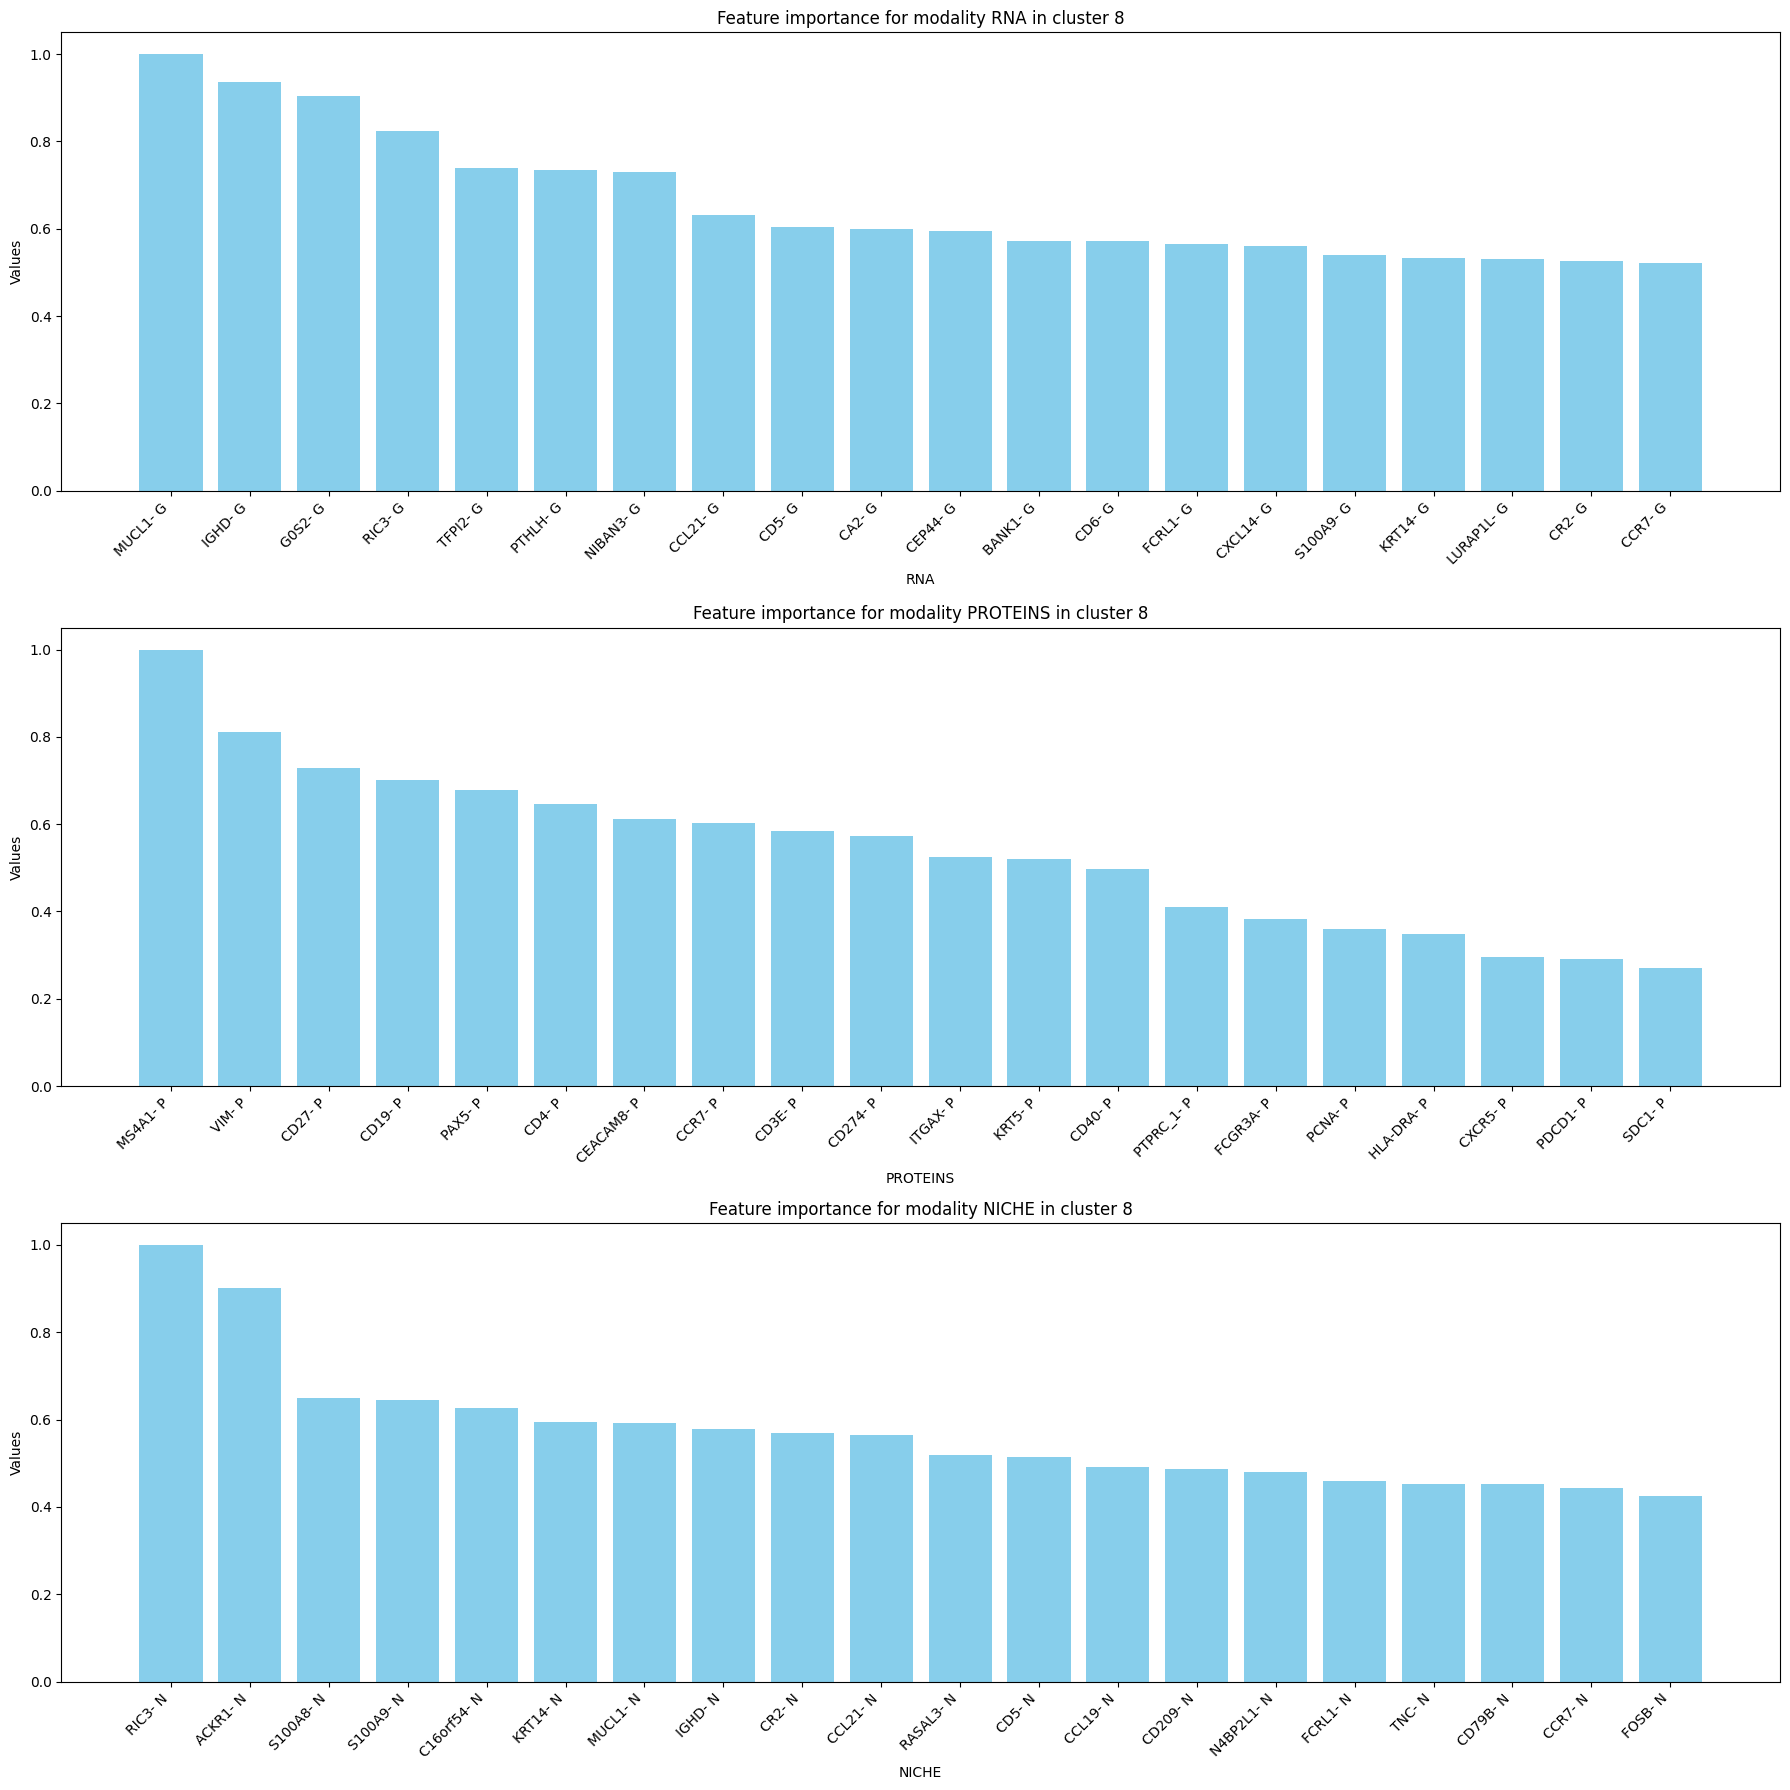

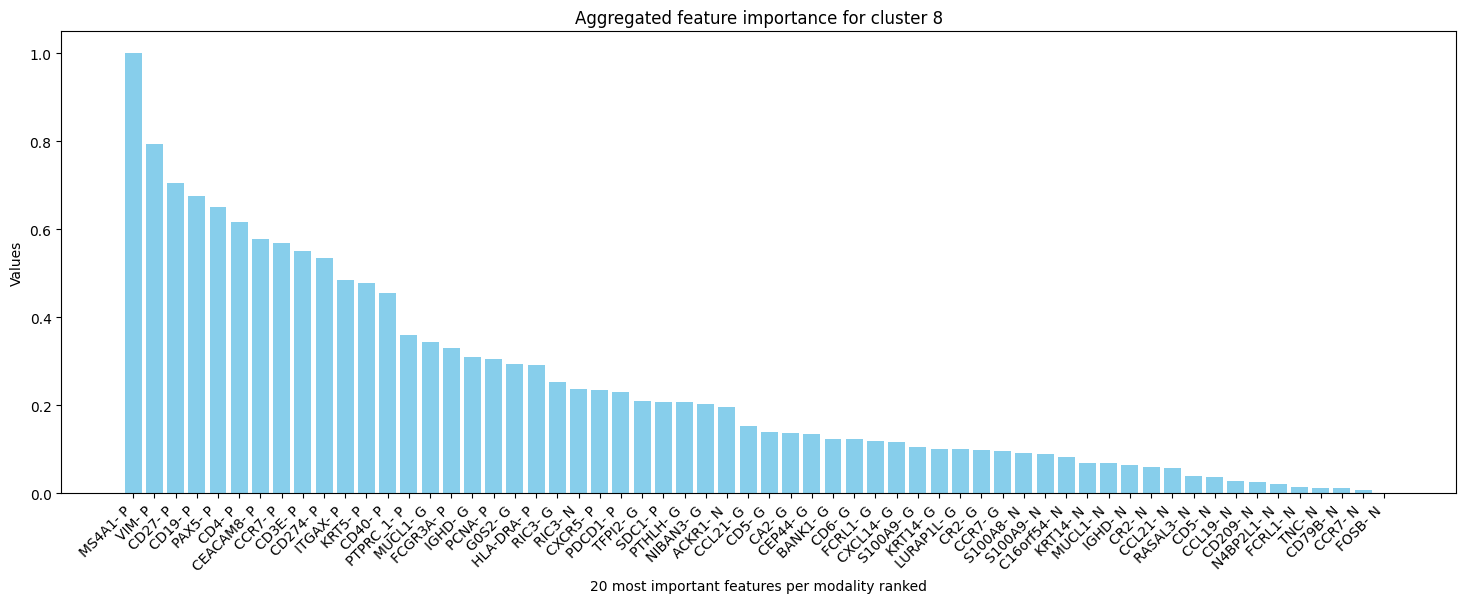

In [30]:
# # 20 most important features for a specific cluster and a specific modality
# def plot_feature_importance(cluster_id):
#     scores_for_all_modalities_per_cluster = scores[cluster_id]
#     features_for_all_modalities_per_cluster = new_all_type_features[cluster_id]

#     def per_modality(ax, modality_id):
#         scores_per_modality = scores_for_all_modalities_per_cluster[modality_id]
#         features_per_modality = features_for_all_modalities_per_cluster[modality_id]
#         sorted_indices = np.argsort(scores_per_modality)[::-1]

#         ax.bar(features_per_modality[sorted_indices], scores_per_modality[sorted_indices], color='skyblue')
#         ax.set_xticklabels(features_per_modality[sorted_indices], rotation=45, ha='right')
#         ax.set_xlabel(modality_names[modality_id])
#         ax.set_ylabel('Values')
#         ax.set_title(f"Feature importance for modality {modality_names[modality_id]} in cluster {cluster_id}")

#     # Create a figure with 3 subplots (one for each modality)
#     fig, axes = plt.subplots(3, 1, figsize=(18, 18))

#     per_modality(axes[0], 0)
#     per_modality(axes[1], 1)
#     per_modality(axes[2], 2)

#     plt.tight_layout()  # Adjust layout to prevent overlapping

#     all_features_for_all_modalities_per_cluster = np.concatenate(
#         list(features_for_all_modalities_per_cluster.values())
#     )
#     aggregated_shap_per_cluster = aggregated_shap[cluster_id]
#     sorted_indices = np.argsort(aggregated_shap_per_cluster)[::-1]

#     plt.figure(figsize=(18, 6))
#     ax = plt.gca()
#     plt.bar(all_features_for_all_modalities_per_cluster[sorted_indices], aggregated_shap_per_cluster[sorted_indices], color='skyblue')
#     ax.set_xticklabels(all_features_for_all_modalities_per_cluster[sorted_indices], rotation=45, ha='right')
#     plt.xlabel('20 most important features per modality ranked')
#     plt.ylabel('Values')
#     plt.title(f"Aggregated feature importance for cluster {cluster_id}")
#     plt.show()

# for cluster_id, _ in major_dict.items():
#     plot_feature_importance(cluster_id)

## Visualising new clusters

In [ ]:
#########------

In [ ]:
#This is the DBiT-seq code that needs to be refactored

In [ ]:
# # Load the pre-trained model
# model = UnitedNet(root_save_path, device=device, technique=dbitseq_config)
# model.load_model(f"{root_save_path}/train_best.pt",device=torch.device(device))
# model.model.device_in_use = device

# # Predict the spatial domains on DBiT-seq dataset based on the UnitedNet model
# predict_label = model.predict_label(adatas_all)

# # Smooth and Plot results
# coord = np.array((list(adatas_all[0].obs['array_row'].astype('int')),
#                   list(adatas_all[0].obs['array_col'].astype('int')))).T

# united_clus = list(predict_label)

# coord = np.array((list(adatas_all[0].obs['array_row'].astype('int')),
#                   list(adatas_all[0].obs['array_col'].astype('int')))).T


# # Perform NearestNeighbors to complete domain identification
# nbrs = NearestNeighbors(n_neighbors=35, algorithm='brute', metric= "minkowski").fit(coord)
# distances,indices = nbrs.kneighbors(coord)

# united_clus_new = []
# for indi, i in enumerate(united_clus):
#     occurence_count = Counter(np.array(united_clus)[(indices[indi])])
#     united_clus_new.append(occurence_count.most_common(1)[0][0])

# cluster_pl = sns.color_palette('tab20', 20)
# color_list = [cluster_pl[5],
#               cluster_pl[1],
#               cluster_pl[2],
#               cluster_pl[4],
#               cluster_pl[11],
#               cluster_pl[6],
#               cluster_pl[3],
#               cluster_pl[7],
#               cluster_pl[8],
#               cluster_pl[0]]

# # Plotting the DBiT-seq spatially clustered data
# plt.figure(figsize=(10, 8))  # Increased the size of the plot
# for idx, clus_id in enumerate(set(united_clus_new)):
#     cluster_indices = np.where(np.array(united_clus_new) == clus_id)[0]
#     plt.scatter(coord[cluster_indices, 0], coord[cluster_indices, 1],
#                 color=color_list[idx], cmap='tab20', label=f'Cluster {clus_id}')

# plt.axis('off')
# plt.legend()
# plt.gca().invert_yaxis()
# plt.show()

In [ ]:
#########------

## Cross-modal predictions across omic modalities and explainability by SHAP

In [16]:
# RUN IN THE deNBI with screen!
# spatial type specific feature-to-feature relevance

calculate_shap = False # True to calculate shap values, False to load them

rna_index = 0
protein_index = 1
niche_index = 2

cluster_prototype_features = [torch.tensor(type_specific_mean(ad_x,'label'),device=model.device) for ad_x in adatas_all]
source_modality = rna_index
target_modality = protein_index


def shap_translation(source_modality, target_modality):
    if calculate_shap:
        sub = submodel_trans(model.model, [source_modality, target_modality]).to(model.device)
        background = cluster_prototype_features[source_modality]
        e = shap.DeepExplainer(sub, background)
        test_type = torch.tensor(adatas_all[source_modality].X,device=model.device)
        shap_values = e.shap_values(test_type,check_additivity=True)
        with open(f'{root_save_path}/shap_values_{source_modality}_{target_modality}.pkl', 'wb') as f:
            pickle.dump(shap_values, f)
    else:
        with open(f'{root_save_path}/shap_values_{source_modality}_{target_modality}.pkl', 'rb') as f:
            shap_values = pickle.load(f)
    return shap_values

shap_genes_to_protein = shap_translation(rna_index, protein_index)
shap_genes_to_niche = shap_translation(rna_index, niche_index)
shap_protein_to_niche = shap_translation(protein_index, niche_index)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


KeyboardInterrupt: 

In [27]:
with open("shap_genes_to_protein.pkl", "rb") as f:
        shap_genes_to_protein = pickle.load(f)

with open("shap_genes_to_niche.pkl", "rb") as f:
        shap_genes_to_niche = pickle.load(f)

with open("shap_protein_to_niche.pkl", "rb") as f:
        shap_protein_to_niche = pickle.load(f)

In [28]:
var_names_all = [ad.var_names.values for ad in adatas_all]

shap_values = {
    "0_1": shap_genes_to_protein,
    "0_2": shap_genes_to_niche,
    "1_2": shap_protein_to_niche,
}


def feature_feature_relevance(source_id: int, target_id: int, make_plot=False):
    var_names = [var_names_all[source_id], var_names_all[target_id]]
    return feature_relevance_chord_plot(
        shap_values[f"{source_id}_{target_id}"],
        unique_predicted_clusters,
        var_names,
        all_type_features,
        f"{technique}_average",
        direction=f"{source_id}to{target_id}",
        in_mod=0,
        thres=None,
        make_plot=make_plot,
        potential_coloarmaps=["spring", "summer", "winter", "autumn"],
    )

In [29]:
source_index = rna_index
target_index = protein_index
id2modality = {0: "RNA", 1: "Protein", 2: "Niche"}
rows = []

combinations = [[rna_index, protein_index], [rna_index, niche_index], [protein_index, niche_index]]

def feature_feature_values(source_index, target_index):
    values, labels = feature_feature_relevance(source_index, target_index, make_plot=False)

    for cluster_id, connections in values.items():
        cluster_labels = labels[cluster_id]
        source_labels = cluster_labels[0]
        target_labels = cluster_labels[1]
        target2source = np.transpose(connections)
        for target_label_id, target_label in enumerate(target_labels):
            for source_label_id, source_label in enumerate(source_labels):
                rows.append(
                    {
                        "Cluster": cluster_id,
                        "Direction": f"{id2modality[source_index]} -> {id2modality[target_index]}",
                        "Target": target_label,
                        "Source": source_label,
                        "Value": target2source[target_label_id][source_label_id],
                    }
                )

for comb in combinations:
    feature_feature_values(comb[0], comb[1])

df = pd.DataFrame(rows)
print(df)
feature_feature_file_path = 'feature_feature_importance_pilot2.csv'
if not Path(feature_feature_file_path).exists():
    df.to_csv(feature_feature_file_path, index=False)

       Cluster         Direction Target   Source     Value
0            0    RNA -> Protein  ACTA2   BMPR1B  0.330267
1            0    RNA -> Protein  ACTA2     CCR7  0.528188
2            0    RNA -> Protein  ACTA2    CD163  0.377127
3            0    RNA -> Protein  ACTA2      CD6  0.462337
4            0    RNA -> Protein  ACTA2     CPB1  0.297754
...        ...               ...    ...      ...       ...
10795        8  Protein -> Niche    TNC     PCNA  0.280339
10796        8  Protein -> Niche    TNC    PDCD1  0.175521
10797        8  Protein -> Niche    TNC  PTPRC_1  0.596876
10798        8  Protein -> Niche    TNC     SDC1  1.000000
10799        8  Protein -> Niche    TNC      VIM  0.394298

[10800 rows x 5 columns]


In [ ]:
df['target']

In [30]:
# Sanity check: The proteins number should be equal or less than 35
subset = df[df['Direction'] == 'RNA -> Protein']

unique = subset['Target'].nunique()

print(f"Number of unique targets in RNA -> Protein: {unique}")

Number of unique targets in RNA -> Protein: 33


In [31]:
# Sanity check: The gene number should not be close to 35
subset = df[df['Direction'] == 'RNA -> Protein']

unique = subset['Source'].nunique()

print(f"Number of unique targets in RNA -> Protein: {unique}")

Number of unique targets in RNA -> Protein: 109


# GenKI for digital KO


In this section, we simulate a genetic perturbation that mimics a CRISPR Knock-Out (KO) experiment targeting one or more specific molecular entities. **GenKI**, a graph variational autoencoder, first reconstructs the underlying **Gene Regulatory Network (GRN)** from the data. It then performs an *in silico* knock-out by removing the selected target gene(s) from the network and quantifies the resulting changes using **Kullback–Leibler (KL) divergence** to identify which genes are most impacted by the perturbation.


In [51]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import re

sc.settings.verbosity = 0

import GenKI as gk
from GenKI.preprocesing import build_adata
from GenKI.dataLoader import DataLoader
from GenKI.train import VGAE_trainer
from GenKI import utils

import stringdb
import networkx as nx

from scipy.sparse import csr_matrix
from scipy.sparse import issparse

We are going to conduct the digital KO using RNA modality from our Visium breast cancer dataset

In [52]:
adata = build_adata("../Data/RNA_BC_500_v2.h5ad",
    uppercase=True)

adata

load counts from ../Data/RNA_BC_500_v2.h5ad


AnnData object with n_obs × n_vars = 4169 × 500
    obs: 'leiden', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial'
    obsm: 'X_pca', 'spatial'
    varm: 'PCs'
    layers: 'raw_layer', 'norm'
    obsp: 'connectivities', 'distances'

In [44]:
# ### Let's commence with creating a digital KO of Six2 expression in the DBiT-seq mouse embryo dataset.
# gene_of_interest = ""

# # Verify that the gene of interest is part of the rownames in adata.var
# if gene_of_interest in adata.var.index:
#     print(f"The gene {gene_of_interest} is present in the rownames of adata.var.")
# else:
#     print(f"The gene {gene_of_interest} is not present in the rownames of adata.var.")

The gene KITLG is not present in the rownames of adata.var.


Let's assemble some potential leads about genes from our dataset that could be viable targets in targeted therapeutic regimens for breast TME:

| **Gene**         | **Key Findings**                                                                                         | **Reference**                                             |
|------------------|----------------------------------------------------------------------------------------------------------|-----------------------------------------------------------|
| **C1QA**         | C1q promotes tumor growth and metastasis in the TME through complement-independent mechanisms.          | Bonavita et al., Nat Commun, 2015. PMID: 25639885        |
| **ID3**          | ID1/ID3 promote metastatic re-initiation and colonization in TNBC.                                       | Gupta et al., PNAS, 2007. PMID: 17909034                 |
| **PLA2G2A**      | CAF subset expressing PLA2G2A supports immune suppression in HER2+ breast cancer.                        | Wu et al., Nat Commun, 2022. PMID: 36261394              |
| **VAMP3**        | VAMP3 promotes chemoresistance and PD-L1 secretion in TNBC.                                              | Lin et al., J Cell Sci, 2024. PMID: 38201683             |
| **CD52**         | CD52 expression correlates with increased immune cell infiltration and better prognosis.                 | Zhang et al., Am J Surg, 2021. PMID: 34314718            |
| **YTHDF2**       | YTHDF2 KO triggers apoptosis in TNBC; supports bone metastasis via m6A regulation.                       | Choe et al., Nat Cell Biol, 2021. PMID: 34373442         |
| **PAX7**         | PAX7 is associated with poor prognosis; promotes Wnt/β-catenin signaling.                                | Wang et al., Cancer Cell Int, 2020. PMID: 32164597       |
| **TNFRSF12A**    | Fn14 signaling promotes metastasis and MMP9 expression in breast cancer.                                 | Pham et al., Nat Commun, 2024. PMID: 38384522            |
| **TREM2**        | TREM2⁺ macrophages support immune evasion and metastasis in breast TME.                                  | Molgora et al., Nat Commun, 2020. PMID: 33177511         |
| **CXCL10**       | CXCL10 promotes therapy resistance, EMT, and metastatic reawakening.                                     | Liang et al., Sci Rep, 2021. PMID: 33741900              |


In [ ]:
# add GenKI code here...

In [53]:
genes = ["C1QA"
    
]

In [54]:
# # Define your list of genes to KO
# ko_genes = genes  # replace with your actual list
# save_dir = "./GenKI_KO_results"  ### change the directory output
# os.makedirs(save_dir, exist_ok=True)

# # Shared hyperparameters
# hyperparams = {"epochs": 100, "lr": 7e-4, "beta": 1e-4, "seed": 8096}
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Flag to control GRN rebuilding
# first_run = True

# for gene in ko_genes:
#     print(f"\n===== Running KO for: {gene} =====")

#     data_wrapper = DataLoader(
#         adata,
#         target_gene=[gene],
#         target_cell=None,
#         obs_label="ident",
#         GRN_file_dir="GRNs",
#         rebuild_GRN=first_run,  # build only on first run
#         pcNet_name="pcNet_",
#         verbose=True,
#         n_cpus=11,
#     )

#     data_wt = data_wrapper.load_data().to(device)
#     data_ko = data_wrapper.load_kodata().to(device)

#     # Init trainer
#     sensei = VGAE_trainer(
#         data_wt,
#         epochs=hyperparams["epochs"],
#         lr=hyperparams["lr"],
#         log_dir=None,
#         beta=hyperparams["beta"],
#         seed=hyperparams["seed"],
#         verbose=False,
#         device=device
#     )

#     sensei.train()

#     # Move everything to CPU for distance calculation
#     sensei.model = sensei.model.to("cpu")
#     data_wt = data_wt.to("cpu")
#     data_ko = data_ko.to("cpu")

#     z_mu_wt, z_std_wt = sensei.get_latent_vars(data_wt)
#     z_mu_ko, z_std_ko = sensei.get_latent_vars(data_ko)

#     dis = gk.utils.get_distance(z_mu_ko, z_std_ko, z_mu_wt, z_std_wt, by="KL")

#     res_raw = utils.get_generank(data_wt, dis, rank=True)
#     null = sensei.pmt(data_ko, n=100, by="KL")
#     res = utils.get_generank(data_wt, dis, null)

#     # Save results
#     save_path = os.path.join(save_dir, f"GenKI_KO_results_{gene}.csv")
#     res.to_csv(save_path)
#     print(f"✅ Saved: {save_path}")

#     # After first run, skip rebuilding GRN
#     first_run = False


===== Running KO for: C1QA =====
use all the cells (4169) in adata
build GRN


2025-07-09 07:22:26,375	INFO worker.py:1783 -- Started a local Ray instance.


ray init, using 11 CPUs
execution time of making pcNet: 167.17 s
GRN has been built and saved in "GRNs/pcNet_.npz"
init completed



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [58]:
# # Parameters
# all_genes_of_interest = ["C1QA"]
# num_GenKI_KO_responsive_genes = 30

# # Loop over all genes for KO simulation
# for gene_of_interest in all_genes_of_interest:
#     print(f"\nProcessing gene: {gene_of_interest}")

#     # Step 1: Prepare data for KO simulation
#     data_wrapper = DataLoader(
#         adata=adata,  # Your AnnData object
#         target_gene=[gene_of_interest],
#         target_cell=None,
#         obs_label="ident",
#         GRN_file_dir="GRNs",
#         rebuild_GRN=True,
#         pcNet_name="Visium500_breast_cancer_complement",
#         verbose=True,
#         n_cpus=20,
#     )
#     data_wt = data_wrapper.load_data()
#     data_ko = data_wrapper.load_kodata()

#     # Step 2: Train VGAE model on WT data
#     sensei = VGAE_trainer(
#         data_wt,
#         epochs=100,
#         lr=7e-4,
#         log_dir=None,
#         beta=1e-4,
#         seed=8096,
#         verbose=False,
#     )
#     sensei.train()

#     # Step 3: Get latent representations
#     z_mu_wt, z_std_wt = sensei.get_latent_vars(data_wt)
#     z_mu_ko, z_std_ko = sensei.get_latent_vars(data_ko)

#     # Step 4: Compute KL-divergence distance between KO and WT
#     dis = gk.utils.get_distance(z_mu_ko, z_std_ko, z_mu_wt, z_std_wt, by="KL")

#     # Step 5: Rank and extract top KO-responsive genes
#     res_raw = utils.get_generank(data_wt, dis, rank=True)
#     top_genes = res_raw.head(num_GenKI_KO_responsive_genes)
#     print(f"Top {num_GenKI_KO_responsive_genes} KO-responsive genes for {gene_of_interest}:\n{top_genes}")

#     # Step 6: Save results
#     os.makedirs('Top_Responsive_Genes', exist_ok=True)
#     out_path = f'Top_GenKI_KO_Responsive_Genes/Top{num_GenKI_KO_responsive_genes}_Responsive_Genes_{gene_of_interest}.csv'
#     top_genes.to_csv(out_path)

#     # Optionally store for later
#     genki_list = top_genes.index.tolist()
#     combined_results.append((gene_of_interest, genki_list))



Processing gene: C1QA
use all the cells (4169) in adata
build GRN


2025-07-09 07:31:31,173	INFO worker.py:1783 -- Started a local Ray instance.


ray init, using 20 CPUs
execution time of making pcNet: 163.47 s
GRN has been built and saved in "GRNs/Visium500_breast_cancer_complement.npz"
init completed

Top 30 KO-responsive genes for C1QA:
                   dis  rank
C1QA      98692.591256     1
KRT14       143.714372     2
CXCL9        30.868046     3
MUCL1        27.576689     4
ZNF385B      25.428806     5
PBX1         23.564583     6
TNC          22.563535     7
KRT7         22.552633     8
TFF3         20.941645     9
WFDC2        19.793641    10
LURAP1L      18.976801    11
MDK          16.416032    12
CXCL10       15.980536    13
ATP9A        15.635568    14
FSIP1        15.346487    15
AGR2         13.260998    16
PIGR         12.973439    17
CA2          12.786911    18
CLU          12.763956    19
IGFBP5       12.717601    20
PKIB         12.171141    21
ITGB4        11.109697    22
APOD         10.797134    23
BMPR1B        9.868225    24
IFIT2         9.711493    25
S100P         9.654208    26
TMEM64        9.39511

In [61]:

# Parameters
all_genes_of_interest = ["C1QA"]
num_GenKI_KO_responsive_genes = 30

# Store gene lists
combined_genki_lists = []

for gene_of_interest in all_genes_of_interest:
    print(f"\nProcessing gene: {gene_of_interest}")

    # Load KO and WT data for GenKI
    data_wrapper = DataLoader(
        adata=adata,
        target_gene=[gene_of_interest],
        target_cell=None,
        obs_label="ident",
        GRN_file_dir="GRNs",
        rebuild_GRN=True,
        pcNet_name="Visium500_breast_cancer_complement",
        verbose=True,
        n_cpus=20,
    )
    data_wt = data_wrapper.load_data()
    data_ko = data_wrapper.load_kodata()

    # Train model
    sensei = VGAE_trainer(
        data_wt,
        epochs=100,
        lr=7e-4,
        log_dir=None,
        beta=1e-4,
        seed=8096,
        verbose=False,
    )
    sensei.train()

    # Extract latent variables and compute KL divergence
    z_mu_wt, z_std_wt = sensei.get_latent_vars(data_wt)
    z_mu_ko, z_std_ko = sensei.get_latent_vars(data_ko)
    dis = gk.utils.get_distance(z_mu_ko, z_std_ko, z_mu_wt, z_std_wt, by="KL")

    # Rank responsive genes
    res_raw = utils.get_generank(data_wt, dis, rank=True)
    top_genes = res_raw.head(num_GenKI_KO_responsive_genes)
    print(f"Top {num_GenKI_KO_responsive_genes} KO-responsive genes for {gene_of_interest}:\n{top_genes}")

    # Save to CSV
    os.makedirs('Top_Responsive_Genes', exist_ok=True)
    out_path = f'Top_Responsive_Genes/Top{num_GenKI_KO_responsive_genes}_Responsive_Genes_{gene_of_interest}.csv'
    top_genes.to_csv(out_path)

    # Store list of top genes
    genki_list = top_genes.index.tolist()
    combined_genki_lists.append((gene_of_interest, genki_list))



Processing gene: C1QA
use all the cells (4169) in adata
build GRN


2025-07-09 07:38:16,183	INFO worker.py:1783 -- Started a local Ray instance.


ray init, using 20 CPUs
execution time of making pcNet: 170.87 s
GRN has been built and saved in "GRNs/Visium500_breast_cancer_complement.npz"
init completed

Top 30 KO-responsive genes for C1QA:
                   dis  rank
C1QA      98692.536266     1
KRT14       143.711474     2
CXCL9        30.867863     3
MUCL1        27.576418     4
ZNF385B      25.430205     5
PBX1         23.565189     6
TNC          22.563091     7
KRT7         22.552745     8
TFF3         20.941156     9
WFDC2        19.794384    10
LURAP1L      18.977110    11
MDK          16.416212    12
CXCL10       15.981369    13
ATP9A        15.635722    14
FSIP1        15.346800    15
AGR2         13.260688    16
PIGR         12.973762    17
CA2          12.786771    18
CLU          12.764100    19
IGFBP5       12.717980    20
PKIB         12.170690    21
ITGB4        11.109469    22
APOD         10.797231    23
BMPR1B        9.868411    24
IFIT2         9.711696    25
S100P         9.654472    26
TMEM64        9.39496

# Assemble the Mongoose list of KO-responsive genes/proteins

## Interpreting Multi-Omic Interactions with SHAP Values

In this part of the notebook, we combine the **KO-responsive gene list from GenKI** with **SHAP (SHapley Additive exPlanations)** values extracted from UnitedNet. This final step of the **Mongoose pipeline** allows us to move beyond the initial simulated knockout and explore its wider impact across **molecular modalities and spatial neighborhoods**.

We specifically analyze SHAP scores along the **RNA → Protein** and **RNA → Niche** paths, offering insight into how the simulated perturbation may cascade from transcriptional changes to effects on proteins and the surrounding tissue environment.

SHAP values in UnitedNet provide **cell-type-specific interpretations**, showing how features from one modality contribute to predictions in another. This interpretability transforms UnitedNet into more than just a predictive model—it becomes a hypothesis-generating tool for discovering biologically meaningful interactions.

UnitedNet is a multi-task deep learning framework introduced in [Tang et al., *Nature Communications* (2023)](https://doi.org/10.1038/s41467-023-37477-x), capable of:
- **Joint group identification** (e.g., clustering cells using multiple modalities)
- **Cross-modal prediction** (e.g., predicting RNA from ATAC or protein levels)

When combined with **GenKI**, which infers gene regulatory networks and predicts the downstream effects of gene knockouts by modeling their absence in latent space ([Yuan et al., *Nature Genetics* (2023)](https://doi.org/10.1038/s41588-023-01450-w)), we set up the Mongoose approach for **spatially and multi-modally aware digital perturbation modeling**.

🔗 *Inspired by UnitedNet (Tang et al., 2023) and GenKI (Yuan et al., 2023)*


## Pull from feature feature only the relevant information tied to GenKI results

In [62]:
# Parameters
num_shap = 5
combined_interaction_dfs = []

# Load SHAP feature-feature importance
shap_df = pd.read_csv('feature_feature_importance_pilot2.csv')

for gene_of_interest, genki_list in combined_genki_lists:
    # Filter relevant interactions
    filtered_data = shap_df[shap_df['Source'].isin(genki_list)]
    rna_niche_data = filtered_data[filtered_data['Direction'] == 'RNA -> Niche']
    rna_protein_data = filtered_data[filtered_data['Direction'] == 'RNA -> Protein']

    # Top interactions
    top_rna_niche = (
        rna_niche_data.sort_values(by='Value', ascending=False)
        .drop_duplicates(subset=['Source', 'Target'])
        .groupby('Source').head(num_shap)
    )
    top_rna_protein = (
        rna_protein_data.sort_values(by='Value', ascending=False)
        .drop_duplicates(subset=['Source', 'Target'])
        .groupby('Source').head(num_shap)
    )

    # Remove self-links
    niche_clean = top_rna_niche[top_rna_niche['Source'] != top_rna_niche['Target']]
    protein_clean = top_rna_protein[top_rna_protein['Source'] != top_rna_protein['Target']]

    # Replenish missing rows
    def replenish(data, removed, clean):
        next_best = (
            data.loc[~data.index.isin(removed.index)]
            .sort_values(by='Value', ascending=False)
            .groupby('Source')
            .apply(lambda x: x[~x['Target'].isin(clean['Target'])].head(1))
            .reset_index(drop=True)
        )
        return next_best

    niche_add = replenish(rna_niche_data, top_rna_niche, niche_clean)
    protein_add = replenish(rna_protein_data, top_rna_protein, protein_clean)

    # Final selections
    final_niche = pd.concat([niche_clean, niche_add]).sort_values(['Source', 'Value'], ascending=[True, False]).groupby('Source').head(num_shap)
    final_protein = pd.concat([protein_clean, protein_add]).sort_values(['Source', 'Value'], ascending=[True, False]).groupby('Source').head(num_shap)

    # Combine and annotate
    combined_df = pd.concat([final_niche, final_protein])
    combined_df['KO_Gene'] = gene_of_interest
    combined_interaction_dfs.append(combined_df)


In [63]:
# Sanity check

# Source: Several if not all of the GenKI KO responsive genes! Main targets to be affected by the digital KO!
# Target: Proteins or other genes that could be also affected based on the UnitedNet cross-modal predictions via SHAP!

combined_interaction_dfs

[      Cluster       Direction Target   Source     Value KO_Gene
 6780        7    RNA -> Niche  TRPV4     APOD  0.633946    C1QA
 6720        7    RNA -> Niche  SLIT2     APOD  0.566789    C1QA
 6640        7    RNA -> Niche   PAX3     APOD  0.543692    C1QA
 6760        7    RNA -> Niche    TNC     APOD  0.504897    C1QA
 0           7    RNA -> Niche   TCN1     APOD  0.473557    C1QA
 ...       ...             ...    ...      ...       ...     ...
 1919        4  RNA -> Protein   SDC1  ZNF385B  1.000000    C1QA
 1819        4  RNA -> Protein  EPCAM  ZNF385B  0.837785    C1QA
 1779        4  RNA -> Protein   CD8A  ZNF385B  0.741916    C1QA
 1719        4  RNA -> Protein   CD3E  ZNF385B  0.729572    C1QA
 1939        4  RNA -> Protein    VIM  ZNF385B  0.688683    C1QA
 
 [190 rows x 6 columns]]

In [64]:
# Sanity check 2
# Are all the genes referenced in the 'Source' column within the genes captured by GenKI?

# Flatten all KO-responsive genes from GenKI into a set
all_genki_genes = set()
for _, genki_list in combined_genki_lists:
    all_genki_genes.update(genki_list)

# Concatenate all SHAP interaction dataframes
all_shap_df = pd.concat(combined_interaction_dfs, ignore_index=True)

# Extract unique SHAP 'Source' genes
shap_source_genes = set(all_shap_df['Source'].unique())

# Compare sets
missing_genes = shap_source_genes - all_genki_genes

# Report
if not missing_genes:
    print("✅ All SHAP 'Source' genes are included in the GenKI KO-responsive outputs.")
else:
    print(f"❌ {len(missing_genes)} SHAP 'Source' genes are missing from GenKI outputs:")
    print(sorted(missing_genes))


✅ All SHAP 'Source' genes are included in the GenKI KO-responsive outputs.


In [65]:
# Sanity check 3
# 1. Get all unique GenKI KO-responsive genes
all_genki_genes = set()
for _, genki_list in combined_genki_lists:
    all_genki_genes.update(genki_list)

# 2. Get all unique SHAP 'Source' genes
all_shap_df = pd.concat(combined_interaction_dfs, ignore_index=True)
shap_source_genes = set(all_shap_df['Source'].unique())

# 3. Intersect the two sets
intersection_genes = shap_source_genes.intersection(all_genki_genes)

# 4. Summary stats
print(f"🧬 Total unique GenKI KO-responsive genes: {len(all_genki_genes)}")
print(f"🔗 Unique SHAP 'Source' genes: {len(shap_source_genes)}")
print(f"✅ SHAP 'Source' genes found in GenKI results: {len(intersection_genes)}")
print(f"📉 Proportion covered: {len(intersection_genes) / len(all_genki_genes):.2%}")


🧬 Total unique GenKI KO-responsive genes: 30
🔗 Unique SHAP 'Source' genes: 19
✅ SHAP 'Source' genes found in GenKI results: 19
📉 Proportion covered: 63.33%


## Produce the final Mongoose list of KO-responsive genes/proteins

In [66]:
genki_records = []

for ko_gene, genki_list in combined_genki_lists:
    # Load GenKI table from CSV (already saved earlier)
    csv_path = f'Top_Responsive_Genes/Top30_Responsive_Genes_{ko_gene}.csv'
    genki_df = pd.read_csv(csv_path, index_col=0)  # Assuming gene names are in index

    for rank, (gene, row) in enumerate(genki_df.iterrows(), start=1):
        genki_records.append({
            "KO_Gene": ko_gene,
            "Responsive_Gene": gene,
            "GenKI_Dis_Score": row['dis'],  # or the correct column name
            "GenKI_Rank": rank
        })

genki_main_df = pd.DataFrame(genki_records)


In [86]:
# Concatenate all SHAP results
all_shap_df = pd.concat(combined_interaction_dfs, ignore_index=True)

# Merge GenKI with SHAP by Responsive_Gene == SHAP.Source
mongoose_df = genki_main_df.merge(
    all_shap_df,
    left_on=['Responsive_Gene', 'KO_Gene'],
    right_on=['Source', 'KO_Gene'],
    how='left'
)


In [87]:
# Rename 'Value' to 'SHAP_Value'
mongoose_df.rename(columns={"Value": "SHAP_Value"}, inplace=True)

mongoose_df['Target'] = mongoose_df.apply(lambda row: f"{row['Target']}.prot" if row['Direction'] == 
                                          'RNA -> Protein' else row['Target'], axis=1)

mongoose_df['Target'] = mongoose_df.apply(lambda row: f"{row['Target']}.niche" if row['Direction'] ==
                                          'RNA -> Niche' else row['Target'], axis=1)

mongoose_df['clean_Target'] = mongoose_df['Target'].str.replace(r'\.(prot|niche)$', '', regex=True)

# Move 'clean_Target' next to 'Target' in mongoose_df
cols = mongoose_df.columns.tolist()
target_idx = cols.index('Target')
cols.insert(target_idx + 1, cols.pop(cols.index('clean_Target')))
mongoose_df = mongoose_df[cols]


In [88]:
mongoose_df

KO_Gene Responsive_Gene  GenKI_Dis_Score  GenKI_Rank  Cluster  \
0      C1QA            C1QA     98692.536266           1      6.0   
1      C1QA            C1QA     98692.536266           1      6.0   
2      C1QA            C1QA     98692.536266           1      2.0   
3      C1QA            C1QA     98692.536266           1      2.0   
4      C1QA            C1QA     98692.536266           1      6.0   
..      ...             ...              ...         ...      ...   
196    C1QA        SERPINA3         9.027943          30      1.0   
197    C1QA        SERPINA3         9.027943          30      1.0   
198    C1QA        SERPINA3         9.027943          30      1.0   
199    C1QA        SERPINA3         9.027943          30      1.0   
200    C1QA        SERPINA3         9.027943          30      1.0   

          Direction        Target clean_Target    Source  SHAP_Value  
0      RNA -> Niche   NUPR1.niche        NUPR1      C1QA    0.732436  
1      RNA -> Niche  RNASE1.niche       RNASE1      C1QA    0.601741  
2      RNA -> Niche   CD163.niche        CD163      C1QA    0.546421  
3      RNA -> Niche   IGHA1.niche        IGHA1      C1QA    0.526314  
4      RNA -> Niche  IGFBP5.niche       IGFBP5      C1QA    0.495013  
..              ...           ...          ...       ...         ...  
196  RNA -> Protein     CCR7.prot         CCR7  SERPINA3    0.575027  
197  RNA -> Protein    CD163.prot        CD163  SERPINA3    0.443699  
198  RNA -> Protein     CD19.prot         CD19  SERPINA3    0.437815  
199  RNA -> Protein     CD27.prot         CD27  SERPINA3    0.425006  
200  RNA -> Protein     CD3E.prot         CD3E  SERPINA3    0.391216  

[201 rows x 10 columns]

In [111]:
mongoose_df.to_csv("Mongoose_Pilot2_C1Qa.csv")

# Computational evaluation of Mongoose results

## 🔬 About Harmonizome and Its Use in This Analysis

The **Harmonizome** is a comprehensive resource developed by the Ma’ayan Laboratory at Mount Sinai that aggregates and harmonizes information about genes and proteins from over 100 publicly available resources. It includes data on gene expression, regulatory relationships, disease associations, functional annotations, and perturbation signatures, offering a unified platform for systems-level biological discovery.

One particularly relevant dataset for perturbation modeling is:

> **LINCS L1000 CMAP CRISPR Knockout Consensus Signatures**  
> This dataset contains consensus gene expression signatures derived from CRISPR knockout (KO) experiments across many cell lines. It helps characterize downstream transcriptional changes following the KO of specific genes.

In this notebook, we:
- Accessed and parsed the **LINCS L1000 CRISPR KO** data from Harmonizome.
- Cross-referenced genes from our simulated digital KO results (via Mongoose) with Harmonizome’s experimentally derived KO signatures.
- Identified overlaps between predicted downstream targets (from the Mongoose model) and genes with empirical perturbation data in Harmonizome.

This allows us to validate and interpret our predictions by comparing **in silico simulated KOs** with **real-world perturbation signatures**, supporting hypothesis generation and prioritization of candidate genes for further study.

🔗 More information available at: [https://maayanlab.cloud/Harmonizome/](https://maayanlab.cloud/Harmonizome/)


Let's load the results we leverage for C1QA from Harmonizome web-page (https://maayanlab.cloud/Harmonizome/gene_set/C1QA/LINCS+L1000+CMAP+CRISPR+Knockout+Consensus+Signatures):

In [114]:
harmonizome_path = "Harmonizome_C1QA.csv"
harmonizome_df = pd.read_csv(harmonizome_path, sep=";")
harmonizome_df

Symbol                                               Name  \
0        CA2                              carbonic anhydrase II   
1     DNAJA3        DnaJ (Hsp40) homolog, subfamily A, member 3   
2      TXLNA                                      taxilin alpha   
3       BEX1                        brain expressed, X-linked 1   
4       MEN1                     multiple endocrine neoplasia I   
..       ...                                                ...   
495   IGFBP1       insulin-like growth factor binding protein 1   
496  ARL6IP5  ADP-ribosylation factor-like 6 interacting pro...   
497     YBX3                            Y box binding protein 3   
498     CDH6      cadherin 6, type 2, K-cadherin (fetal kidney)   
499    CRLF1                    cytokine receptor-like factor 1   

     Standardized Value   
0               0.017574  
1               0.016133  
2               0.015169  
3               0.011931  
4               0.010350  
..                   ...  
495            -0.004156  
496            -0.004154  
497            -0.004151  
498            -0.004148  
499            -0.004141  

[500 rows x 3 columns]

## 🔍 Cross-Referencing Mongoose Predictions with Harmonizome CRISPR KO Data

We now proceed with **data wrangling** to investigate which Mongoose predictions can be independently verified using the **LINCS L1000 CRISPR Knock-Out (KO) data** from the Harmonizome portal.

> ⚠️ **Important Note**  
> The LINCS L1000 CRISPR KO data are derived from **cancer cell lines**, which is a critical context to consider when interpreting overlaps and differences with spatial or primary tissue data.


In [115]:
# Extract unique molecules from Source and clean_Target
unique_molecules = pd.unique(mongoose_df[['Source', 'clean_Target']].values.ravel())
unique_molecules = [m for m in map(str, unique_molecules) if m.lower() not in ['nan', 'mouse_igg2a', 'rat_igg2a']]

# Harmonizome gene symbols
harmonizome_genes = harmonizome_df['Symbol'].dropna().unique()

# Identify overlaps
overlapping_genes = sorted(set(unique_molecules) & set(harmonizome_genes))

# Determine origin of overlaps
in_source = set(mongoose_df['Source']).intersection(overlapping_genes)
in_target = set(mongoose_df['clean_Target']).intersection(overlapping_genes)

# Summary
overlap_origin_summary = {
    'Only in Source': sorted(in_source - in_target),
    'Only in Target': sorted(in_target - in_source),
    'In Both': sorted(in_source & in_target)
}

In [116]:
overlap_origin_summary

{'Only in Source': ['CA2', 'WFDC2'],
 'Only in Target': ['CD163',
  'CD4',
  'CD40',
  'CXCL14',
  'EPCAM',
  'KRT5',
  'NUPR1',
  'PPP1R14B',
  'S100A8',
  'SCGB2A2',
  'TNC'],
 'In Both': ['KRT14']}

In [117]:
mongoose_subset = mongoose_df[
    mongoose_df['Source'].isin(overlapping_genes) |
    mongoose_df['clean_Target'].isin(overlapping_genes)
]

mongoose_subset

KO_Gene Responsive_Gene  GenKI_Dis_Score  GenKI_Rank  Cluster  \
0      C1QA            C1QA     98692.536266           1      6.0   
2      C1QA            C1QA     98692.536266           1      2.0   
10     C1QA           KRT14       143.711474           2      8.0   
11     C1QA           KRT14       143.711474           2      6.0   
12     C1QA           KRT14       143.711474           2      6.0   
13     C1QA           KRT14       143.711474           2      7.0   
14     C1QA           KRT14       143.711474           2      5.0   
15     C1QA           KRT14       143.711474           2      5.0   
16     C1QA           KRT14       143.711474           2      4.0   
17     C1QA           KRT14       143.711474           2      7.0   
18     C1QA           KRT14       143.711474           2      2.0   
19     C1QA           KRT14       143.711474           2      4.0   
37     C1QA           MUCL1        27.576418           4      2.0   
39     C1QA           MUCL1        27.576418           4      5.0   
46     C1QA         ZNF385B        25.430205           5      4.0   
51     C1QA            PBX1        23.565189           6      5.0   
56     C1QA            PBX1        23.565189           6      5.0   
57     C1QA            PBX1        23.565189           6      5.0   
58     C1QA            PBX1        23.565189           6      5.0   
63     C1QA            KRT7        22.552745           8      5.0   
66     C1QA            KRT7        22.552745           8      5.0   
69     C1QA            KRT7        22.552745           8      5.0   
72     C1QA           WFDC2        19.794384          10      0.0   
73     C1QA           WFDC2        19.794384          10      0.0   
74     C1QA           WFDC2        19.794384          10      6.0   
75     C1QA           WFDC2        19.794384          10      0.0   
76     C1QA           WFDC2        19.794384          10      0.0   
77     C1QA           WFDC2        19.794384          10      6.0   
78     C1QA           WFDC2        19.794384          10      0.0   
79     C1QA           WFDC2        19.794384          10      6.0   
80     C1QA           WFDC2        19.794384          10      0.0   
81     C1QA           WFDC2        19.794384          10      6.0   
84     C1QA         LURAP1L        18.977110          11      5.0   
90     C1QA         LURAP1L        18.977110          11      8.0   
99     C1QA          CXCL10        15.981369          13      3.0   
110    C1QA           FSIP1        15.346800          15      0.0   
120    C1QA            PIGR        12.973762          17      7.0   
125    C1QA             CA2        12.786771          18      4.0   
126    C1QA             CA2        12.786771          18      1.0   
127    C1QA             CA2        12.786771          18      4.0   
128    C1QA             CA2        12.786771          18      4.0   
129    C1QA             CA2        12.786771          18      4.0   
130    C1QA             CA2        12.786771          18      8.0   
131    C1QA             CA2        12.786771          18      4.0   
132    C1QA             CA2        12.786771          18      8.0   
133    C1QA             CA2        12.786771          18      4.0   
134    C1QA             CA2        12.786771          18      1.0   
151    C1QA            APOD        10.797231          23      7.0   
153    C1QA            APOD        10.797231          23      5.0   
158    C1QA          BMPR1B         9.868411          24      0.0   
163    C1QA          BMPR1B         9.868411          24      6.0   
167    C1QA          BMPR1B         9.868411          24      0.0   
172    C1QA           IFIT2         9.711696          25      0.0   
177    C1QA           IFIT2         9.711696          25      0.0   
180    C1QA           S100P         9.654472          26      7.0   
197    C1QA        SERPINA3         9.027943          30      1.0   

          Direction          Target clean_Target    Source  SHAP_Value

In [121]:
# Determine which genes are in Source, clean_Target, or both in the Mongoose subset
harmonizome_subset["Mongoose_prediction"] = harmonizome_subset["Symbol"].apply(
    lambda gene: (
        "both" if (gene in set(mongoose_subset["Source"])) and (gene in set(mongoose_subset["clean_Target"]))
        else "GenKI" if gene in set(mongoose_subset["Source"])
        else "UnitedNet" if gene in set(mongoose_subset["clean_Target"])
        else None
    )
)

harmonizome_subset


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Symbol                                               Name  \
0         CA2                              carbonic anhydrase II   
6        CD40   CD40 molecule, TNF receptor superfamily member 5   
12    SCGB2A2                 secretoglobin, family 2A, member 2   
19       KRT5                                 keratin 5, type II   
21      KRT14                                 keratin 14, type I   
108    CXCL14                  chemokine (C-X-C motif) ligand 14   
149       TNC                                         tenascin C   
296     EPCAM                  epithelial cell adhesion molecule   
309     NUPR1      nuclear protein, transcriptional regulator, 1   
320       CD4                                       CD4 molecule   
373    S100A8                    S100 calcium binding protein A8   
428  PPP1R14B  protein phosphatase 1, regulatory (inhibitor) ...   
455     WFDC2                   WAP four-disulfide core domain 2   
487     CD163                                     CD163 molecule   

     Standardized Value  Mongoose_prediction  
0               0.017574               GenKI  
6               0.009912           UnitedNet  
12              0.009137           UnitedNet  
19              0.008370           UnitedNet  
21              0.008351                both  
108             0.005856           UnitedNet  
149             0.005336           UnitedNet  
296            -0.006123           UnitedNet  
309            -0.005831           UnitedNet  
320            -0.005664           UnitedNet  
373            -0.004944           UnitedNet  
428            -0.004491           UnitedNet  
455            -0.004313               GenKI  
487            -0.004179           UnitedNet

## ✅ Key Insight: Mongoose Predicts Credible Targets in BC TME Without Prior Training on actual perturbations

This final part of the analysis highlights the strength of **Mongoose**: by combining a digital KO tool like **GenKI** with an **explainable AI model** such as **UnitedNet**, we can accurately predict downstream targets within the **Breast Cancer Tumor Microenvironment (TME)** — **without any prior knowledge or training** on this specific context.

Notably, many of the genes validated using **Harmonizome's LINCS L1000 CRISPR KO data** are uncovered by the **UnitedNet** component, following the GenKI-predicted knockout of source genes. This underlines the effectiveness of cross-modal reasoning and spatial context in deriving meaningful predictions.
